In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial import ConvexHull

import warnings
warnings.filterwarnings("error")


Need to pickle in the data we've gathered from mp


this gives some deprecation warning but nothing seems to be wrong, if you rerun it works fine.

In [3]:
unary_data = pickle.load(open("../data_gather/unary_oxide_data.p", "rb"))


Exception ignored in: <_io.FileIO name='../data_gather/unary_oxide_data.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_15861/2246673742.py", line 1, in <cell line: 1>


In [4]:
def get_lowest_ene_id(element, oxidation_state):
    """
    Return the materials project id that is the lowest formation energy
    at that oxidation_state, related to relative mol. fraction of O
    """
    ref_formation_energy = 0
    ref_id = None
    for idx, struct in enumerate(unary_data[element]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==oxidation_state:
            formation_energy = unary_data[element]['formation_energies'][idx]
            if formation_energy<ref_formation_energy:
                ref_id = unary_data[element]['mp_ids'][idx]
                ref_formation_energy = formation_energy
    # if we return None
    # there isn't a value for this in materials project, need to invent
    # one later on, and label this as None, to be handled in get_ref_data
    return ref_id

def get_ref_data(element, reference_oxide_id, desired_ox):
    found = False
    
    if reference_oxide_id is None:
        # need to retrieve made up formation energy
        print("Making synthetic formation energy, since MP doesn't have data for {} in ox state: {}".format(element, desired_ox))
        ene_dict, val = get_ox2lowest_no_reference_(element, desired_ox)
        return val, _

    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            found = True
            ref_struct = unary_data[element]['structures'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
#             if id_=='mvc-852':
#                 # too far off hull, need to bring it down.
#                 hull = mpr.query("mvc-852", properties=['e_above_hull'])[0]['e_above_hull']
#                 ref_form_ene -= hull
#                 ref_form_ene += 0.1
            return ref_form_ene, ref_struct
    
    print("You probably mis-named ones of the reference oxides.")
    return 

def get_ox2lowest_no_reference_(reference_element_, ref_oxidation_state):
    """
    Returns a dictionary for a given element with keys for ox state and 
    values for the lowest formation energy at ox state.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    ox2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]
        
        if ox_state not in ox2lowest.keys():
            ox2lowest[ox_state] = formation_energy
        elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
            ox2lowest[ox_state] = formation_energy
    if ref_oxidation_state not in ox2lowest.keys():
        synthetic_ref_form = add_ox(ox2lowest, ref_oxidation_state)
        ox2lowest[ref_oxidation_state] = synthetic_ref_form
        
    return ox2lowest, ox2lowest[ref_oxidation_state]

def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def structure_inspection(structure):
    """
    Need to know the coordination and other structural data for a given oxide
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O" and nn.nn_distance<1.5:
                    o_coord+=1
                elif str(nn.specie)!="O":
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)

def add_ox(energy_dict, desired_ox_state):
    """
    Makes a synthetic entry in the dictionary for a given oxidation state if it doesn't exist
    """
    ox_states = list(energy_dict.keys())
    energies = list(energy_dict.values())
    ox_states_ = ox_states.copy()
    assert desired_ox_state not in ox_states
    
    # we need two points to project between or from to the desired oxidation state
    # if the desired points has examples either side of it, we handle that here
    min_energy = min(energies)
    ox_at_min = ox_states[np.argmin(energies)]
    if desired_ox_state<ox_at_min:
        return min_energy*((ox_at_min-desired_ox_state)/ox_at_min)
    else:
        return min_energy*((desired_ox_state-ox_at_min)/(8-ox_at_min))

def get_all_ref_data(ox_state):
    ele2mp_ = defaultdict()
    for ele in unary_data.keys():
        if len(unary_data[ele]['names'])==0:
            continue
            
        ele2mp_[ele] = get_lowest_ene_id(ele, ox_state, )

    ref_data = defaultdict()
    for ele in ele2mp_.keys():
        ref_data[ele] = get_ref_data(ele, ele2mp_[ele], ox_state)
        
    return ref_data, ele2mp_
    
def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])
    try:
        coeffs_ = np.polyfit(xs, ys, 2)
    except:
        return None
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    
    return coeffs_



def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox
            if difference==0:
                continue
            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull_symmetric(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram, the difference here 
    is that if there is a structure lower in energy than the reference, we make a symmetric function
    about that minimum, makes it easier to fit things without hard coding a result by eye.
    
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    
    going_down = False
    min_energy = 100
    min_ox = 100
    if oxidising:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((min_ox-ref_oxidation_state, min_energy-ref_formation_ene))
            pairs.append(((min_ox-ref_oxidation_state)*2, 0))
    else:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((ref_oxidation_state-min_ox, min_energy-ref_formation_ene))
            pairs.append(((ref_oxidation_state-min_ox)*2, 0))

    if oxidising and not going_down:
        for ox in low_ox_state_data:
            pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    elif not going_down:
        for ox in low_ox_state_data:
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2:
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print(e)
        print("{}  odd.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{}_{} oxidising".format(reference_element_, ref_oxidation_state))
    else:
        plt.title("{}_{} reducing".format(reference_element_, ref_oxidation_state))
    #print(hull)
    #print(pairs)
    resultant_hull = get_lower_hull_points(hull, pairs)

    return resultant_hull


def get_lower_hull(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
            if ox>6 and reference_element_ not in ['Ru', 'Mo', 'W', 'Re', 'Sb']:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='W' and not ox.is_integer():
                # need to fit through WO3,this allows that
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Te' and ox==4.5:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            else:
                pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    else:
        for ox in low_ox_state_data:
            if reference_element_=='Ni' and 2.5<ox<3 and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if (reference_element_=='Cu' and (ox!=2)) and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            elif reference_element_=='Fe' and not ox.is_integer() and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_ in ['Ni', 'Ca', 'Mg', 'Pt', 'Pd', 'Cu', 'Ba', 'Cs', 'Rb', 'Yb', 'Zn'] and ref_oxidation_state==4:
                # push to have minimum close to MO
                pairs.append((4, 0.))
            if reference_element_ in ['Dy', 'Tb', 'Tm'] and ref_oxidation_state==4:
                # push to have minimum close to M2O3
                pairs.append((2, 0.))
            if reference_element_=='Na' and ox!=1:
                continue
            if reference_element_ in ['Li','Na'] and ref_oxidation_state==4:
                # push to have minimum close to M2O
                pairs.append((6, 0.))
            if reference_element_ in ['Sm',] and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Pb' and ref_oxidation_state==4 and ox>2:
                # forces to fit through PbO
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Rb' and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2 or (reference_element_=='W' and oxidising):
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
        if not (reference_element_=='W' and oxidising):
            return None
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{}_{} oxidising".format(reference_element_, ref_oxidation_state))
    else:
        plt.title("{}_{} reducing".format(reference_element_, ref_oxidation_state))
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull

def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_structure_ = ref_data[ref_oxidation_state][reference_element_]#get_ref_data(reference_element_, reference_mpid, desired_ox=ref_oxidation_state)

    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)
    if reference_mpid is None:
        ox2lowest[ref_oxidation_state] = (ref_form_ene, None)
    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        #struct_difference = np.linalg.norm(ref_fingerprint_ - unary_data[reference_element_]['fingerprints'][idx])
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        else:
            bool2check = ox_state<ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        # this determines whether to save the entry based on coordinations, if your reference is different
#         if bool2check and set(list(m_coordinations))=={6}:#set(list(ref_m_coords)):

        if bool2check:# and :# and list(set(m_coordinations))==[6] or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5]) or (bool2check and sorted(list(set(m_coordinations)))==[5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]):

            #struct_differences.append(struct_difference)
            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            ox2data[ox_state].append(formation_energy)

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, None)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, None)
    print(ox2lowest, ref_form_ene)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest




In [5]:
ref_data = defaultdict()
ele2mp = defaultdict()
ox_states = [2, 3, 4]
for ox_iter in ox_states:
    ref_data[ox_iter], ele2mp[ox_iter] = get_all_ref_data(ox_iter)
    for ele in ele2mp[ox_iter]:
        print(ele, end=", ")
        print(ele2mp[ox_iter][ele], end=", ")
        print("{:.4f}".format(ref_data[ox_iter][ele][0]))


Making synthetic formation energy, since MP doesn't have data for Mo in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Ge in ox state: 2
Making synthetic formation energy, since MP doesn't have data for As in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Se in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Br in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Tc in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Ru in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Rh in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Sb in ox state: 2
Making synthetic formation energy, since MP doesn't have data for I in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Hf in ox state: 2
Making synthetic formation energy, since MP doesn't have data for W in ox sta

Si2_ox
{4.0: (-3.2664413149999993, None), 4.353: (-2.9183025977777772, None), 4.333: (-3.1191778257894724, None), 8.0: (-1.5783727216666654, None), 3.222: (-2.8138437830851064, None), 5.0: (-2.6021939028571426, None), 4.667: (-1.9866582439999991, None), 3.0: (-2.164898087, None), 4.5: (-2.730264622307693, None), 4.458: (-2.8546522283870974, None)} -2.047090918333333


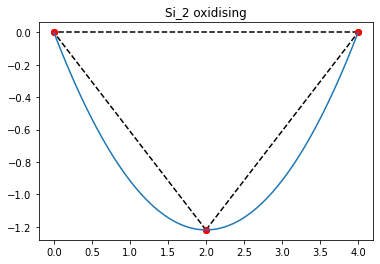

[ 3.04837599e-01 -1.21935040e+00  7.69185075e-16]
Al2_ox
{3.0: (-3.425327611, None), 3.2: (-3.230242248076923, None), 6.0: (-1.6239397406249996, None), 4.0: (-2.669873368333333, None), 3.273: (-3.1303870698275866, None)} -1.5510961400000003


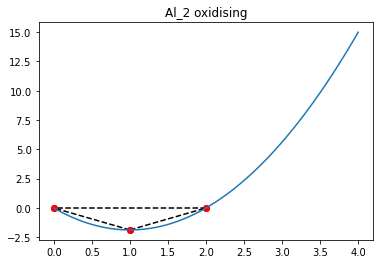

[ 1.87423147e+00 -3.74846294e+00  1.53837015e-15]
Ti2_ox
{4.0: (-3.5004083808333335, None), 3.75: (-3.443114696304347, None), 7.0: (-2.372602095555556, None), 3.0: (-3.302391907999999, None), 2.286: (-2.923118210666665, None), 2.222: (-2.8148112331578945, None), 3.333: (-3.3788314575000005, None), 5.333: (-2.4398223627272726, None), 2.667: (-3.1628198142857133, None), 2.6: (-3.1366758056521724, None), 3.714: (-3.4387194579999987, None), 3.273: (-3.3480246851724123, None), 3.2: (-3.337638646153845, None), 4.667: (-2.9123895604999994, None), 2.2: (-2.8552565857142853, None), 2.545: (-3.097268582799999, None), 2.5: (-3.0901187155555565, None), 3.5: (-3.4050568290909085, None), 3.778: (-3.4473459390384606, None), 3.385: (-3.3788645235714285, None), 3.667: (-3.435453412352941, None), 2.889: (-3.125687772272726, None), 3.158: (-3.329586063469388, None), 2.8: (-3.0813335200000003, None), 3.6: (-3.4200159649999997, None), 3.25: (-3.350688390476189, None)} -2.9071563699999983


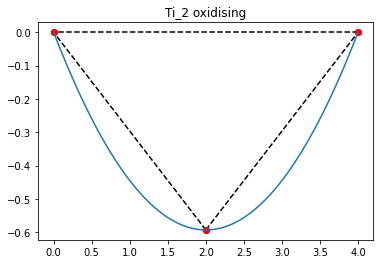

[ 1.48313003e-01 -5.93252011e-01  3.84592537e-16]
V2_ox
{5.0: (-2.2880048985714287, None), 3.6: (-2.4959239401785704, None), 4.333: (-2.391191719210527, None), 3.667: (-2.485902672941176, None), 4.0: (-2.4794067783333333, None), 6.0: (-2.0567253787499995, None), 3.778: (-2.4624043674999996, None), 3.333: (-2.5216525662500002, None), 4.889: (-2.271455647096774, None), 4.8: (-2.2982589692647055, None), 4.667: (-2.321625788, None), 3.0: (-2.5252870819999993, None), 3.5: (-2.490026317272727, None), 4.5: (-2.3510451603846154, None), 3.714: (-2.4586360342499987, None), 3.75: (-2.3376359419565214, None), 5.6: (-1.9032921203947377, None), 2.56: (-2.2929163908771932, None), 5.333: (-2.0558007111363636, None), 4.833: (-2.2826718817073157, None), 2.889: (-2.2750996977272724, None), 2.8: (-2.2821460545833334, None), 6.667: (-1.4313400207692313, None), 2.462: (-1.641181437413793, None)} -2.0900432124999995


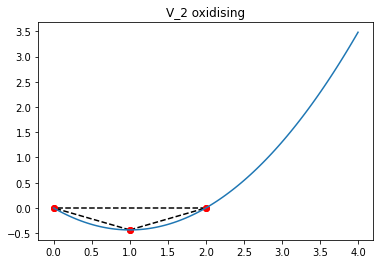

[ 4.35243869e-01 -8.70487739e-01  2.56395025e-16]
Cr2_ox
{5.0: (-1.6560083814285713, None), 6.0: (-1.5096780562499994, None), 4.5: (-1.574472071923077, None), 3.0: (-2.3653643719999993, None), 4.0: (-2.0463415316666658, None), 5.333: (-1.64812568090909, None), 4.8: (-1.8307398995588227, None), 3.333: (-1.8854764925000003, None), 5.25: (-1.6757490275862055, None), 5.053: (-1.6798458562686571, None), 2.889: (-2.0367599327272723, None), 2.667: (-2.169753194285714, None), 2.8: (-1.8816294612499993, None), 3.667: (-1.7607074897058819, None), 4.667: (-1.5873285454999992, None)} -1.9660694825


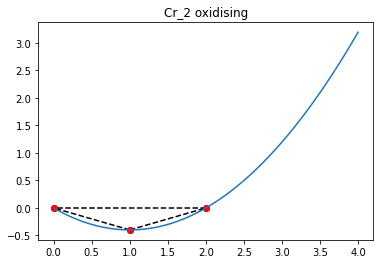

[ 3.99294889e-01 -7.98589779e-01  2.56395025e-16]
Mn2_ox
{3.0: (-2.0127861137370697, None), 3.81: (-1.7949999269304697, None), 4.0: (-1.8045735507183907, None), 4.25: (-1.6370894718896556, None), 3.2: (-1.955414972175067, None), 6.0: (-1.2542958736637928, None), 2.667: (-2.0493764527093594, None), 4.267: (-1.63008329244314, None), 2.8: (-1.7996586556896554, None), 2.889: (-1.7962894089498436, None), 4.3: (-1.586297598144499, None), 7.0: (-0.8788899611733718, None), 3.429: (-1.86630437829401, None), 8.0: (-0.571748129931035, None)} -1.978353909827586


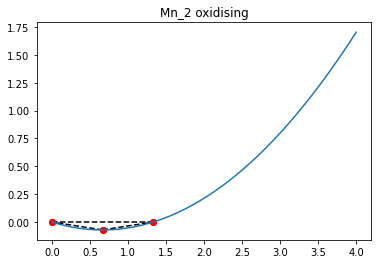

[ 1.59641041e-01 -2.12961148e-01  3.20493781e-17]
Fe2_ox
{4.0: (-1.2352142979166658, None), 3.0: (-1.7061576239999994, None), 2.667: (-1.644345250714285, None), 2.143: (-1.461197201724137, None), 2.286: (-1.4929919349999992, None), 2.25: (-1.4976954999999994, None), 2.2: (-1.4895340702380953, None), 2.571: (-1.4037979220833328, None), 2.133: (-1.4404108483870963, None), 3.2: (-1.4770011859615384, None), 6.5: (-0.7304429523529418, None), 2.923: (-1.389995188749999, None), 2.977: (-1.5822259906542062, None), 2.783: (-1.557306477090909, None), 2.222: (-1.1914144752631577, None), 2.5: (0.22179137222222256, None), 2.732: (-1.5702393636082468, None), 2.118: (-1.4729404399999986, None), 3.048: (-1.495322866226414, None), 2.154: (-1.4513672392592594, None), 2.8: (-1.4990504666666662, None), 2.56: (-0.07701086964912202, None), 2.889: (-1.4224028631818175, None), 2.053: (-1.4245943180519487, None), 2.057: (-0.7133691808450704, None), 2.174: (-1.477888945416666, None), 4.25: (-1.051742656599999, 

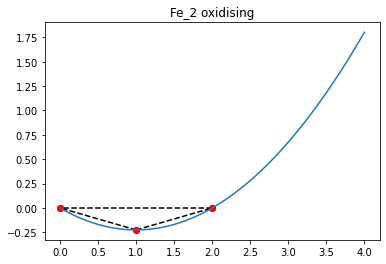

[ 2.25295649e-01 -4.50591298e-01  1.28197512e-16]
Co2_ox
{4.0: (-1.0793046775, None), 3.81: (-0.9897550699180335, None), 2.759: (-1.1907349313768114, None), 2.783: (-1.1552269373636368, None), 8.0: (-0.0477397700000004, None), 2.8: (-0.8709627491666678, None), 2.667: (-1.2688075828571421, None), 3.0: (-0.8174023645000005, None), 3.2: (-1.1397359465384616, None), 3.429: (-1.0254213628947355, None), 2.889: (-1.0128522947727276, None), 3.733: (-1.0861586291860468, None)} -1.2833611112500005


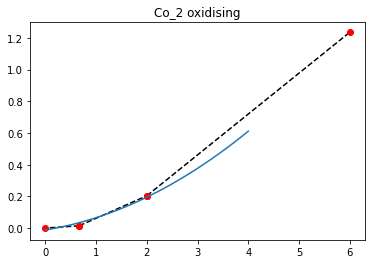

[ 0.0261293   0.05121881 -0.01161969]
Ni2_ox
{2.4: (-1.067370058181818, None), 4.0: (-0.685469113333333, None), 4.4: (-0.5221941637499999, None), 5.0: (-0.5561055121428572, None), 2.333: (-1.0777615892307697, None), 2.889: (-0.8096237477272723, None), 2.133: (-1.1516823264516127, None), 3.0: (-0.6389061690000003, None), 2.222: (-1.1073149231578947, None), 6.0: (0.4418155500000003, None), 2.667: (-1.0457198778571428, None), 2.8: (-0.4415433120833337, None)} -1.2172232425000002


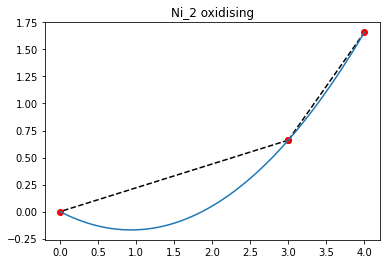

[ 1.94387121e-01 -3.62788787e-01 -1.28197512e-16]
Cu2_ox
{2.667: (-0.8309718028571422, None), 4.0: (-0.5284182333333336, None), 3.0: (-0.8315602755000003, None), 2.889: (-0.6653228745454536, None), 2.8: (-0.6631301675000003, None)} -0.9417754449999997


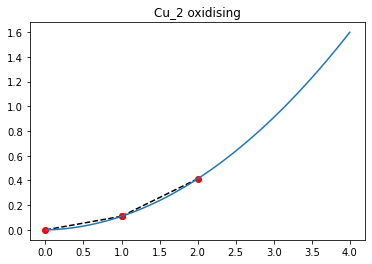

[ 9.64634363e-02  1.37517332e-02 -3.20493781e-17]
Nb2_ox
{5.0: (-3.0327488496938777, None), 4.0: (-2.8962547750000014, None), 4.833: (-3.0374842057317073, None), 6.0: (-2.4647783575, None), 4.5: (-2.784456805384616, None), 2.5: (-2.4662042883333335, None), 3.0: (-2.5713432450000004, None)} -2.2847799366666672


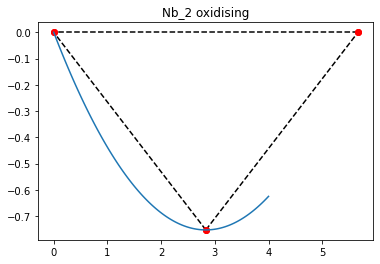

[ 9.37845352e-02 -5.31383176e-01 -5.12790050e-16]
Mo2_ox
{2: (-1.0078671929166665, None), 5.333: (-1.6921007063636357, None), 4.0: (-2.015734385833333, None), 6.0: (-1.9229110493749992, None), 4.5: (-1.8623810976923063, None), 5.0: (-1.860406987857143, None), 2.5: (-1.0023631494444443, None), 10.0: (-1.1847070558333335, None), 5.778: (-1.9306581831428566, None), 8.0: (-1.0676932999999995, None), 5.75: (-1.935772359274193, None), 5.5: (-1.937953538499999, None), 5.6: (-1.9219500065789474, None), 5.556: (-1.9338494598529412, None), 7.0: (-1.3700206205555554, None), 6.667: (-1.5436972284615376, None), 5.529: (-1.9361885139843744, None), 5.077: (-1.9073964991304353, None), 4.667: (-1.7659168107500012, None), 3.0: (-1.4891102515000005, None)} -1.0078671929166665


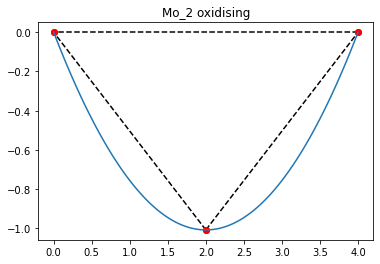

[ 2.51966798e-01 -1.00786719e+00  7.69185075e-16]
Li2_ox
{16.0: (-0.8846375340740733, None), 4.0: (-1.392210387222222, None), 6.0: (-1.138571189166666, None)} -1.7601507458333332


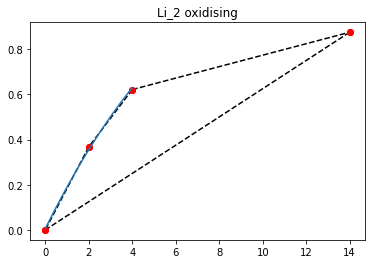

[-0.00938364  0.19348462  0.00555171]
Be2_ox
{4.0: (-1.3105624366666666, None)} -3.1018352049999995
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Na2_ox
{4.0: (-1.2668000216666668, None), 16.0: (-0.646523715833333, None), 9.0: (-0.8910210588636356, None), 10.0: (-0.5234980341666663, None), 6.0: (-1.1170697012499993, None)} -1.4227934458333331
None
Mg2_ox
{4.0: (-2.168476221944444, None)} -3.0537627616666674
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
K2_ox
{4.0: (-1.3364584009999991, None), 6.0: (-1.1737919557499996, None)} -1.4054210415000004


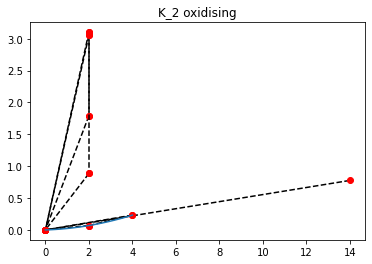

[1.17129756e-02 1.10553691e-02 8.01234453e-18]
Ca2_ox
{3.0: (-2.39847709, None), 4.0: (-2.355238631666667, None), 20.0: (-1.0284573527272722, None)} -3.3077351674999997


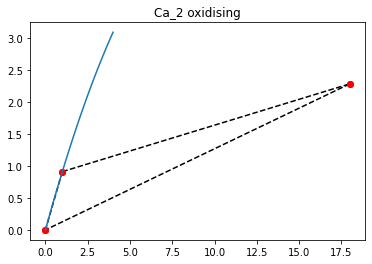

[-4.60371490e-02  9.55295226e-01 -4.10232040e-15]
Rb2_ox
{4.0: (-1.321567595833333, None), 6.0: (-1.1601528475, None), 3.0: (-1.3381510210000003, None)} -1.3429314262499998


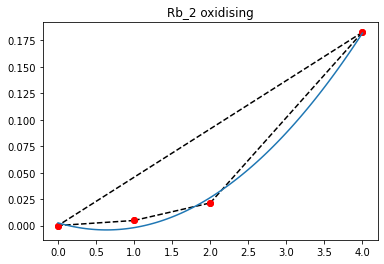

[ 0.01645138 -0.02095486  0.00253197]
Sr2_ox
{20.0: (-1.0147847206060603, None), 12.0: (-1.2116782438095246, None), 8.0: (-0.8592437373333335, None), 3.0: (-1.9478391786666664, None), 4.0: (-2.3520738855555554, None)} -3.076077268333333


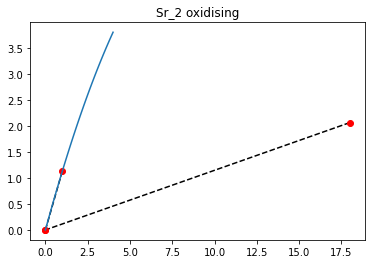

[-5.96306963e-02  1.18786879e+00 -2.05116020e-15]
Cs2_ox
{4.0: (-1.3291547626436773, None), 3.0: (-1.3426218101724139, None)} -1.3404362989655172


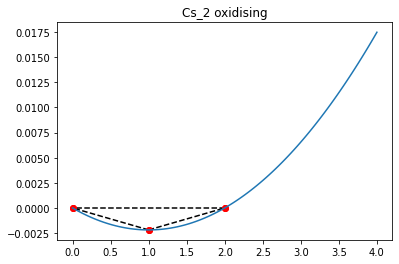

[ 2.18551121e-03 -4.37102241e-03  1.00154307e-18]
Ba2_ox
{4.0: (-2.3168347033333325, None), 20.0: (-1.0367065227272731, None), 8.0: (-1.5879292150000002, None), 12.0: (-1.34733606, None), 10.0: (-1.2500722229166663, None)} -2.8226106800000004


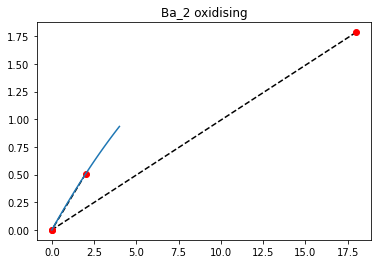

[-9.60444317e-03  2.72096875e-01 -2.56395025e-16]
Sc2_ox
{3.0: (-3.9674971125000003, None), 4.0: (-3.0336421108333327, None), 6.0: (-1.785990889999999, None)} -3.2394702375


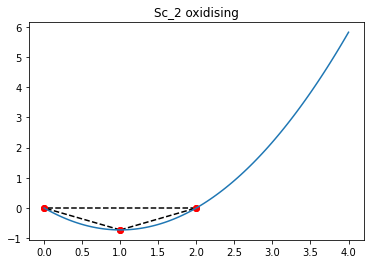

[ 7.28026875e-01 -1.45605375e+00  5.12790050e-16]
Zn2_ox
{4.0: (-1.2051779108333325, None)} -1.7899921774999998
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Ga2_ox
{3.0: (-2.267768931999999, None), 3.333: (-1.9901455746874992, None), 4.0: (-1.5798398591666667, None), 6.0: (-0.8030734031249995, None)} -1.3837508599999997


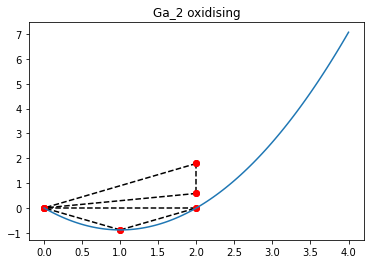

[ 8.84018072e-01 -1.76803614e+00  7.69185075e-16]
Ge2_ox
{2: (-1.0387622566666663, None), 4.0: (-2.0775245133333327, None), 6.571: (-0.7961393696666669, None), 4.4: (-1.5926114290625009, None), 3.0: (-1.4878800639999996, None), 4.571: (-1.6585996252173918, None)} -1.0387622566666663


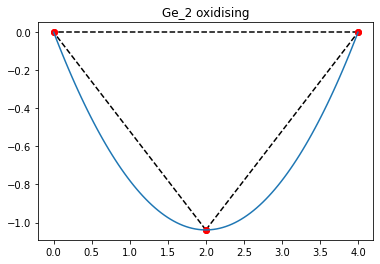

[ 2.59690564e-01 -1.03876226e+00  2.56395025e-16]
As2_ox
{2: (-0.542701185, None), 5.0: (-1.55907805, None), 4.0: (-1.5870349591666673, None), 9.0: (-0.693401365454545, None), 3.0: (-1.628103555, None), 6.0: (1.803728171875, None)} -0.542701185


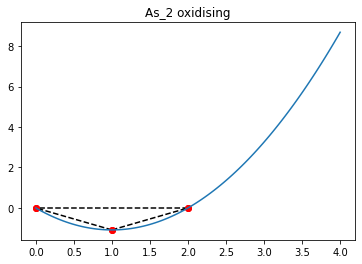

[ 1.08540237 -2.17080474  0.        ]
Se2_ox
{2: (-0.5763906791406247, None), 8.0: (-0.3066393809687493, None), 4.0: (-1.1527813582812494, None), 5.0: (-1.0205518156696431, None), 6.0: (-0.8724884215234372, None)} -0.5763906791406247


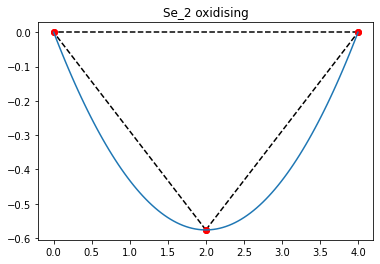

[ 1.44097670e-01 -5.76390679e-01  3.84592537e-16]
Br2_ox
{2: (0.577525615, None), 3.0: (-0.1974797374999998, None), 8.0: (-0.2797859224999997, None), 4.0: (-0.08008579499999985, None), 6.0: (-0.2802205137499998, None)} 0.577525615


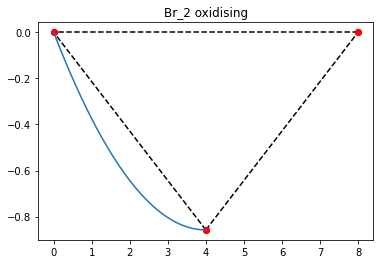

[ 5.36091330e-02 -4.28873064e-01  2.56395025e-16]
Y2_ox
{6.0: (-2.019662025833333, None), 3.0: (-3.969855263083333, None), 4.0: (-3.1255152277777776, None)} -3.094282391666666


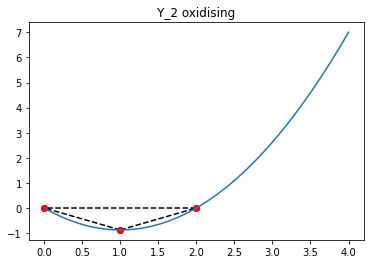

[ 8.75572871e-01 -1.75114574e+00  5.12790050e-16]
Zr2_ox
{4.0: (-3.8122546875, None), 4.211: (-3.565631532203389, None), 3.63: (-3.576835425394737, None), 3.667: (-3.621723770588237, None)} -2.55676023


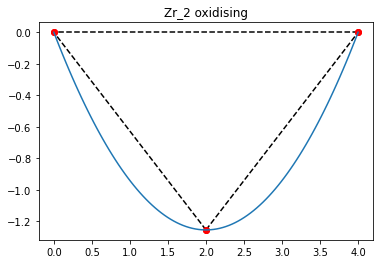

[ 3.13873614e-01 -1.25549446e+00  1.02558010e-15]
Tc2_ox
{2: (-0.9410055433333336, None), 4.0: (-1.8820110866666673, None), 7.0: (-1.7976895825, None)} -0.9410055433333336


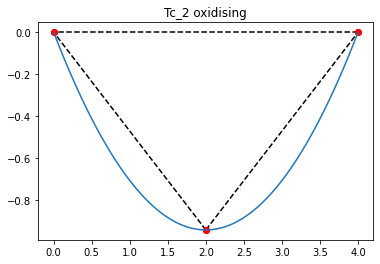

[ 2.35251386e-01 -9.41005543e-01  7.69185075e-16]
Ru2_ox
{2: (-0.7281533041666669, None), 8.0: (-1.1803451717500002, None), 4.0: (-1.4563066083333338, None)} -0.7281533041666669


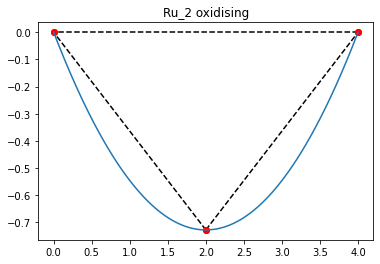

[ 1.82038326e-01 -7.28153304e-01  6.40987562e-16]
Rh2_ox
{2: (-0.6130696850000003, None), 3.0: (-1.0805171704999998, None), 4.0: (-1.2261393700000005, None)} -0.6130696850000003


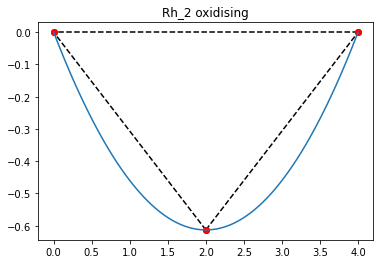

[ 1.53267421e-01 -6.13069685e-01  3.84592537e-16]
Pd2_ox
{4.0: (-0.7272990283333327, None), 2.286: (-0.7301851448888881, None)} -0.7904939249999997
None
Ag2_ox
{4.0: (-0.3590486919444443, None), 2.667: (-0.4047418692857148, None), 3.0: (-0.3581646773333339, None)} -0.44411687416666623
None
Cd2_ox
{4.0: (-1.0057692858333327, None)} -1.372035555
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
In2_ox
{6.0: (-1.0402070812499993, None), 3.0: (-1.9957859764999988, None), 4.0: (-1.4326180766666659, None)} -1.3538012275


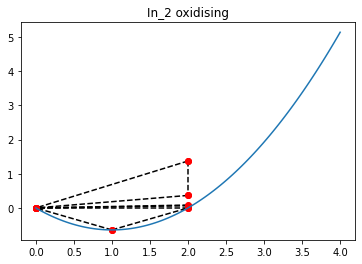

[ 6.41984749e-01 -1.28396950e+00  3.84592537e-16]
Sn2_ox
{4.0: (-2.1118337116666672, None), 5.333: (-1.1902154681818178, None), 2.8: (-1.6239665812500013, None), 2.667: (-1.4847793421428575, None), 3.0: (-1.6564513715000002, None), 2.4: (-1.7689397277272736, None)} -1.6373192899999998


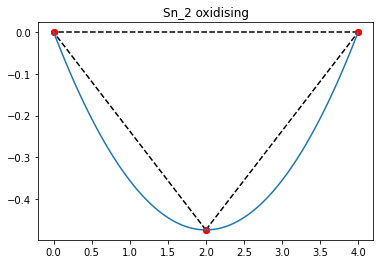

[ 1.18628605e-01 -4.74514422e-01  2.56395025e-16]
Sb2_ox
{2: (-0.9180663622916666, None), 4.0: (-1.8361327245833332, None), 5.0: (-1.746537438571428, None), 4.077: (-1.7562508735443032, None), 9.333: (-0.7220258020588239, None), 3.0: (-1.7505081320000002, None), 6.0: (-1.3299966474999998, None), 4.333: (-1.7800679181578942, None), 4.667: (-1.6950011810000003, None), 5.6: (-1.484265018157895, None), 4.5: (-1.5627934211538466, None), 8.0: (-0.5656004555, None), 7.0: (-0.9105243799999998, None), 5.333: (-1.6141966156060594, None)} -0.9180663622916666


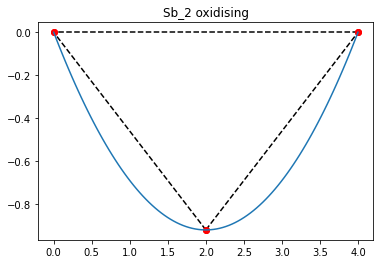

[ 2.29516591e-01 -9.18066362e-01  7.69185075e-16]
Te2_ox
{6.0: (-1.34014721375, None), 12.0: (-0.4401436508928577, None), 4.0: (-1.4933416687499996, None), 8.0: (-0.6346576670000001, None), 4.5: (-1.4508621007692306, None), 5.0: (-1.416410942142857, None)} -0.2967256174999998


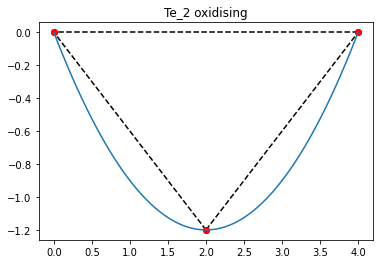

[ 2.99154013e-01 -1.19661605e+00  5.12790050e-16]
I2_ox
{2: (-0.4530039927857143, None), 5.333: (-0.6210579902272728, None), 6.0: (-0.6078064149999993, None), 4.0: (-0.6951155795833335, None), 5.0: (-0.7550066546428572, None)} -0.4530039927857143


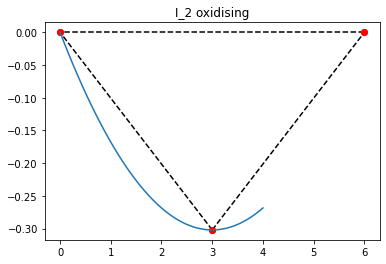

[ 3.35558513e-02 -2.01335108e-01  2.56395025e-16]
Hf2_ox
{2: (-2.0092265654166663, None), 4.0: (-4.018453130833333, None)} -2.0092265654166663


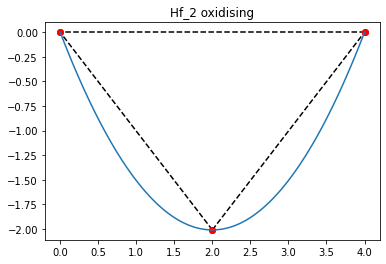

[ 5.02306641e-01 -2.00922657e+00  1.53837015e-15]
Ta2_ox
{5.0: (-3.3394399635714294, None), 6.0: (-2.773167433125, None), 3.0: (-2.597384415999999, None), 20.0: (-1.226873802727273, None), 5.333: (-3.1558381997727283, None), 7.0: (-2.1040779216666676, None), 4.0: (-3.0563588270833315, None)} -1.22945439


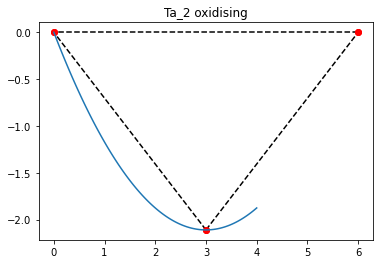

[ 2.34442842e-01 -1.40665705e+00  1.02558010e-15]
W2_ox
{2: (-1.4556090408333326, None), 6.667: (-1.8374891892307685, None), 4.0: (-1.9415572149999998, None), 6.0: (-2.183413561249999, None), 5.333: (-2.137938477727272, None), 7.0: (-1.4874519705555567, None), 10.0: (-1.4336169125000002, None), 5.444: (-2.151001807164177, None), 2.889: (-0.9532264249999995, None), 4.5: (-1.9204462630769235, None), 5.0: (-1.8945053635714286, None), 5.25: (-2.1342536723275862, None), 5.6: (-1.5575449360526314, None), 5.529: (-1.6491525585937497, None), 5.8: (-2.1644863392307685, None), 3.0: (-0.9583725439999996, None), 2.8: (-0.9263005275000005, None), 4.667: (-1.9940342265000002, None), 5.84: (-2.169087442244898, None), 8.0: (-1.1668297110000003, None)} -1.4556090408333326


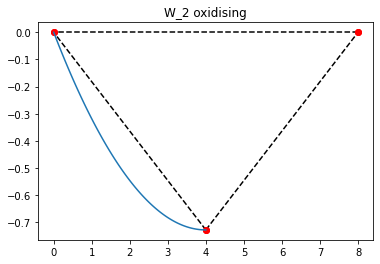

[ 4.54877825e-02 -3.63902260e-01  5.12790050e-16]
Re2_ox
{2: (-1.422571009166667, None), 6.0: (-2.1338565137500005, None), 4.0: (-1.8950494924999985, None), 5.333: (-1.8798034131818182, None), 7.0: (-2.025063832638888, None), 10.0: (-1.061157823333334, None), 6.667: (-1.4761708019230761, None)} -1.422571009166667


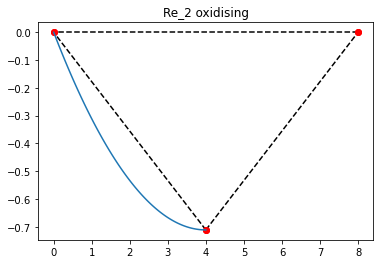

[ 4.44553440e-02 -3.55642752e-01  2.56395025e-16]
Os2_ox
{2: (-1.1450680822499997, None), 4.0: (-1.342046629999999, None), 8.0: (-1.5267574429999995, None)} -1.1450680822499997


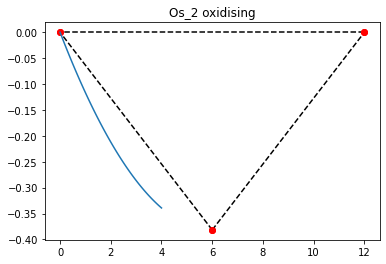

[ 1.06024822e-02 -1.27229787e-01  3.84592537e-16]
Ir2_ox
{2: (-0.6297673825, None), 6.0: (-0.9806692612500001, None), 4.0: (-1.259534765, None)} -0.6297673825


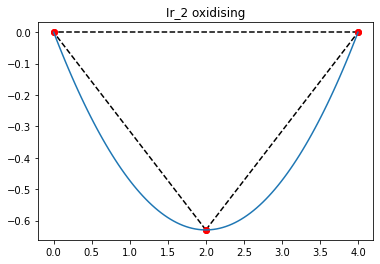

[ 1.57441846e-01 -6.29767382e-01  5.12790050e-16]
Pt2_ox
{12.0: (-0.5890866678571428, None), 4.0: (-0.9253136283333327, None), 2.667: (-0.8257142857142858, None), 6.0: (-0.6066289887499998, None)} -0.5834008600000001


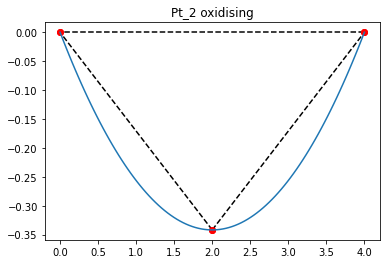

[ 8.54781921e-02 -3.41912768e-01  3.20493781e-16]
Au2_ox
{2: (-0.15219418566666681, None), 3.0: (-0.4565825570000005, None)} -0.15219418566666681


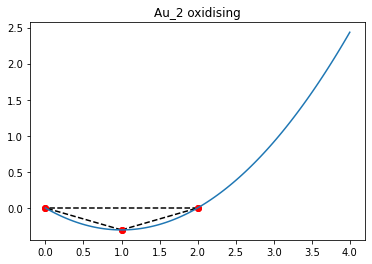

[ 3.04388371e-01 -6.08776743e-01  3.20493781e-16]
Hg2_ox
{4.0: (-0.4154045608333326, None)} -0.6370594937500001
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Tl2_ox
{3.0: (-1.1031272314999998, None)} -0.43597361499999987


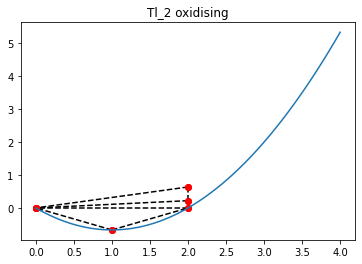

[ 6.67153616e-01 -1.33430723e+00  3.84592537e-16]
Pb2_ox
{3.0: (-1.3921388914999993, None), 2.667: (-1.445836716785714, None), 4.0: (-1.2983015083333334, None), 4.571: (-0.918967695217391, None), 3.333: (-1.3205758828125, None)} -1.4680857445312494


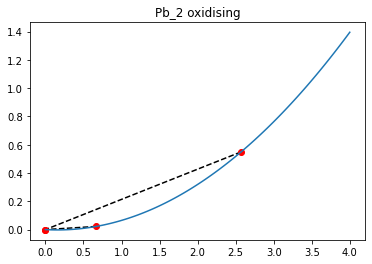

[ 9.46557993e-02 -2.97785549e-02 -2.80432058e-17]
Bi2_ox
{4.0: (-1.4596107733333332, None), 3.0: (-1.6419509899999998, None), 2.5: (-1.3705073783333344, None), 5.0: (-1.1048817435714282, None), 3.5: (-1.5692198868181815, None), 3.333: (-1.5325150268749999, None), 3.125: (-1.5730462600000004, None), 3.158: (-1.5676038183673475, None), 4.5: (-1.1281416711538461, None), 3.077: (-1.5967054972727266, None), 3.04: (-1.5938509382539676, None), 4.667: (-1.1708430580000009, None)} -0.8834113649999996


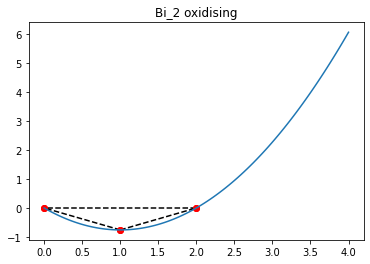

[ 7.58539625e-01 -1.51707925e+00  6.40987562e-16]
La2_ox
{4.0: (-3.0885479750000004, None), 3.0: (-3.872900711249999, None), 6.0: (-2.327208443749999, None)} -3.2033101475


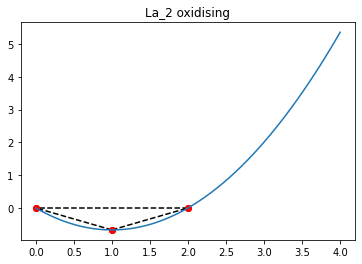

[ 6.69590564e-01 -1.33918113e+00  5.12790050e-16]
Ce2_ox
{3.375: (-3.88974239488372, None), 3.429: (-3.9176818328947354, None), 6.0: (-2.4336232762499996, None), 3.0: (-3.7685721692500005, None), 4.0: (-3.926622528333333, None), 3.6: (-3.9414715867857137, None), 3.636: (-3.9398167995161293, None), 3.692: (-3.9333783812162157, None), 3.765: (-3.934809990918367, None)} -3.233142352499999


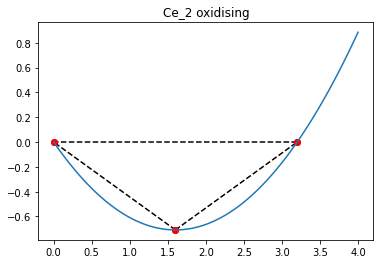

[ 2.76691107e-01 -8.85411543e-01 -1.28197512e-16]
Nd2_ox
{4.0: (-3.3062987083333337, None), 3.0: (-3.7803256334999986, None), 6.0: (-2.3934333387500004, None), 5.0: (-2.8371483528571435, None)} -3.0723149650000003


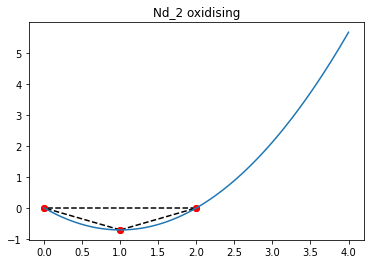

[ 7.08010668e-01 -1.41602134e+00  2.56395025e-16]
Pr2_ox
{4.0: (-3.024317191666667, None), 3.667: (-3.2180700727941174, None), 3.429: (-3.4043555749999994, None), 3.556: (-3.311919917, None), 3.0: (-3.73387589775, None), 6.0: (-1.9404715562499995, None), 3.636: (-3.2632359953225807, None), 3.6: (-3.3640411762499993, None)} -3.0452805775000007


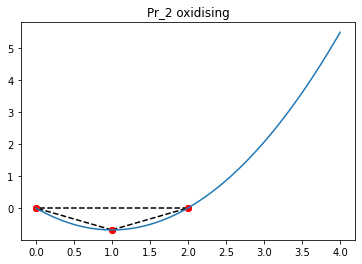

[ 6.88595320e-01 -1.37719064e+00  5.12790050e-16]
Sm2_ox
{4.0: (-3.0611810661111103, None), 6.0: (-1.9847407920833327, None), 3.0: (-3.861090533583333, None)} -3.106597456666667


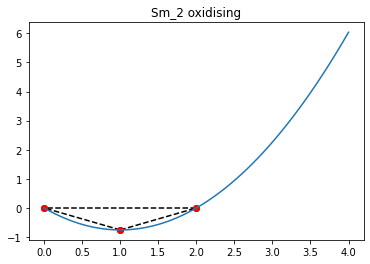

[ 7.54493077e-01 -1.50898615e+00  5.12790050e-16]
Eu2_ox
{4.0: (-2.4895677899999993, None), 3.0: (-3.1691670297499996, None), 2.667: (-3.216232667142857, None), 6.0: (-1.7015827825, None)} -3.1200716025000004


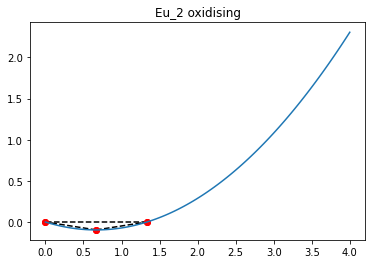

[ 2.16146195e-01 -2.88339024e-01  6.40987562e-17]
Gd2_ox
{3.0: (-3.89417473375, None), 4.0: (-3.0972412950000003, None), 6.0: (-1.7648668062499988, None)} -3.0340646700000002


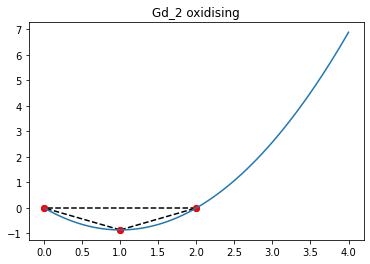

[ 8.60110064e-01 -1.72022013e+00  5.12790050e-16]
Tb2_ox
{2: (-1.3274515102499997, None), 3.636: (-3.454791365806452, None), 3.0: (-3.9823545307499995, None), 4.0: (-3.186477536666666, None), 3.429: (-3.609428142631578, None), 3.25: (-3.716755370952381, None), 3.6: (-3.467489917142857, None), 3.667: (-3.387980654117648, None), 6.0: (-2.0443497949999996, None)} -1.3274515102499997


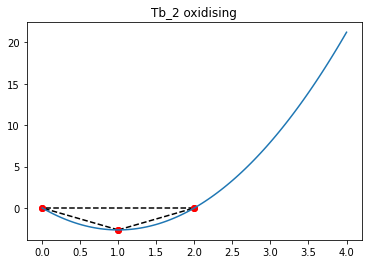

[ 2.65490302e+00 -5.30980604e+00  3.07674030e-15]
Dy2_ox
{2: (-1.3361526193333333, None), 3.0: (-4.008457858, None), 4.0: (-3.1666978083333333, None), 6.0: (-1.9951220799999998, None)} -1.3361526193333333


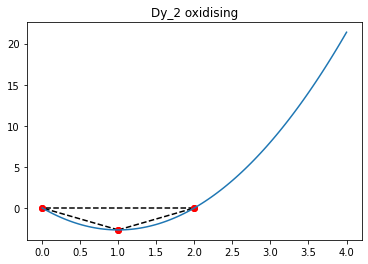

[ 2.67230524e+00 -5.34461048e+00  2.05116020e-15]
Ho2_ox
{3.0: (-4.032430118999999, None), 6.0: (-2.0650045749999997, None), 4.0: (-3.1822844783333335, None)} -3.1233894025


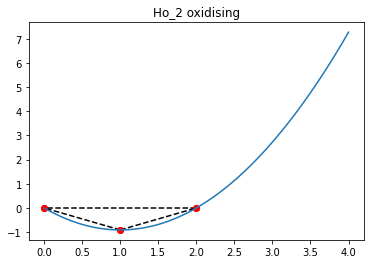

[ 9.09040716e-01 -1.81808143e+00  5.12790050e-16]
Er2_ox
{3.0: (-4.055964048249999, None), 6.0: (-2.0756603474999995, None), 4.0: (-3.19846809, None)} -3.1266739049999996


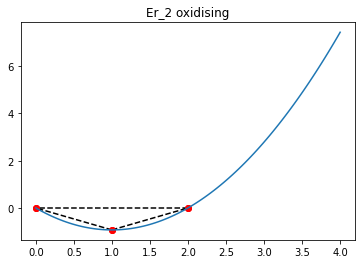

[ 9.29290143e-01 -1.85858029e+00  7.69185075e-16]
Tm2_ox
{2: (-1.3639397541944442, None), 3.0: (-4.091819262583333, None), 6.0: (-2.0950142308333337, None), 4.0: (-3.225622057777777, None)} -1.3639397541944442


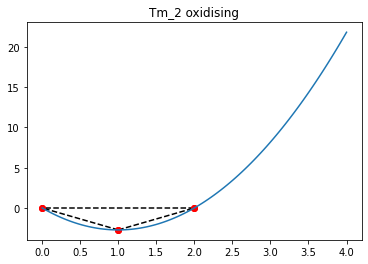

[ 2.72787951e+00 -5.45575902e+00  3.07674030e-15]
Yb2_ox
{4.0: (-2.5877955372222226, None), 6.0: (-1.3731809454166664, None), 4.667: (-1.5793164060000011, None), 3.0: (-2.698201496416666, None), 2.667: (-2.9713159167857146, None)} -3.6283261983333333


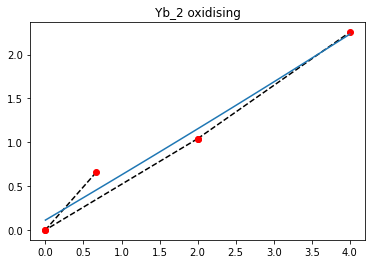

[0.00490275 0.51050194 0.11223342]
Lu2_ox
{2: (-1.374284982416666, None), 3.0: (-4.122854947249999, None), 6.0: (-2.3259364025, None), 4.0: (-3.24253671, None)} -1.374284982416666


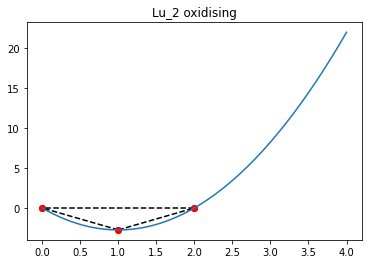

[ 2.74856996e+00 -5.49713993e+00  1.53837015e-15]
Si2_red
{1.0: (-0.8385178299999999, None), 0.667: (-0.7829878249999989, None)} -2.047090918333333
Al2_red
{1.105: (-1.8528613972881365, None), 0.75: (-1.3891308750000007, None), 1.0: (-1.7194461427777783, None)} -1.5510961400000003


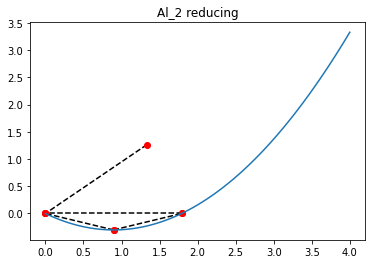

Ti2_red
{0.667: (-1.5697335962499994, None), 1.0: (-2.0351443699999994, None), 1.5: (-2.434381775714286, None), 1.333: (-2.352037862, None), 0.333: (-0.9167805728571414, None), 1.778: (-2.590827079117646, None)} -2.9071563699999983


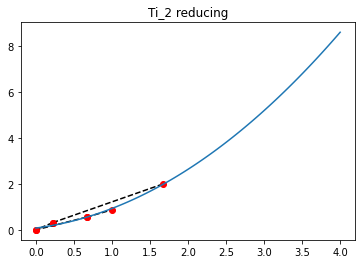

V2_red
{0.857: (-0.43666697499999924, None), 1.143: (-0.8881518818181812, None), 0.375: (0.7281016226315804, None), 0.25: (0.9098015111111126, None), 1.8: (-1.78844788, None)} -2.0900432124999995
Cr2_red
{1.0: (0.007758293333334082, None), 0.667: (0.08262339625000031, None)} -1.9660694825
Mn2_red
{} -1.978353909827586
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016865783  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Mn  odd.


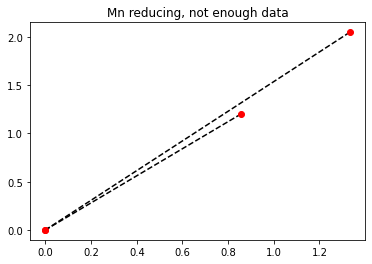

Fe2_red
{0.667: (0.7701602262500007, None)} -1.4808619749999998
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Co2_red
{} -1.2833611112500005
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016916204  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Co  odd.


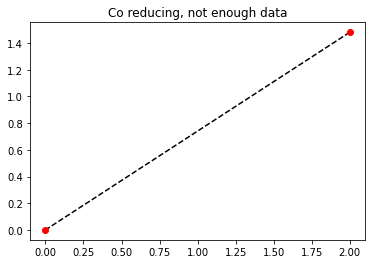

Ni2_red
{0.5: (1.018611686, None), 1.5: (-0.6123868157142862, None), 1.6: (-0.7310815366666662, None)} -1.2172232425000002


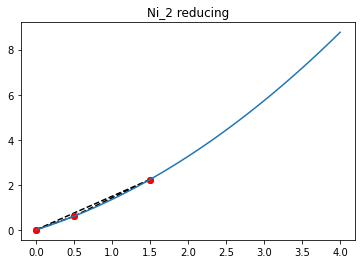

Cu2_red
{0.25: (-0.09701978444444423, None), 1.75: (-0.8289664273333333, None), 1.5: (-0.803437088571429, None), 0.031: (0.002391742000000174, None), 1.333: (-0.6026431480000004, None), 1.0: (-0.6438123283333331, None)} -0.9417754449999997
Nb2_red
{} -2.2847799366666672
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016916204  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Nb  odd.


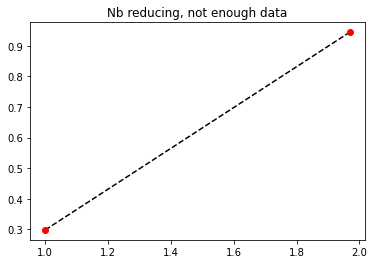

Mo2_red
{2: (-1.0078671929166665, None), 1.0: (1.447783013333334, None)} -1.0078671929166665
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016933011  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 2.5  Error-roundoff 2.1e-15  _one-merge 1e-14
  _near-inside 5.2e-14  Visible-distance 4.2e-15  U-max-coplanar 4.2e-15
  Width-outside 8.4e-15  _wide-facet 2.5e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1   2.5
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.1e-15.  The center point, facets and distances
to the center point are as follows:

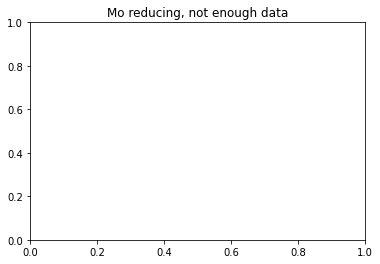

Li2_red
{1.0: (-2.060918257777777, None)} -1.7601507458333332


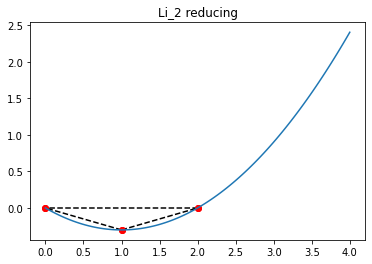

Be2_red
{} -3.1018352049999995
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016949818  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Be  odd.


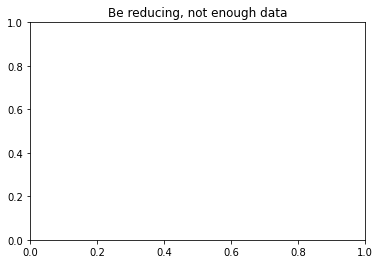

Na2_red
{1.0: (-1.4445339566666664, None), 0.333: (-0.4805849880952377, None)} -1.4227934458333331


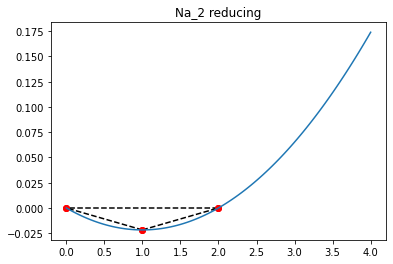

Mg2_red
{} -3.0537627616666674
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016966625  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Mg  odd.


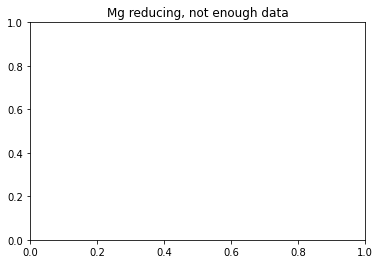

K2_red
{1.0: (-1.2471773620000002, None)} -1.4054210415000004
WARNING! Adding an end member so can perform fit, try gather more data for this element.


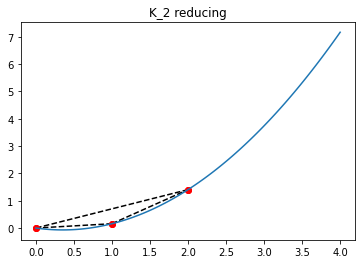

Ca2_red
{} -3.3077351674999997
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016966625  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ca  odd.


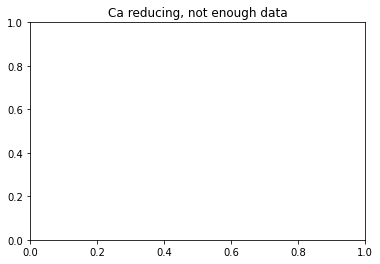

Rb2_red
{0.316: (-0.45055842056818185, None), 1.0: (-1.132488708333333, None), 0.444: (-0.6575091679545457, None), 0.375: (-0.49814936342105237, None), 0.333: (-0.5155633114285716, None)} -1.3429314262499998


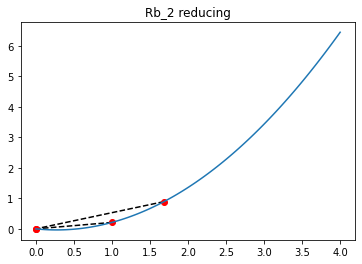

Sr2_red
{} -3.076077268333333
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016966625  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Sr  odd.


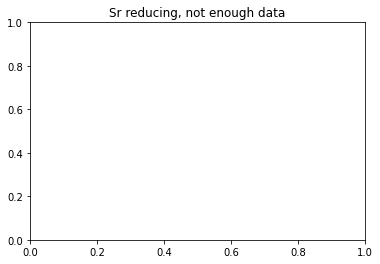

Cs2_red
{1.0: (-1.1877264619540233, None), 0.286: (-0.4596542623563216, None), 0.667: (-0.9276689359482759, None), 0.545: (-0.7913223474815267, None)} -1.3404362989655172


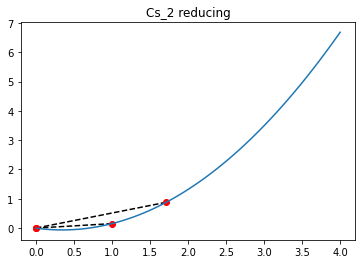

Ba2_red
{} -2.8226106800000004
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016983432  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ba  odd.


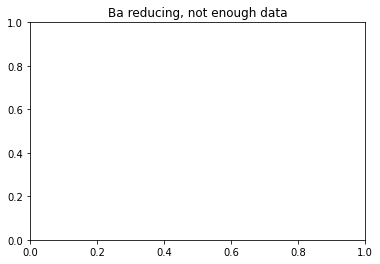

Sc2_red
{1.9: (-3.1611457430769234, None), 1.875: (-3.145588219032259, None)} -3.2394702375
Zn2_red
{} -1.7899921774999998
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016983432  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Zn  odd.


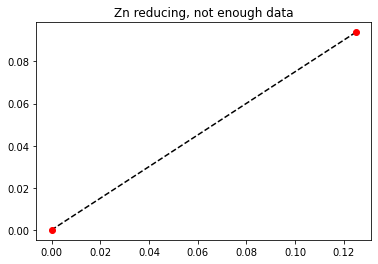

Ga2_red
{} -1.3837508599999997
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2016983432  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ga  odd.


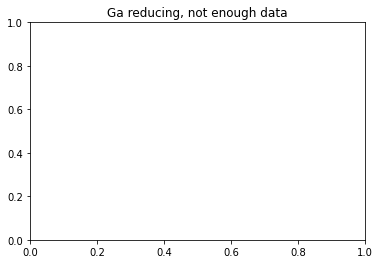

Ge2_red
{2: (-1.0387622566666663, None), 0.667: (0.0780942575000006, None)} -1.0387622566666663
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017000239  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 1.3  Error-roundoff 1.1e-15  _one-merge 5.7e-15
  _near-inside 2.9e-14  Visible-distance 2.3e-15  U-max-coplanar 2.3e-15
  Width-outside 4.6e-15  _wide-facet 1.4e-14  _maxoutside 6.8e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):   1.3   1.1
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.1e-15.  The center point, facets and distances
to the center point are as fol

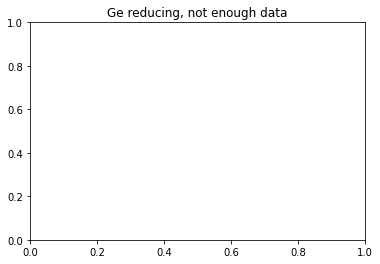

As2_red
{2: (-0.542701185, None)} -0.542701185
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017000239  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.6e-15  _one-merge 7.9e-15  _near-inside 4e-14
  Visible-distance 3.2e-15  U-max-coplanar 3.2e-15  Width-outside 6.3e-15
  _wide-facet 1.9e-14  _maxoutside 9.5e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.54
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.6e-15.  The center point, facets and dis

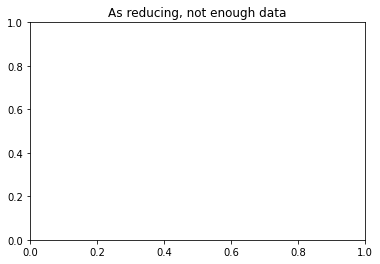

Se2_red
{2: (-0.5763906791406247, None)} -0.5763906791406247
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017000239  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.6e-15  _one-merge 8e-15  _near-inside 4e-14
  Visible-distance 3.2e-15  U-max-coplanar 3.2e-15  Width-outside 6.4e-15
  _wide-facet 1.9e-14  _maxoutside 9.6e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.58
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.6e-15.  The center point, fa

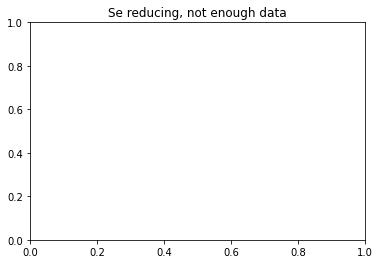

Br2_red
{2: (0.577525615, None), 1.0: (-0.06536963583333325, None)} 0.577525615


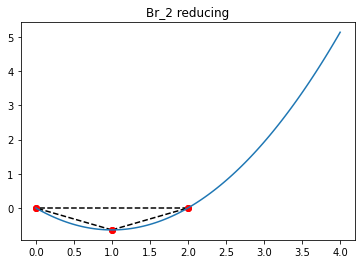

Y2_red
{} -3.094282391666666
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017000239  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Y  odd.


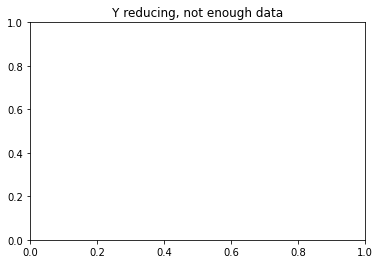

Zr2_red
{0.667: (-1.5447513525, None), 1.0: (-1.9901664400000003, None), 0.5: (-1.2398359913333334, None)} -2.55676023
Tc2_red
{2: (-0.9410055433333336, None)} -0.9410055433333336
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017017046  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.94
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is 

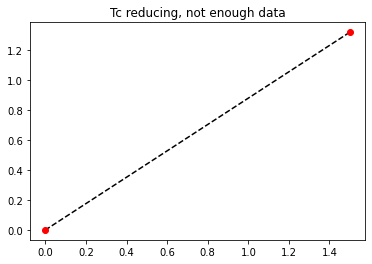

Ru2_red
{2: (-0.7281533041666669, None)} -0.7281533041666669
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017017046  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.3e-15
  _near-inside 4.2e-14  Visible-distance 3.3e-15  U-max-coplanar 3.3e-15
  Width-outside 6.7e-15  _wide-facet 2e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.73
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, fa

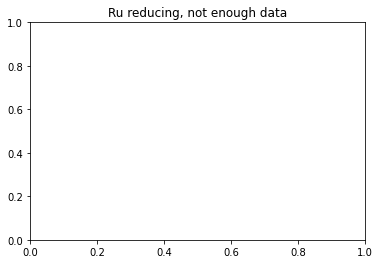

Rh2_red
{2: (-0.6130696850000003, None)} -0.6130696850000003
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017017046  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.6e-15  _one-merge 8.1e-15  _near-inside 4e-14
  Visible-distance 3.2e-15  U-max-coplanar 3.2e-15  Width-outside 6.5e-15
  _wide-facet 1.9e-14  _maxoutside 9.7e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.61
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.6e-15.  The center point, 

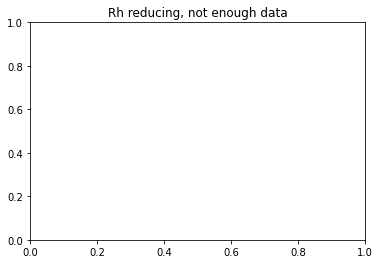

Pd2_red
{1.0: (-0.38643381666666665, None)} -0.7904939249999997
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ag2_red
{1.0: (-0.3218932738888892, None), 0.667: (-0.2238603712500002, None)} -0.44411687416666623
Cd2_red
{} -1.372035555
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017017046  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Cd  odd.


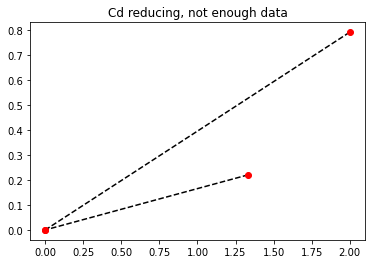

In2_red
{} -1.3538012275
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017033853  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

In  odd.


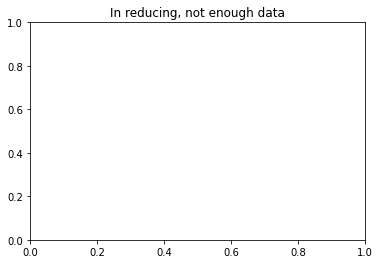

Sn2_red
{} -1.6373192899999998
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017033853  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Sn  odd.


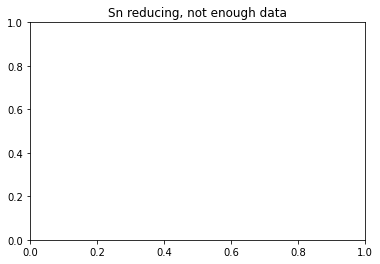

Sb2_red
{2: (-0.9180663622916666, None)} -0.9180663622916666
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017050660  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.92
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, 

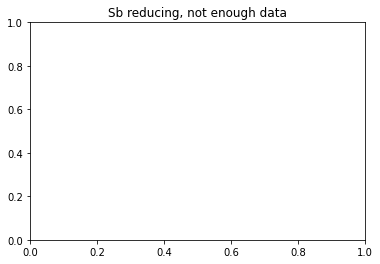

Te2_red
{} -0.2967256174999998
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017050660  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Te  odd.


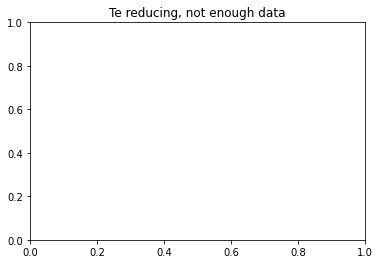

I2_red
{2: (-0.4530039927857143, None)} -0.4530039927857143
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017050660  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.5e-15  _one-merge 7.7e-15
  _near-inside 3.9e-14  Visible-distance 3.1e-15  U-max-coplanar 3.1e-15
  Width-outside 6.2e-15  _wide-facet 1.9e-14  _maxoutside 9.3e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.45
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.5e-15.  The center point,

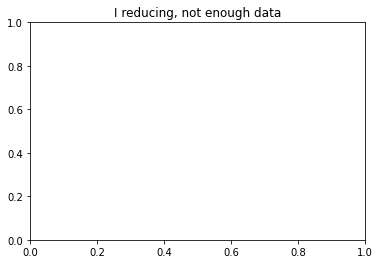

Hf2_red
{2: (-2.0092265654166663, None)} -2.0092265654166663
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017050660  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2     2
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, 

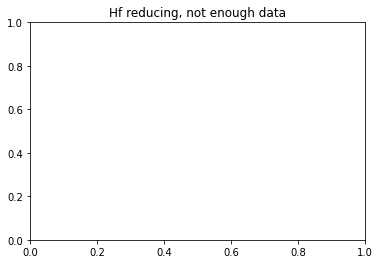

Ta2_red
{0.364: (-0.4998195746153851, None), 0.5: (-0.7141294900000001, None), 1.909: (-1.7283779502325578, None), 1.8: (-1.5579393142105253, None), 1.0: (0.21959143666666656, None)} -1.22945439


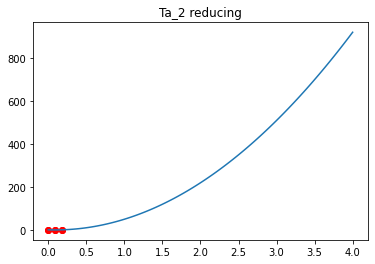

W2_red
{2: (-1.4556090408333326, None), 0.667: (2.342423497500001, None)} -1.4556090408333326
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017084274  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 3.8  Error-roundoff 3.1e-15  _one-merge 1.6e-14
  _near-inside 7.9e-14  Visible-distance 6.3e-15  U-max-coplanar 6.3e-15
  Width-outside 1.3e-14  _wide-facet 3.8e-14  _maxoutside 1.9e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):   1.3   3.8
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.1e-15.  The center point, facets and distances
to the center point are as follo

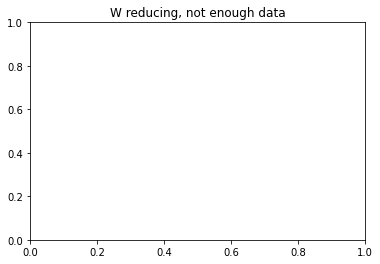

Re2_red
{2: (-1.422571009166667, None)} -1.422571009166667
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017084274  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2   1.4
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, fa

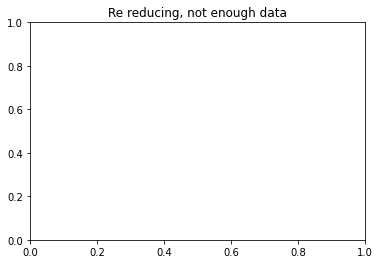

Os2_red
{2: (-1.1450680822499997, None), 0.667: (0.6572859300000009, None)} -1.1450680822499997
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017084274  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 1.8  Error-roundoff 1.5e-15  _one-merge 7.7e-15
  _near-inside 3.9e-14  Visible-distance 3.1e-15  U-max-coplanar 3.1e-15
  Width-outside 6.2e-15  _wide-facet 1.9e-14  _maxoutside 9.3e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):   1.3   1.8
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.5e-15.  The center point, facets and distances
to the center point are as fol

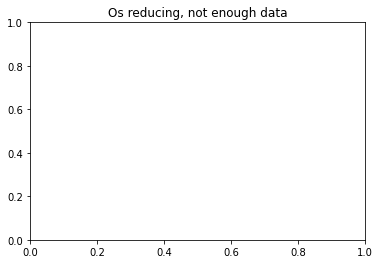

Ir2_red
{2: (-0.6297673825, None)} -0.6297673825
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017084274  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.6e-15  _one-merge 8.1e-15
  _near-inside 4.1e-14  Visible-distance 3.2e-15  U-max-coplanar 3.2e-15
  Width-outside 6.5e-15  _wide-facet 1.9e-14  _maxoutside 9.7e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.63
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.6e-15.  The center point, facets and

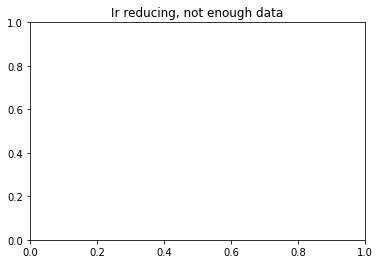

Pt2_red
{1.0: (-0.04615586166666588, None)} -0.5834008600000001
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Au2_red
{2: (-0.15219418566666681, None), 0.667: (0.19704526750000012, None)} -0.15219418566666681
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017084274  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 1.3  Error-roundoff 1.1e-15  _one-merge 5.3e-15
  _near-inside 2.6e-14  Visible-distance 2.1e-15  U-max-coplanar 2.1e-15
  Width-outside 4.2e-15  _wide-facet 1.3e-14  _maxoutside 6.3e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):   1.3  0.35
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with 

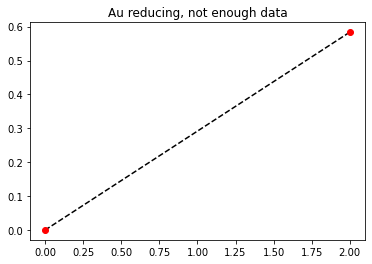

Hg2_red
{} -0.6370594937500001
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017084274  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Hg  odd.


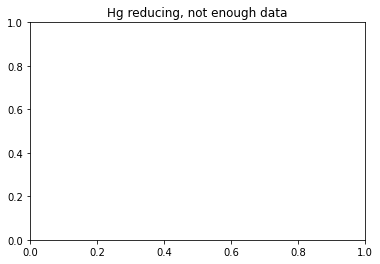

Tl2_red
{1.0: (-0.8199271266666665, None), 1.5: (-0.9372852321428575, None)} -0.43597361499999987


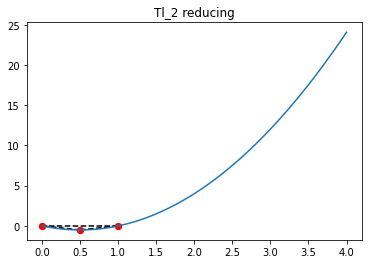

Pb2_red
{1.0: (-0.6230187866666662, None), 0.667: (0.0013737950000001775, None)} -1.4680857445312494
Bi2_red
{1.333: (-0.9692701079999996, None)} -0.8834113649999996


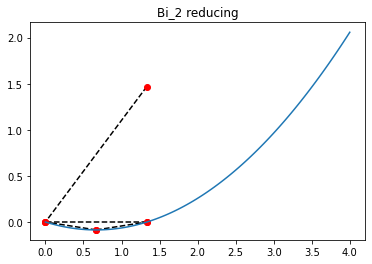

La2_red
{} -3.2033101475
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017101081  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

La  odd.


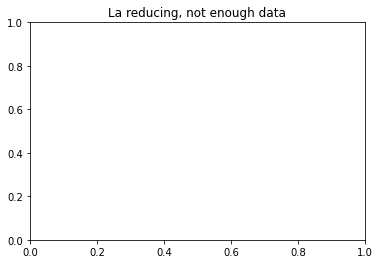

Ce2_red
{} -3.233142352499999
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ce  odd.


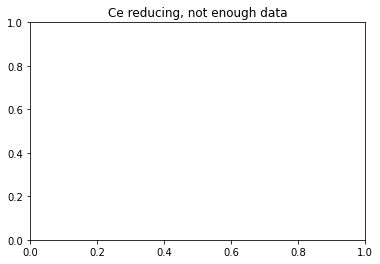

Nd2_red
{} -3.0723149650000003
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Nd  odd.


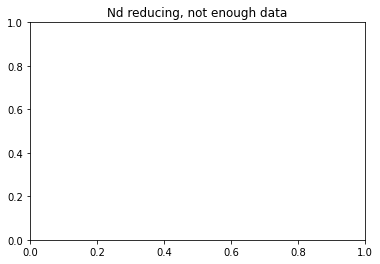

Pr2_red
{} -3.0452805775000007
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Pr  odd.


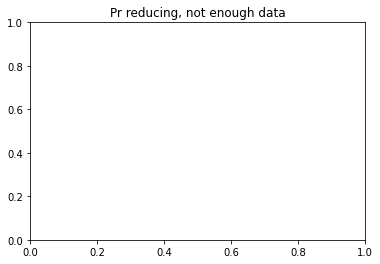

Sm2_red
{1.313: (-2.3164324476729563, None), 1.0: (-2.0739774922222223, None)} -3.106597456666667
Eu2_red
{} -3.1200716025000004
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Eu  odd.


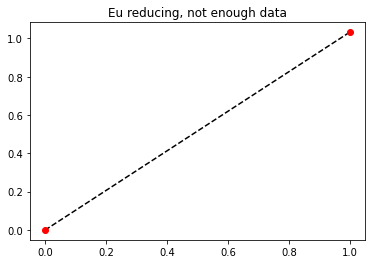

Gd2_red
{} -3.0340646700000002
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Gd  odd.


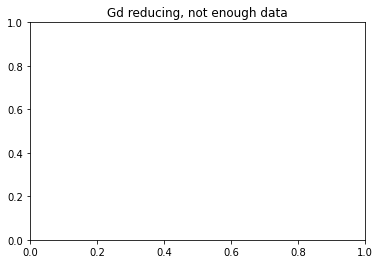

Tb2_red
{2: (-1.3274515102499997, None)} -1.3274515102499997
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2   1.3
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, 

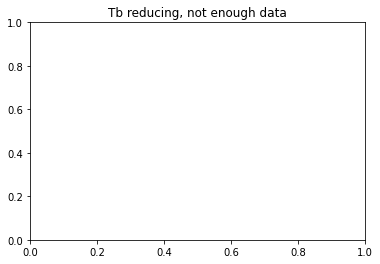

Dy2_red
{2: (-1.3361526193333333, None)} -1.3361526193333333
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017117888  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2   1.3
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, 

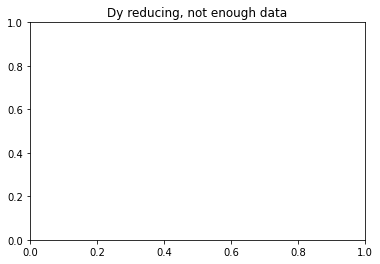

Ho2_red
{} -3.1233894025
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017134695  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ho  odd.


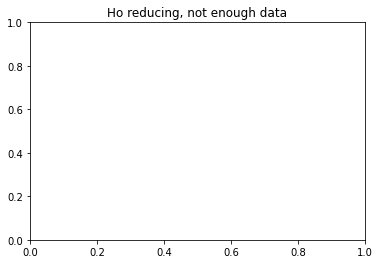

Er2_red
{} -3.1266739049999996
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017134695  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Er  odd.


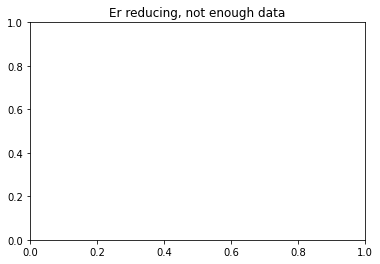

Tm2_red
{2: (-1.3639397541944442, None)} -1.3639397541944442
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017134695  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2   1.4
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, 

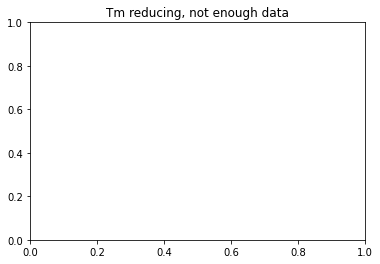

Yb2_red
{} -3.6283261983333333
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017134695  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Yb  odd.


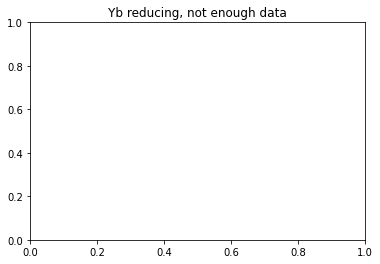

Lu2_red
{2: (-1.374284982416666, None)} -1.374284982416666
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017134695  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.7e-15  _one-merge 8.6e-15
  _near-inside 4.3e-14  Visible-distance 3.4e-15  U-max-coplanar 3.4e-15
  Width-outside 6.9e-15  _wide-facet 2.1e-14  _maxoutside 1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2   1.4
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-15.  The center point, fa

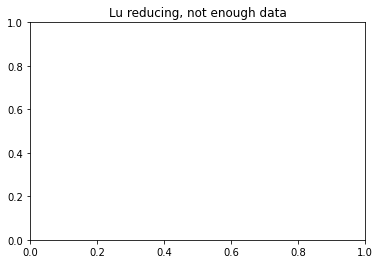

Si3_ox
{4.0: (-3.2664413149999993, None), 4.353: (-2.9183025977777772, None), 4.333: (-3.1191778257894724, None), 8.0: (-1.5783727216666654, None), 3.222: (-2.8138437830851064, None), 5.0: (-2.6021939028571426, None), 4.667: (-1.9866582439999991, None), 4.5: (-2.730264622307693, None), 4.458: (-2.8546522283870974, None)} -2.164898087


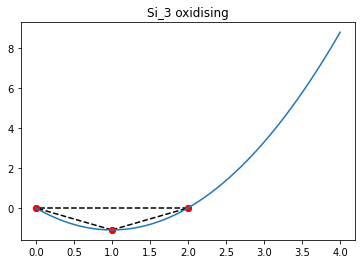

[ 1.10154323e+00 -2.20308646e+00  1.02558010e-15]
Al3_ox
{3.2: (-3.230242248076923, None), 6.0: (-1.6239397406249996, None), 4.0: (-2.669873368333333, None), 3.273: (-3.1303870698275866, None)} -3.425327611


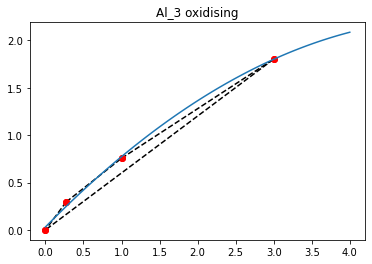

[-0.07616322  0.81819359  0.0307375 ]
Ti3_ox
{4.0: (-3.5004083808333335, None), 3.75: (-3.443114696304347, None), 7.0: (-2.372602095555556, None), 3.333: (-3.3788314575000005, None), 5.333: (-2.4398223627272726, None), 3.714: (-3.4387194579999987, None), 3.273: (-3.3480246851724123, None), 3.2: (-3.337638646153845, None), 4.667: (-2.9123895604999994, None), 3.5: (-3.4050568290909085, None), 3.778: (-3.4473459390384606, None), 3.385: (-3.3788645235714285, None), 3.667: (-3.435453412352941, None), 3.158: (-3.329586063469388, None), 3.6: (-3.4200159649999997, None), 3.25: (-3.350688390476189, None)} -3.302391907999999


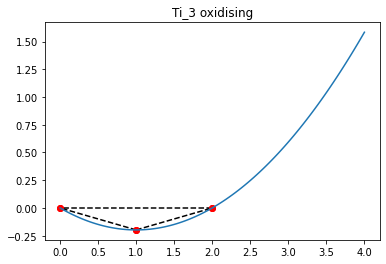

[ 1.98016473e-01 -3.96032946e-01  6.40987562e-17]
V3_ox
{5.0: (-2.2880048985714287, None), 3.6: (-2.4959239401785704, None), 4.333: (-2.391191719210527, None), 3.667: (-2.485902672941176, None), 4.0: (-2.4794067783333333, None), 6.0: (-2.0567253787499995, None), 3.778: (-2.4624043674999996, None), 3.333: (-2.5216525662500002, None), 4.889: (-2.271455647096774, None), 4.8: (-2.2982589692647055, None), 4.667: (-2.321625788, None), 3.5: (-2.490026317272727, None), 4.5: (-2.3510451603846154, None), 3.714: (-2.4586360342499987, None), 3.75: (-2.3376359419565214, None), 5.6: (-1.9032921203947377, None), 5.333: (-2.0558007111363636, None), 4.833: (-2.2826718817073157, None), 6.667: (-1.4313400207692313, None)} -2.5252870819999993


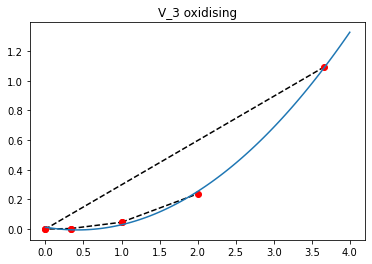

[ 0.10404092 -0.08760764  0.01264585]
Cr3_ox
{5.0: (-1.6560083814285713, None), 6.0: (-1.5096780562499994, None), 4.5: (-1.574472071923077, None), 4.0: (-2.0463415316666658, None), 5.333: (-1.64812568090909, None), 4.8: (-1.8307398995588227, None), 3.333: (-1.8854764925000003, None), 5.25: (-1.6757490275862055, None), 5.053: (-1.6798458562686571, None), 3.667: (-1.7607074897058819, None), 4.667: (-1.5873285454999992, None)} -2.3653643719999993


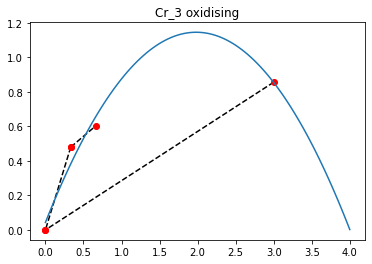

[-0.28058031  1.11200669  0.04334187]
Mn3_ox
{3.81: (-1.7949999269304697, None), 4.0: (-1.8045735507183907, None), 4.25: (-1.6370894718896556, None), 3.2: (-1.955414972175067, None), 6.0: (-1.2542958736637928, None), 4.267: (-1.63008329244314, None), 4.3: (-1.586297598144499, None), 7.0: (-0.8788899611733718, None), 3.429: (-1.86630437829401, None), 8.0: (-0.571748129931035, None)} -2.0127861137370697


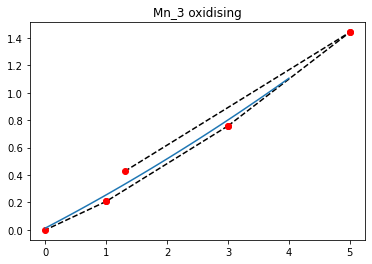

[0.01026593 0.23186837 0.01386559]
Fe3_ox
{4.0: (-1.2352142979166658, None), 3.2: (-1.4770011859615384, None), 6.5: (-0.7304429523529418, None), 3.048: (-1.495322866226414, None), 4.25: (-1.051742656599999, None), 6.0: (-0.9197123012499997, None)} -1.7061576239999994
None
Co3_ox
{4.0: (-1.0793046775, None), 3.81: (-0.9897550699180335, None), 8.0: (-0.0477397700000004, None), 3.2: (-1.1397359465384616, None), 3.429: (-1.0254213628947355, None), 3.733: (-1.0861586291860468, None)} -0.8174023645000005


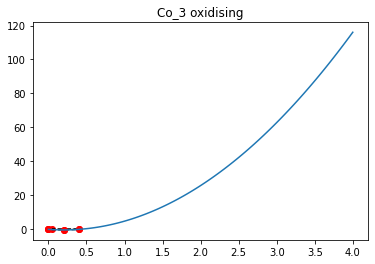

[ 8.05833955e+00 -3.22333582e+00  2.56395025e-16]
Ni3_ox
{4.0: (-0.685469113333333, None), 4.4: (-0.5221941637499999, None), 5.0: (-0.5561055121428572, None), 6.0: (0.4418155500000003, None)} -0.6389061690000003


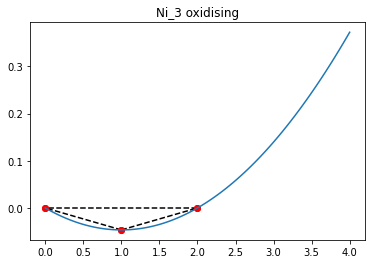

[ 4.65629443e-02 -9.31258887e-02  3.20493781e-17]
Cu3_ox
{4.0: (-0.5284182333333336, None)} -0.8315602755000003
WARNING! Adding an end member so can perform fit, try gather more data for this element.


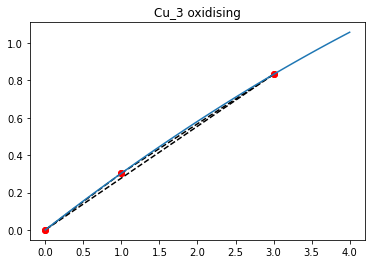

[-1.29776418e-02  3.16119684e-01  2.56395025e-16]
Nb3_ox
{5.0: (-3.0327488496938777, None), 4.0: (-2.8962547750000014, None), 4.833: (-3.0374842057317073, None), 6.0: (-2.4647783575, None), 4.5: (-2.784456805384616, None)} -2.5713432450000004


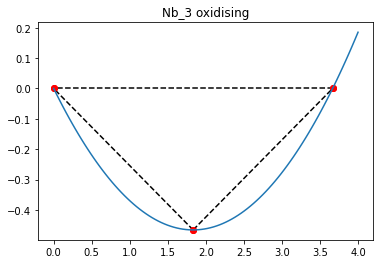

[ 1.38737012e-01 -5.08609886e-01 -1.28197512e-16]
Mo3_ox
{5.333: (-1.6921007063636357, None), 4.0: (-2.015734385833333, None), 6.0: (-1.9229110493749992, None), 4.5: (-1.8623810976923063, None), 5.0: (-1.860406987857143, None), 10.0: (-1.1847070558333335, None), 5.778: (-1.9306581831428566, None), 8.0: (-1.0676932999999995, None), 5.75: (-1.935772359274193, None), 5.5: (-1.937953538499999, None), 5.6: (-1.9219500065789474, None), 5.556: (-1.9338494598529412, None), 7.0: (-1.3700206205555554, None), 6.667: (-1.5436972284615376, None), 5.529: (-1.9361885139843744, None), 5.077: (-1.9073964991304353, None), 4.667: (-1.7659168107500012, None)} -1.4891102515000005


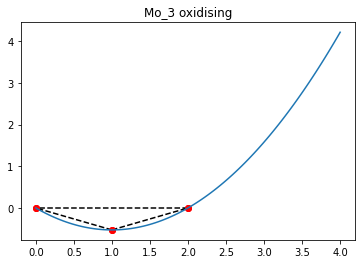

[ 5.26624134e-01 -1.05324827e+00  3.84592537e-16]
Li3_ox
{3: (-0.5888337879365076, None), 16.0: (-0.8846375340740733, None), 4.0: (-1.392210387222222, None), 6.0: (-1.138571189166666, None)} -0.5888337879365076


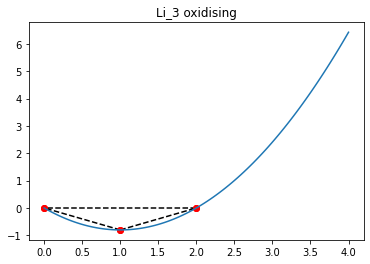

[ 8.03376599e-01 -1.60675320e+00  5.12790050e-16]
Be3_ox
{3: (-0.5169725341666666, None), 4.0: (-1.3105624366666666, None)} -0.5169725341666666


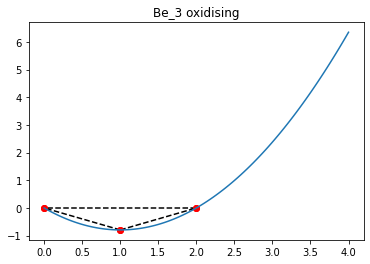

[ 7.93589902e-01 -1.58717981e+00  5.12790050e-16]
Na3_ox
{3: (-0.4127239876190475, None), 4.0: (-1.2668000216666668, None), 16.0: (-0.646523715833333, None), 9.0: (-0.8910210588636356, None), 10.0: (-0.5234980341666663, None), 6.0: (-1.1170697012499993, None)} -0.4127239876190475


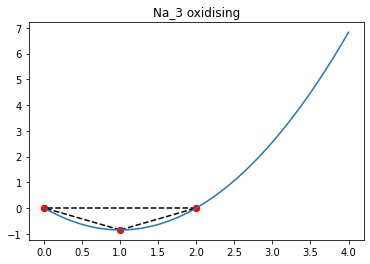

[ 8.54076034e-01 -1.70815207e+00  5.12790050e-16]
Mg3_ox
{3: (-0.5089604602777779, None), 4.0: (-2.168476221944444, None)} -0.5089604602777779


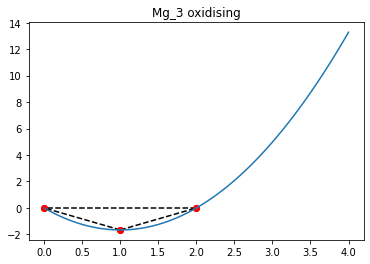

[ 1.65951576e+00 -3.31903152e+00  1.53837015e-15]
K3_ox
{3: (-0.23423684025000005, None), 4.0: (-1.3364584009999991, None), 6.0: (-1.1737919557499996, None)} -0.23423684025000005


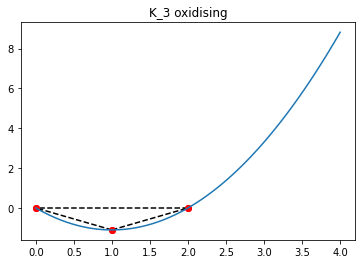

[ 1.10222156e+00 -2.20444312e+00  7.69185075e-16]
Ca3_ox
{4.0: (-2.355238631666667, None), 20.0: (-1.0284573527272722, None)} -2.39847709


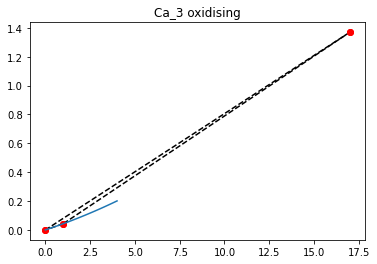

[2.33443362e-03 4.09040247e-02 9.61481343e-17]
Rb3_ox
{4.0: (-1.321567595833333, None), 6.0: (-1.1601528475, None)} -1.3381510210000003


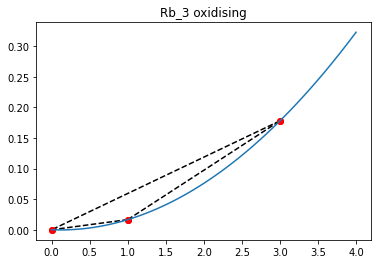

[ 2.13746497e-02 -4.79122450e-03  2.30354905e-17]
Sr3_ox
{20.0: (-1.0147847206060603, None), 12.0: (-1.2116782438095246, None), 8.0: (-0.8592437373333335, None), 4.0: (-2.3520738855555554, None)} -1.9478391786666664


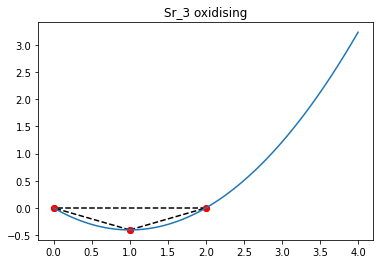

[ 4.04234707e-01 -8.08469414e-01  2.56395025e-16]
Cs3_ox
{4.0: (-1.3291547626436773, None)} -1.3426218101724139
WARNING! Adding an end member so can perform fit, try gather more data for this element.


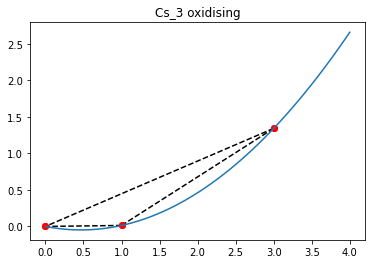

[ 2.17036778e-01 -2.03569730e-01  1.60246891e-16]
Ba3_ox
{3: (-0.4704351133333334, None), 4.0: (-2.3168347033333325, None), 20.0: (-1.0367065227272731, None), 8.0: (-1.5879292150000002, None), 12.0: (-1.34733606, None), 10.0: (-1.2500722229166663, None)} -0.4704351133333334


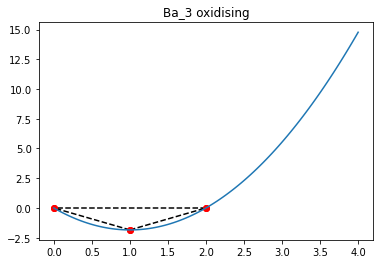

[ 1.84639959e+00 -3.69279918e+00  5.12790050e-16]
Sc3_ox
{4.0: (-3.0336421108333327, None), 6.0: (-1.785990889999999, None)} -3.9674971125000003


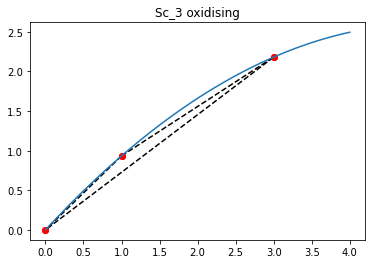

[-1.03343130e-01  1.03719813e+00  7.69185075e-16]
Zn3_ox
{3: (-0.29833202958333327, None), 4.0: (-1.2051779108333325, None)} -0.29833202958333327


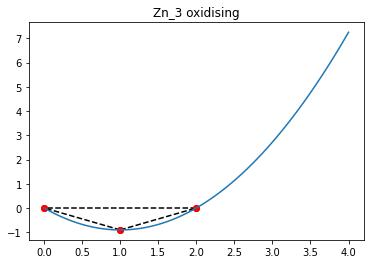

[ 9.06845881e-01 -1.81369176e+00  5.12790050e-16]
Ga3_ox
{3.333: (-1.9901455746874992, None), 4.0: (-1.5798398591666667, None), 6.0: (-0.8030734031249995, None)} -2.267768931999999


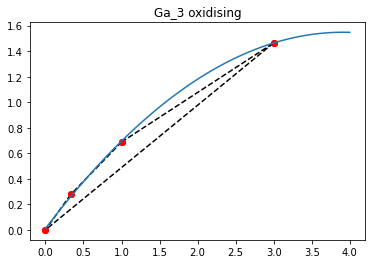

[-0.1003681   0.78576452  0.01008525]
Ge3_ox
{4.0: (-2.0775245133333327, None), 6.571: (-0.7961393696666669, None), 4.4: (-1.5926114290625009, None), 4.571: (-1.6585996252173918, None)} -1.4878800639999996


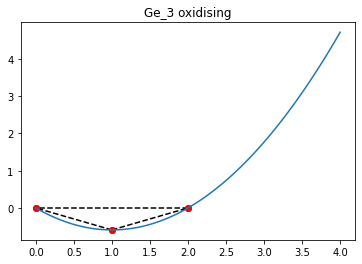

[ 5.89644449e-01 -1.17928890e+00  5.12790050e-16]
As3_ox
{5.0: (-1.55907805, None), 4.0: (-1.5870349591666673, None), 9.0: (-0.693401365454545, None), 6.0: (1.803728171875, None)} -1.628103555


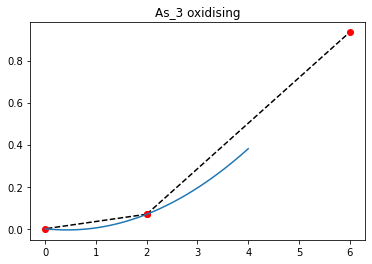

[ 3.03177364e-02 -2.61227204e-02 -6.40987562e-17]
Se3_ox
{3: (-0.28819533957031235, None), 8.0: (-0.3066393809687493, None), 4.0: (-1.1527813582812494, None), 5.0: (-1.0205518156696431, None), 6.0: (-0.8724884215234372, None)} -0.28819533957031235


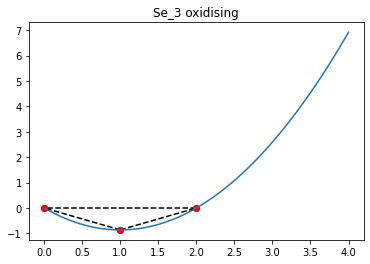

[ 8.64586019e-01 -1.72917204e+00  7.69185075e-16]
Br3_ox
{8.0: (-0.2797859224999997, None), 4.0: (-0.08008579499999985, None), 6.0: (-0.2802205137499998, None)} -0.1974797374999998


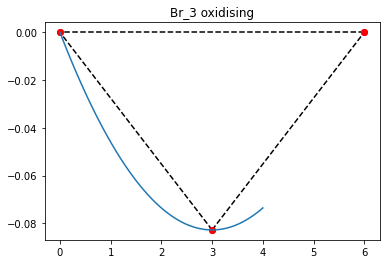

[ 9.19341958e-03 -5.51605175e-02  8.01234453e-17]
Y3_ox
{6.0: (-2.019662025833333, None), 4.0: (-3.1255152277777776, None)} -3.969855263083333


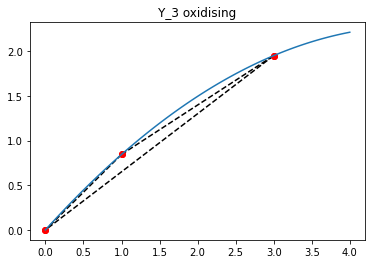

[-9.71378114e-02  9.41477847e-01  5.12790050e-16]
Zr3_ox
{3: (-0.953063671875, None), 4.0: (-3.8122546875, None), 4.211: (-3.565631532203389, None), 3.63: (-3.576835425394737, None), 3.667: (-3.621723770588237, None)} -0.953063671875


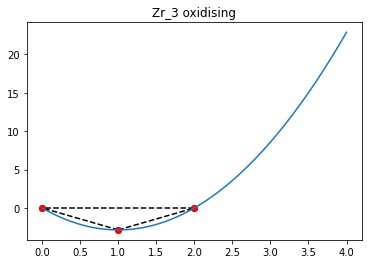

[ 2.85919102e+00 -5.71838203e+00  3.07674030e-15]
Tc3_ox
{3: (-0.4705027716666668, None), 4.0: (-1.8820110866666673, None), 7.0: (-1.7976895825, None)} -0.4705027716666668


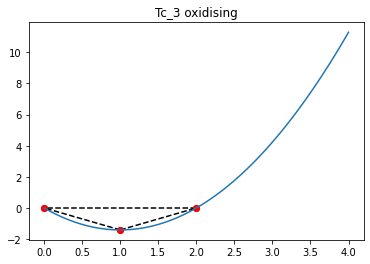

[ 1.41150832e+00 -2.82301663e+00  1.28197512e-15]
Ru3_ox
{3: (-0.36407665208333345, None), 8.0: (-1.1803451717500002, None), 4.0: (-1.4563066083333338, None)} -0.36407665208333345


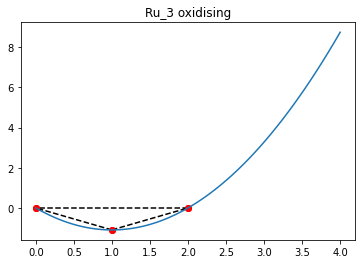

[ 1.09222996e+00 -2.18445991e+00  7.69185075e-16]
Rh3_ox
{4.0: (-1.2261393700000005, None)} -1.0805171704999998


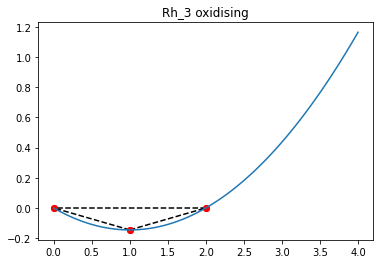

[ 1.45622200e-01 -2.91244399e-01  9.61481343e-17]
Pd3_ox
{3: (-0.13174898749999994, None), 4.0: (-0.7272990283333327, None)} -0.13174898749999994


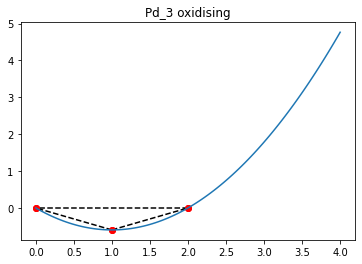

[ 5.95550041e-01 -1.19110008e+00  2.56395025e-16]
Ag3_ox
{4.0: (-0.3590486919444443, None)} -0.3581646773333339


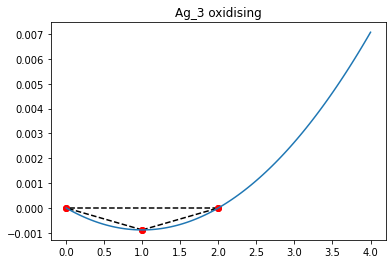

[ 8.84014611e-04 -1.76802922e-03  5.00771533e-19]
Cd3_ox
{3: (-0.2286725925, None), 4.0: (-1.0057692858333327, None)} -0.2286725925


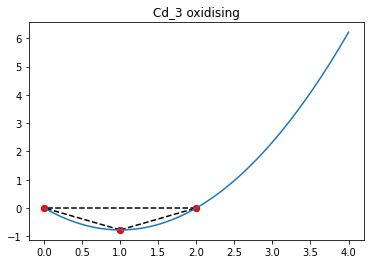

[ 7.77096693e-01 -1.55419339e+00  7.69185075e-16]
In3_ox
{6.0: (-1.0402070812499993, None), 4.0: (-1.4326180766666659, None)} -1.9957859764999988


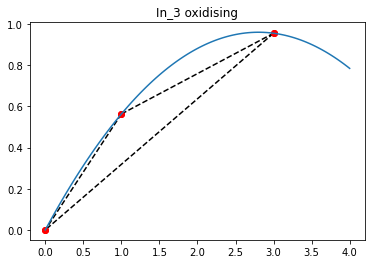

[-1.22320801e-01  6.85488701e-01  5.12790050e-16]
Sn3_ox
{4.0: (-2.1118337116666672, None), 5.333: (-1.1902154681818178, None)} -1.6564513715000002


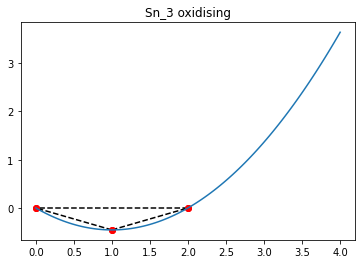

[ 4.5538234e-01 -9.1076468e-01  5.1279005e-16]
Sb3_ox
{4.0: (-1.8361327245833332, None), 5.0: (-1.746537438571428, None), 4.077: (-1.7562508735443032, None), 9.333: (-0.7220258020588239, None), 6.0: (-1.3299966474999998, None), 4.333: (-1.7800679181578942, None), 4.667: (-1.6950011810000003, None), 5.6: (-1.484265018157895, None), 4.5: (-1.5627934211538466, None), 8.0: (-0.5656004555, None), 7.0: (-0.9105243799999998, None), 5.333: (-1.6141966156060594, None)} -1.7505081320000002


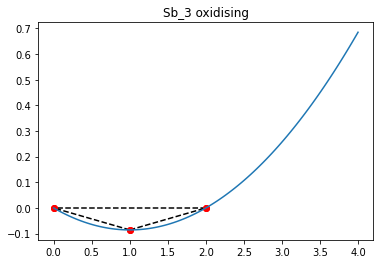

[ 8.56245926e-02 -1.71249185e-01  6.40987562e-17]
Te3_ox
{3: (-0.3733354171874999, None), 6.0: (-1.34014721375, None), 12.0: (-0.4401436508928577, None), 4.0: (-1.4933416687499996, None), 8.0: (-0.6346576670000001, None), 4.5: (-1.4508621007692306, None), 5.0: (-1.416410942142857, None)} -0.3733354171874999


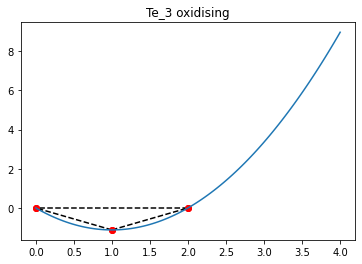

[ 1.12000625e+00 -2.24001250e+00  1.02558010e-15]
I3_ox
{3: (-0.3020026618571429, None), 5.333: (-0.6210579902272728, None), 6.0: (-0.6078064149999993, None), 4.0: (-0.6951155795833335, None), 5.0: (-0.7550066546428572, None)} -0.3020026618571429


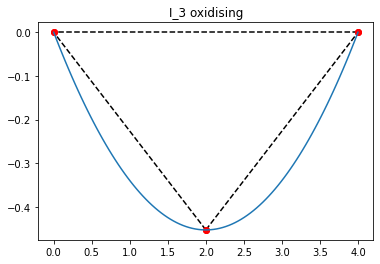

[ 1.13250998e-01 -4.53003993e-01  3.84592537e-16]
Hf3_ox
{3: (-1.0046132827083332, None), 4.0: (-4.018453130833333, None)} -1.0046132827083332


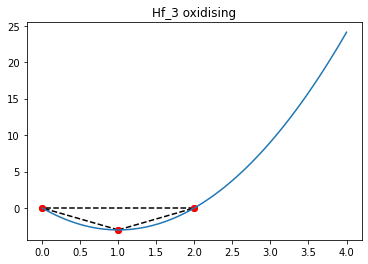

[ 3.01383985e+00 -6.02767970e+00  2.05116020e-15]
Ta3_ox
{5.0: (-3.3394399635714294, None), 6.0: (-2.773167433125, None), 20.0: (-1.226873802727273, None), 5.333: (-3.1558381997727283, None), 7.0: (-2.1040779216666676, None), 4.0: (-3.0563588270833315, None)} -2.597384415999999


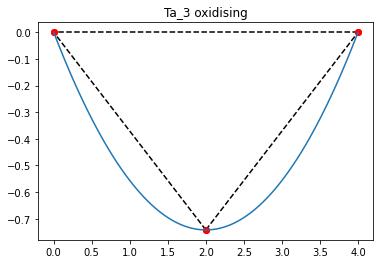

[ 1.85513887e-01 -7.42055548e-01  5.12790050e-16]
W3_ox
{6.667: (-1.8374891892307685, None), 4.0: (-1.9415572149999998, None), 6.0: (-2.183413561249999, None), 5.333: (-2.137938477727272, None), 7.0: (-1.4874519705555567, None), 10.0: (-1.4336169125000002, None), 5.444: (-2.151001807164177, None), 4.5: (-1.9204462630769235, None), 5.0: (-1.8945053635714286, None), 5.25: (-2.1342536723275862, None), 5.6: (-1.5575449360526314, None), 5.529: (-1.6491525585937497, None), 5.8: (-2.1644863392307685, None), 4.667: (-1.9940342265000002, None), 5.84: (-2.169087442244898, None), 8.0: (-1.1668297110000003, None)} -0.9583725439999996


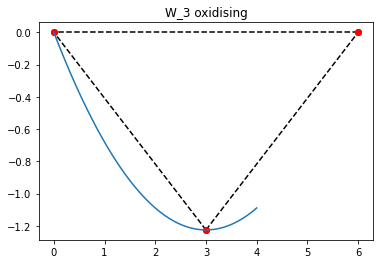

[ 1.36115669e-01 -8.16694011e-01  7.69185075e-16]
Re3_ox
{3: (-1.0669282568750003, None), 6.0: (-2.1338565137500005, None), 4.0: (-1.8950494924999985, None), 5.333: (-1.8798034131818182, None), 7.0: (-2.025063832638888, None), 10.0: (-1.061157823333334, None), 6.667: (-1.4761708019230761, None)} -1.0669282568750003


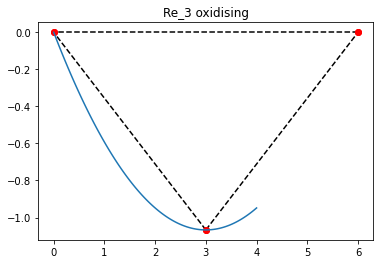

[ 1.18547584e-01 -7.11285505e-01  2.56395025e-16]
Os3_ox
{3: (-0.9542234018749997, None), 4.0: (-1.342046629999999, None), 8.0: (-1.5267574429999995, None)} -0.9542234018749997


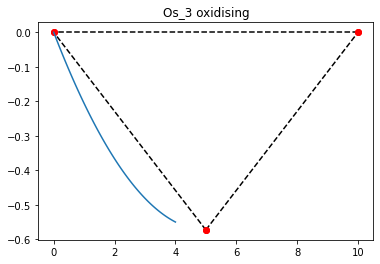

[ 2.29013616e-02 -2.29013616e-01  5.12790050e-16]
Ir3_ox
{3: (-0.31488369125, None), 6.0: (-0.9806692612500001, None), 4.0: (-1.259534765, None)} -0.31488369125


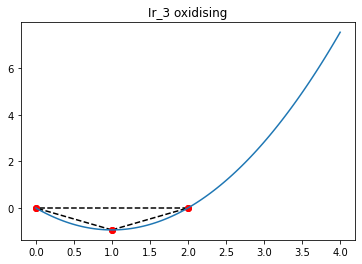

[ 9.44651074e-01 -1.88930215e+00  5.12790050e-16]
Pt3_ox
{3: (-0.2313284070833332, None), 12.0: (-0.5890866678571428, None), 4.0: (-0.9253136283333327, None), 6.0: (-0.6066289887499998, None)} -0.2313284070833332


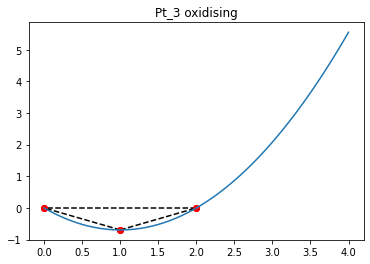

[ 6.93985221e-01 -1.38797044e+00  2.56395025e-16]
Au3_ox
{} -0.4565825570000005
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017655712  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Au  odd.


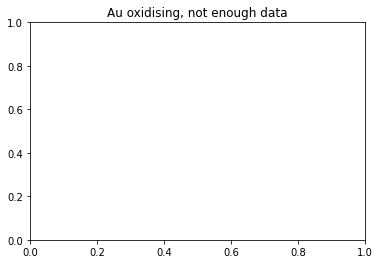

Hg3_ox
{3: (-0.10617658229166668, None), 4.0: (-0.4154045608333326, None)} -0.10617658229166668


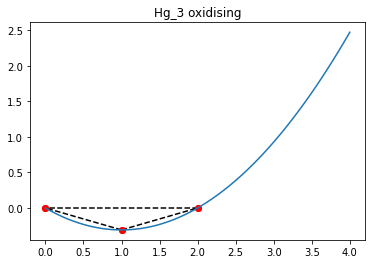

[ 3.09227979e-01 -6.18455957e-01  1.92296269e-16]
Tl3_ox
{} -1.1031272314999998
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2017672519  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tl  odd.


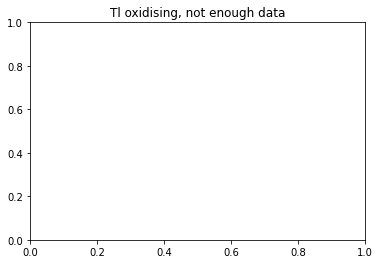

Pb3_ox
{4.0: (-1.2983015083333334, None), 4.571: (-0.918967695217391, None), 3.333: (-1.3205758828125, None)} -1.3921388914999993


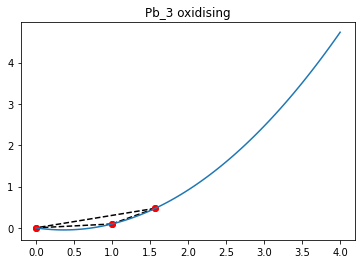

[ 3.63141336e-01 -2.69303953e-01  6.40987562e-17]
Bi3_ox
{4.0: (-1.4596107733333332, None), 5.0: (-1.1048817435714282, None), 3.5: (-1.5692198868181815, None), 3.333: (-1.5325150268749999, None), 3.125: (-1.5730462600000004, None), 3.158: (-1.5676038183673475, None), 4.5: (-1.1281416711538461, None), 3.077: (-1.5967054972727266, None), 3.04: (-1.5938509382539676, None), 4.667: (-1.1708430580000009, None)} -1.6419509899999998


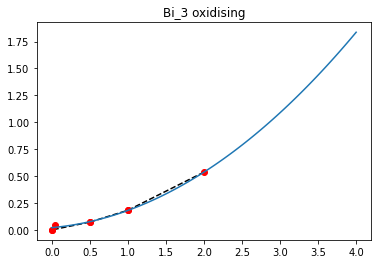

[0.09796192 0.06199897 0.02126149]
La3_ox
{4.0: (-3.0885479750000004, None), 6.0: (-2.327208443749999, None)} -3.872900711249999


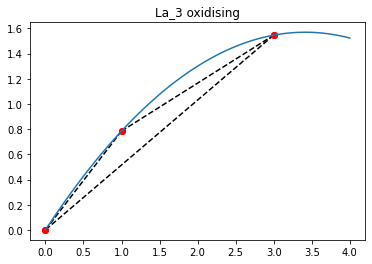

[-1.34560990e-01  9.18913726e-01  7.69185075e-16]
Ce3_ox
{3.375: (-3.88974239488372, None), 3.429: (-3.9176818328947354, None), 6.0: (-2.4336232762499996, None), 4.0: (-3.926622528333333, None), 3.6: (-3.9414715867857137, None), 3.636: (-3.9398167995161293, None), 3.692: (-3.9333783812162157, None), 3.765: (-3.934809990918367, None)} -3.7685721692500005


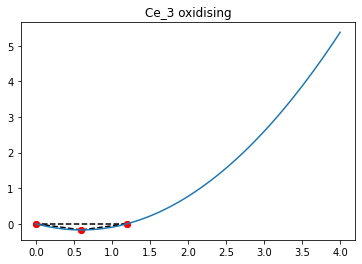

[ 4.80276160e-01 -5.76331392e-01  1.28197512e-16]
Nd3_ox
{4.0: (-3.3062987083333337, None), 6.0: (-2.3934333387500004, None), 5.0: (-2.8371483528571435, None)} -3.7803256334999986


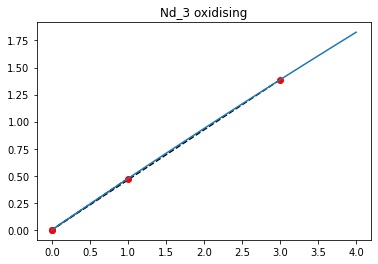

[-5.86474679e-03  4.79891672e-01  4.48691293e-16]
Pr3_ox
{4.0: (-3.024317191666667, None), 3.667: (-3.2180700727941174, None), 3.429: (-3.4043555749999994, None), 3.556: (-3.311919917, None), 6.0: (-1.9404715562499995, None), 3.636: (-3.2632359953225807, None), 3.6: (-3.3640411762499993, None)} -3.73387589775


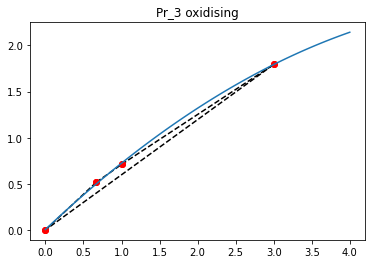

[-0.06143665  0.78033606  0.00465986]
Sm3_ox
{4.0: (-3.0611810661111103, None), 6.0: (-1.9847407920833327, None)} -3.861090533583333


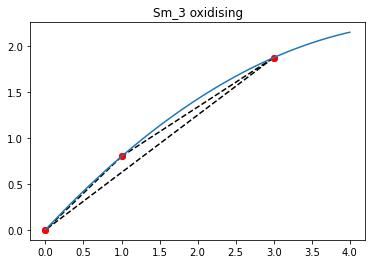

[-8.72297768e-02  8.87139244e-01  3.84592537e-16]
Eu3_ox
{4.0: (-2.4895677899999993, None), 6.0: (-1.7015827825, None)} -3.1691670297499996


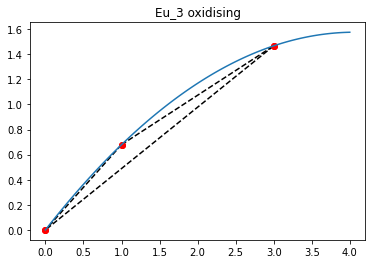

[-9.52022453e-02  7.74801485e-01  5.12790050e-16]
Gd3_ox
{4.0: (-3.0972412950000003, None), 6.0: (-1.7648668062499988, None)} -3.89417473375


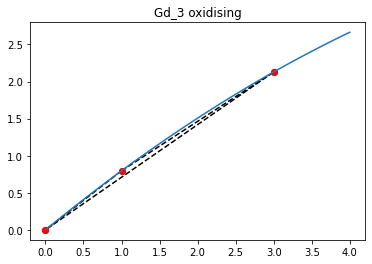

[-4.35820648e-02  8.40515504e-01  7.69185075e-16]
Tb3_ox
{3.636: (-3.454791365806452, None), 4.0: (-3.186477536666666, None), 3.429: (-3.609428142631578, None), 3.25: (-3.716755370952381, None), 3.6: (-3.467489917142857, None), 3.667: (-3.387980654117648, None), 6.0: (-2.0443497949999996, None)} -3.9823545307499995


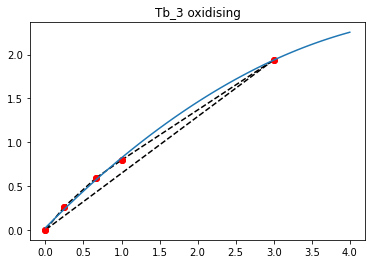

[-0.07992875  0.87722191  0.02407942]
Dy3_ox
{4.0: (-3.1666978083333333, None), 6.0: (-1.9951220799999998, None)} -4.008457858


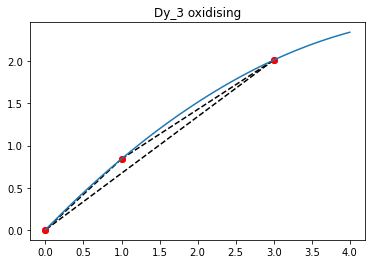

[-8.53240618e-02  9.27084111e-01  8.97382587e-16]
Ho3_ox
{6.0: (-2.0650045749999997, None), 4.0: (-3.1822844783333335, None)} -4.032430118999999


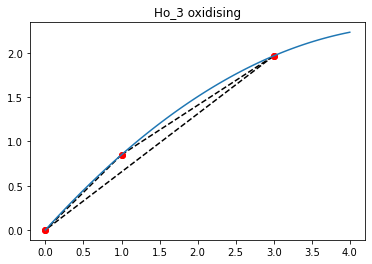

[-9.71685630e-02  9.47314204e-01  6.40987562e-16]
Er3_ox
{6.0: (-2.0756603474999995, None), 4.0: (-3.19846809, None)} -4.055964048249999


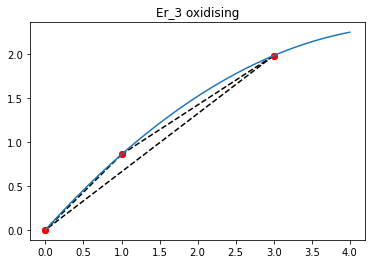

[-9.86973623e-02  9.56193321e-01  7.69185075e-16]
Tm3_ox
{6.0: (-2.0950142308333337, None), 4.0: (-3.225622057777777, None)} -4.091819262583333


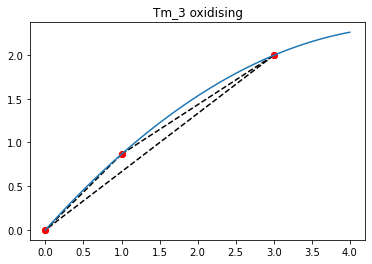

[-1.00297764e-01  9.66494969e-01  8.97382587e-16]
Yb3_ox
{4.0: (-2.5877955372222226, None), 6.0: (-1.3731809454166664, None), 4.667: (-1.5793164060000011, None)} -2.698201496416666


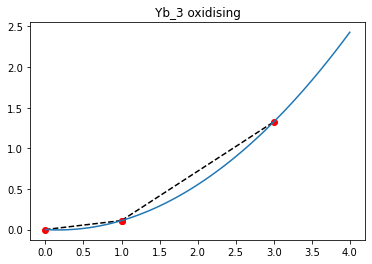

[ 1.65633779e-01 -5.52278197e-02 -4.80740672e-17]
Lu3_ox
{6.0: (-2.3259364025, None), 4.0: (-3.24253671, None)} -4.122854947249999


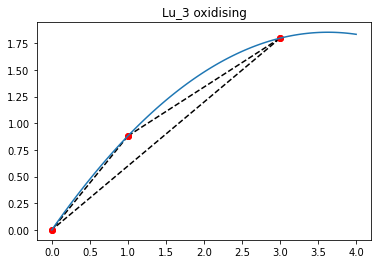

[-1.40672694e-01  1.02099093e+00  8.97382587e-16]
Si3_red
{1.0: (-0.8385178299999999, None), 2.0: (-2.047090918333333, None), 0.667: (-0.7829878249999989, None)} -2.164898087


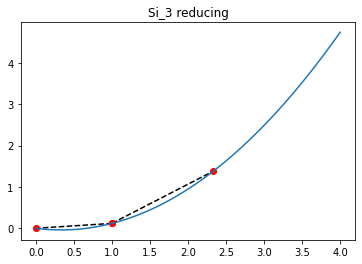

Al3_red
{1.105: (-1.8528613972881365, None), 0.75: (-1.3891308750000007, None), 1.0: (-1.7194461427777783, None), 2.0: (-1.5510961400000003, None)} -3.425327611


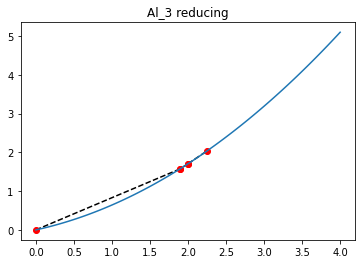

Ti3_red
{2.0: (-2.9071563699999983, None), 0.667: (-1.5697335962499994, None), 1.0: (-2.0351443699999994, None), 2.286: (-2.923118210666665, None), 2.222: (-2.8148112331578945, None), 2.667: (-3.1628198142857133, None), 1.5: (-2.434381775714286, None), 2.6: (-3.1366758056521724, None), 2.2: (-2.8552565857142853, None), 2.545: (-3.097268582799999, None), 1.333: (-2.352037862, None), 2.5: (-3.0901187155555565, None), 0.333: (-0.9167805728571414, None), 1.778: (-2.590827079117646, None), 2.889: (-3.125687772272726, None), 2.8: (-3.0813335200000003, None)} -3.302391907999999


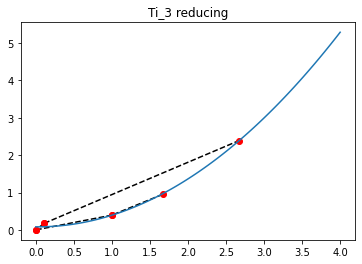

V3_red
{2.0: (-2.0900432124999995, None), 0.857: (-0.43666697499999924, None), 1.143: (-0.8881518818181812, None), 0.375: (0.7281016226315804, None), 0.25: (0.9098015111111126, None), 2.56: (-2.2929163908771932, None), 2.889: (-2.2750996977272724, None), 2.8: (-2.2821460545833334, None), 1.8: (-1.78844788, None), 2.462: (-1.641181437413793, None)} -2.5252870819999993


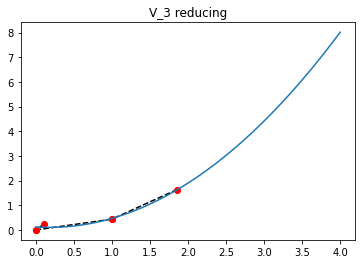

Cr3_red
{2.0: (-1.9660694825, None), 1.0: (0.007758293333334082, None), 0.667: (0.08262339625000031, None), 2.889: (-2.0367599327272723, None), 2.667: (-2.169753194285714, None), 2.8: (-1.8816294612499993, None)} -2.3653643719999993


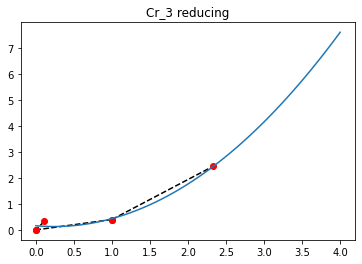

Mn3_red
{2.0: (-1.978353909827586, None), 2.667: (-2.0493764527093594, None), 2.8: (-1.7996586556896554, None), 2.889: (-1.7962894089498436, None)} -2.0127861137370697


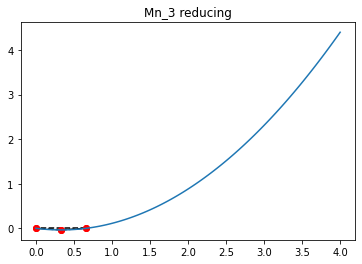

Fe3_red
{2.0: (-1.4808619749999998, None), 2.667: (-1.644345250714285, None), 2.143: (-1.461197201724137, None), 2.286: (-1.4929919349999992, None), 2.25: (-1.4976954999999994, None), 2.2: (-1.4895340702380953, None), 2.571: (-1.4037979220833328, None), 2.133: (-1.4404108483870963, None), 2.923: (-1.389995188749999, None), 2.977: (-1.5822259906542062, None), 2.783: (-1.557306477090909, None), 2.222: (-1.1914144752631577, None), 2.5: (0.22179137222222256, None), 2.732: (-1.5702393636082468, None), 2.118: (-1.4729404399999986, None), 2.154: (-1.4513672392592594, None), 2.8: (-1.4990504666666662, None), 2.56: (-0.07701086964912202, None), 2.889: (-1.4224028631818175, None), 2.053: (-1.4245943180519487, None), 2.057: (-0.7133691808450704, None), 2.174: (-1.477888945416666, None), 2.19: (-1.4782017770454534, None), 2.187: (-0.2360268291044772, None), 2.308: (-0.9615702932142861, None), 2.182: (-1.4805700930434775, None), 0.667: (0.7701602262500007, None), 2.167: (-1.4434921363999988, None)}

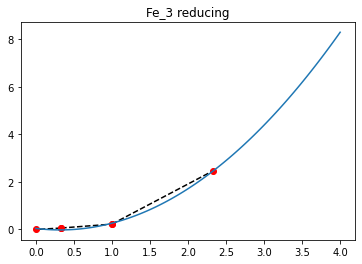

Co3_red
{2.759: (-1.1907349313768114, None), 2.783: (-1.1552269373636368, None), 2.0: (-1.2833611112500005, None), 2.8: (-0.8709627491666678, None), 2.667: (-1.2688075828571421, None), 2.889: (-1.0128522947727276, None)} -0.8174023645000005


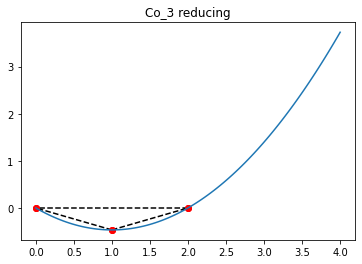

Ni3_red
{2.4: (-1.067370058181818, None), 0.5: (1.018611686, None), 2.333: (-1.0777615892307697, None), 2.889: (-0.8096237477272723, None), 2.133: (-1.1516823264516127, None), 2.222: (-1.1073149231578947, None), 2.0: (-1.2172232425000002, None), 1.5: (-0.6123868157142862, None), 1.6: (-0.7310815366666662, None), 2.667: (-1.0457198778571428, None), 2.8: (-0.4415433120833337, None)} -0.6389061690000003


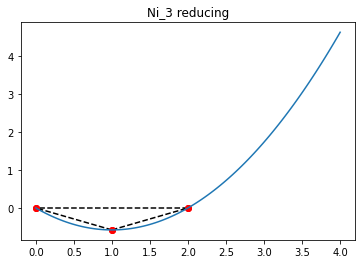

Cu3_red
{2.0: (-0.9417754449999997, None), 2.667: (-0.8309718028571422, None), 0.25: (-0.09701978444444423, None), 1.75: (-0.8289664273333333, None), 1.5: (-0.803437088571429, None), 2.889: (-0.6653228745454536, None), 0.031: (0.002391742000000174, None), 2.8: (-0.6631301675000003, None), 1.333: (-0.6026431480000004, None), 1.0: (-0.6438123283333331, None)} -0.8315602755000003


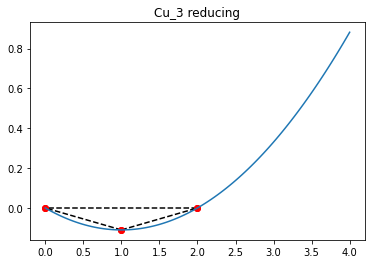

Nb3_red
{2.0: (-2.2847799366666672, None), 2.5: (-2.4662042883333335, None)} -2.5713432450000004


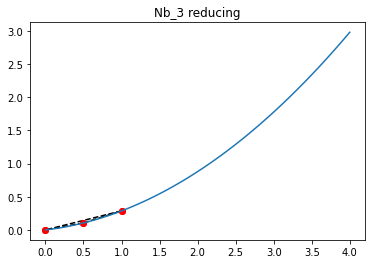

Mo3_red
{1.0: (1.447783013333334, None), 2.5: (-1.0023631494444443, None)} -1.4891102515000005


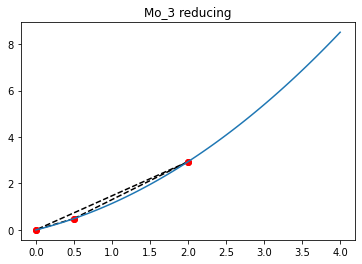

Li3_red
{3: (-0.5888337879365076, None), 1.0: (-2.060918257777777, None), 2.0: (-1.7601507458333332, None)} -0.5888337879365076


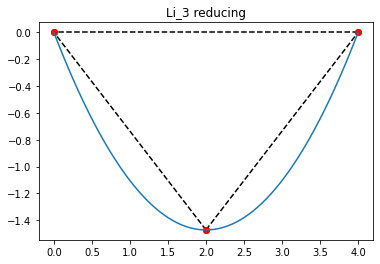

Be3_red
{3: (-0.5169725341666666, None), 2.0: (-3.1018352049999995, None)} -0.5169725341666666


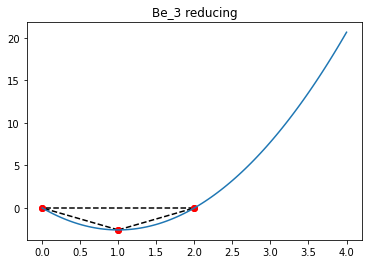

Na3_red
{3: (-0.4127239876190475, None), 1.0: (-1.4445339566666664, None), 0.333: (-0.4805849880952377, None), 2.0: (-1.4227934458333331, None)} -0.4127239876190475


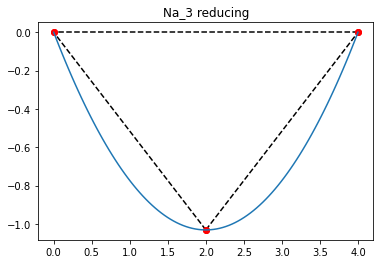

Mg3_red
{3: (-0.5089604602777779, None), 2.0: (-3.0537627616666674, None)} -0.5089604602777779


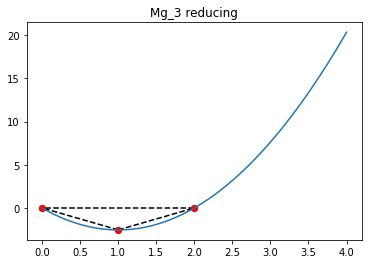

K3_red
{3: (-0.23423684025000005, None), 1.0: (-1.2471773620000002, None), 2.0: (-1.4054210415000004, None)} -0.23423684025000005


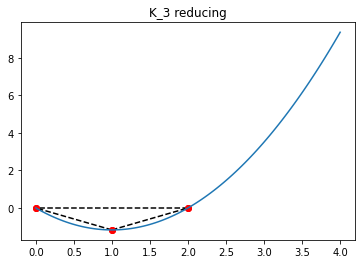

Ca3_red
{2.0: (-3.3077351674999997, None)} -2.39847709


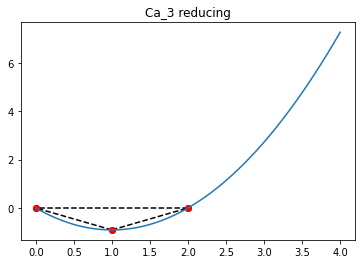

Rb3_red
{0.316: (-0.45055842056818185, None), 1.0: (-1.132488708333333, None), 2.0: (-1.3429314262499998, None), 0.444: (-0.6575091679545457, None), 0.375: (-0.49814936342105237, None), 0.333: (-0.5155633114285716, None)} -1.3381510210000003


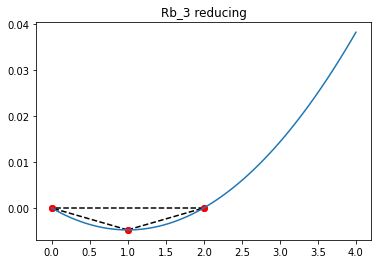

Sr3_red
{2.0: (-3.076077268333333, None)} -1.9478391786666664


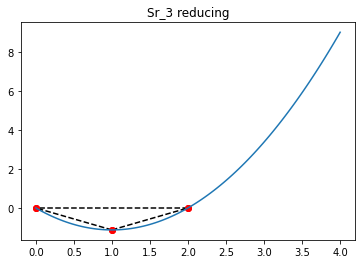

Cs3_red
{1.0: (-1.1877264619540233, None), 2.0: (-1.3404362989655172, None), 0.286: (-0.4596542623563216, None), 0.667: (-0.9276689359482759, None), 0.545: (-0.7913223474815267, None)} -1.3426218101724139


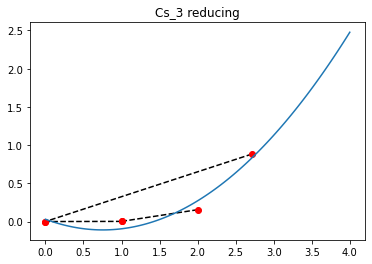

Ba3_red
{3: (-0.4704351133333334, None), 2.0: (-2.8226106800000004, None)} -0.4704351133333334


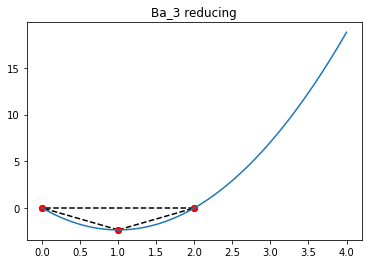

Sc3_red
{1.9: (-3.1611457430769234, None), 2.0: (-3.2394702375, None), 1.875: (-3.145588219032259, None)} -3.9674971125000003
Zn3_red
{3: (-0.29833202958333327, None), 2.0: (-1.7899921774999998, None)} -0.29833202958333327


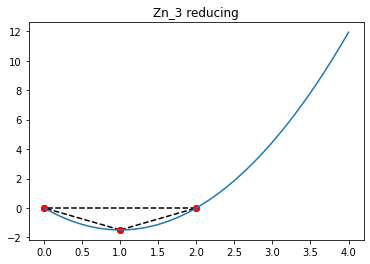

Ga3_red
{2.0: (-1.3837508599999997, None)} -2.267768931999999
WARNING! Adding an end member so can perform fit, try gather more data for this element.


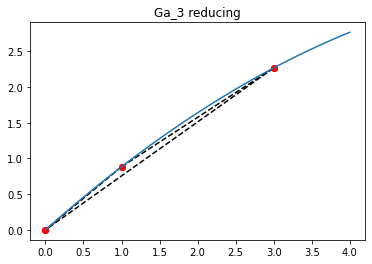

Ge3_red
{0.667: (0.0780942575000006, None)} -1.4878800639999996
WARNING! Adding an end member so can perform fit, try gather more data for this element.
As3_red
{} -1.628103555
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018143115  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

As  odd.


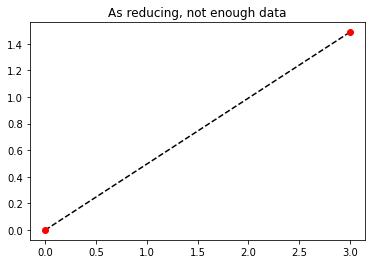

Se3_red
{3: (-0.28819533957031235, None)} -0.28819533957031235
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018143115  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.1e-15  _one-merge 1.1e-14
  _near-inside 5.4e-14  Visible-distance 4.3e-15  U-max-coplanar 4.3e-15
  Width-outside 8.6e-15  _wide-facet 2.6e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3  0.29
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.1e-15.  The center poi

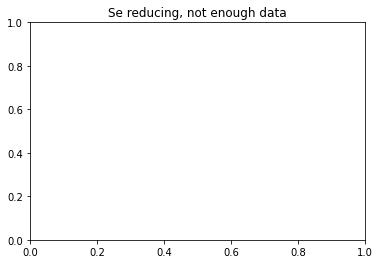

Br3_red
{2.0: (0.577525615, None), 1.0: (-0.06536963583333325, None)} -0.1974797374999998
Y3_red
{2.0: (-3.094282391666666, None)} -3.969855263083333
WARNING! Adding an end member so can perform fit, try gather more data for this element.


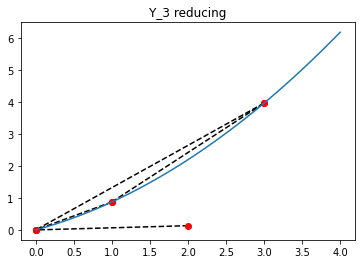

Zr3_red
{3: (-0.953063671875, None), 0.667: (-1.5447513525, None), 1.0: (-1.9901664400000003, None), 2.0: (-2.55676023, None), 0.5: (-1.2398359913333334, None)} -0.953063671875


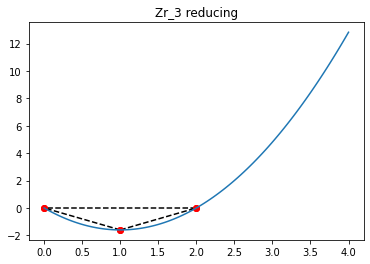

Tc3_red
{3: (-0.4705027716666668, None)} -0.4705027716666668
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018159922  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.2e-15  _one-merge 1.1e-14
  _near-inside 5.6e-14  Visible-distance 4.4e-15  U-max-coplanar 4.4e-15
  Width-outside 8.9e-15  _wide-facet 2.7e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3  0.47
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.2e-15.  The center point

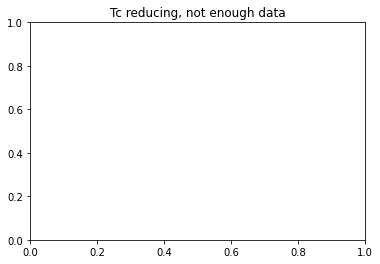

Ru3_red
{3: (-0.36407665208333345, None)} -0.36407665208333345
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018159922  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.2e-15  _one-merge 1.1e-14
  _near-inside 5.4e-14  Visible-distance 4.4e-15  U-max-coplanar 4.4e-15
  Width-outside 8.7e-15  _wide-facet 2.6e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3  0.36
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.2e-15.  The center poi

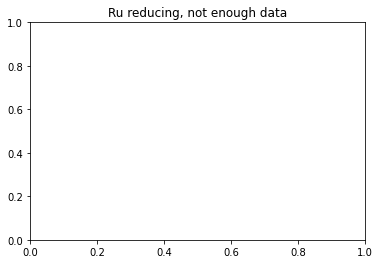

Rh3_red
{} -1.0805171704999998
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018159922  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Rh  odd.


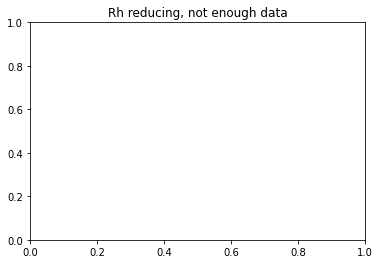

Pd3_red
{3: (-0.13174898749999994, None), 2.286: (-0.7301851448888881, None), 1.0: (-0.38643381666666665, None), 2.0: (-0.7904939249999997, None)} -0.13174898749999994


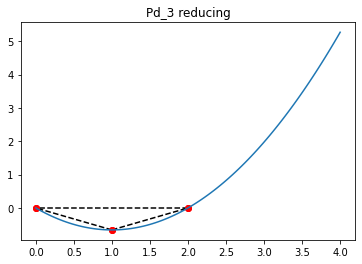

Ag3_red
{1.0: (-0.3218932738888892, None), 2.0: (-0.44411687416666623, None), 2.667: (-0.4047418692857148, None), 0.667: (-0.2238603712500002, None)} -0.3581646773333339


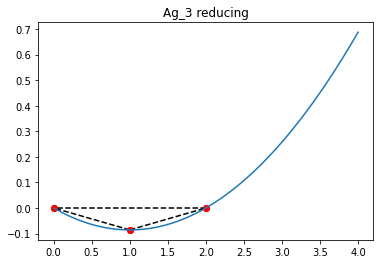

Cd3_red
{3: (-0.2286725925, None), 2.0: (-1.372035555, None)} -0.2286725925


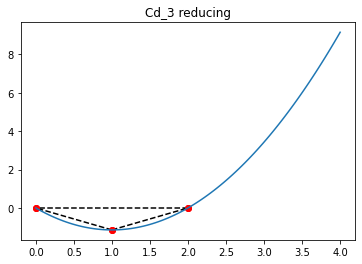

In3_red
{2.0: (-1.3538012275, None)} -1.9957859764999988
WARNING! Adding an end member so can perform fit, try gather more data for this element.


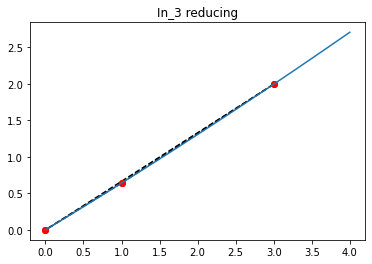

Sn3_red
{2.0: (-1.6373192899999998, None), 2.8: (-1.6239665812500013, None), 2.667: (-1.4847793421428575, None), 2.4: (-1.7689397277272736, None)} -1.6564513715000002


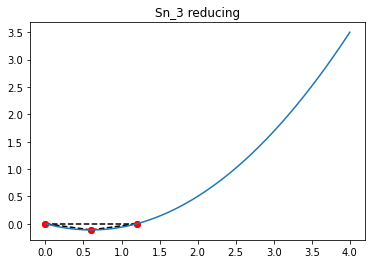

Sb3_red
{} -1.7505081320000002
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018193536  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Sb  odd.


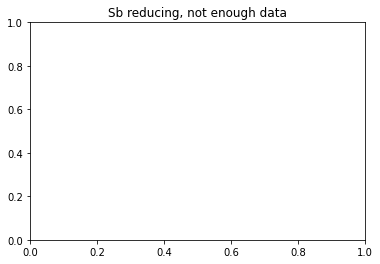

Te3_red
{3: (-0.3733354171874999, None), 2.0: (-0.2967256174999998, None)} -0.3733354171874999
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018193536  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 7e-16  _one-merge 3.5e-15  _near-inside 1.8e-14
  Visible-distance 1.4e-15  U-max-coplanar 1.4e-15  Width-outside 2.8e-15
  _wide-facet 8.5e-15  _maxoutside 4.2e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1 0.077
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 7e-16.  The center point, facets and distances
to the center point are as follows:


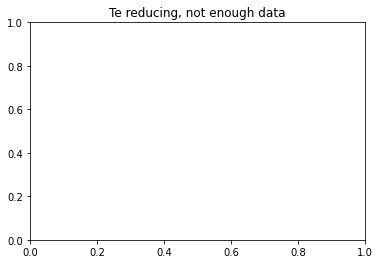

I3_red
{3: (-0.3020026618571429, None)} -0.3020026618571429
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018193536  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.1e-15  _one-merge 1.1e-14
  _near-inside 5.4e-14  Visible-distance 4.3e-15  U-max-coplanar 4.3e-15
  Width-outside 8.6e-15  _wide-facet 2.6e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3   0.3
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.1e-15.  The center point,

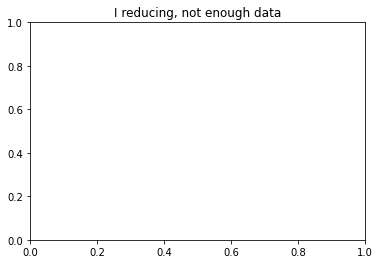

Hf3_red
{3: (-1.0046132827083332, None)} -1.0046132827083332
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018210343  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.5e-15  _one-merge 1.2e-14
  _near-inside 6.2e-14  Visible-distance 4.9e-15  U-max-coplanar 4.9e-15
  Width-outside 9.8e-15  _wide-facet 3e-14  _maxoutside 1.5e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3     1
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.5e-15.  The center point, 

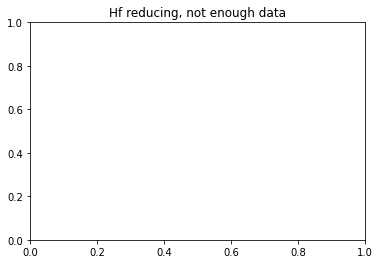

Ta3_red
{0.364: (-0.4998195746153851, None), 2.0: (-1.22945439, None), 0.5: (-0.7141294900000001, None), 1.909: (-1.7283779502325578, None), 1.8: (-1.5579393142105253, None), 1.0: (0.21959143666666656, None)} -2.597384415999999


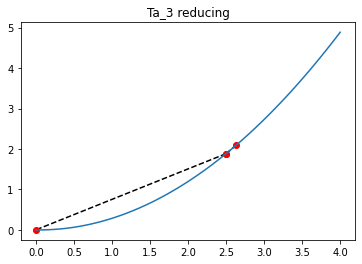

W3_red
{2.889: (-0.9532264249999995, None), 0.667: (2.342423497500001, None), 2.8: (-0.9263005275000005, None)} -0.9583725439999996


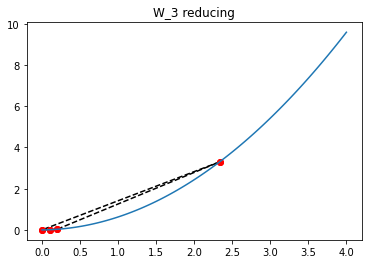

Re3_red
{3: (-1.0669282568750003, None)} -1.0669282568750003
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018227150  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.5e-15  _one-merge 1.2e-14
  _near-inside 6.2e-14  Visible-distance 5e-15  U-max-coplanar 5e-15
  Width-outside 1e-14  _wide-facet 3e-14  _maxoutside 1.5e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3   1.1
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.5e-15.  The center point, facets

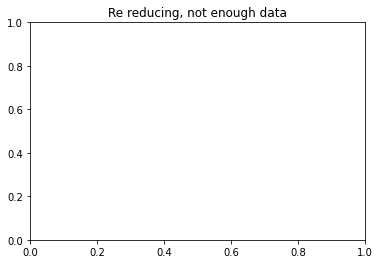

Os3_red
{3: (-0.9542234018749997, None), 0.667: (0.6572859300000009, None)} -0.9542234018749997
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018243957  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 2.3  Error-roundoff 2e-15  _one-merge 1e-14  _near-inside 5e-14
  Visible-distance 4e-15  U-max-coplanar 4e-15  Width-outside 8e-15
  _wide-facet 2.4e-14  _maxoutside 1.2e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):   2.3   1.6
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2e-15.  The center point, facets and distances
to the center point are as follows:

center 

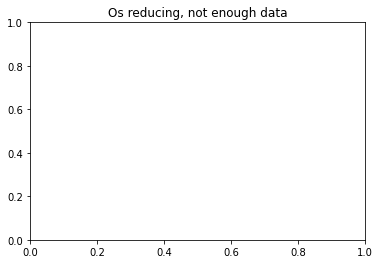

Ir3_red
{3: (-0.31488369125, None)} -0.31488369125
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018243957  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.2e-15  _one-merge 1.1e-14
  _near-inside 5.4e-14  Visible-distance 4.3e-15  U-max-coplanar 4.3e-15
  Width-outside 8.6e-15  _wide-facet 2.6e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3  0.31
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.2e-15.  The center point, facets a

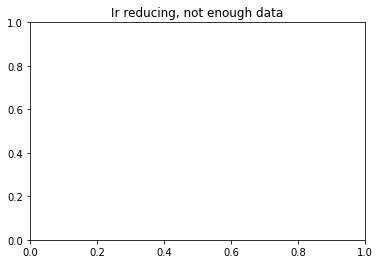

Pt3_red
{3: (-0.2313284070833332, None), 2.667: (-0.8257142857142858, None), 2.0: (-0.5834008600000001, None), 1.0: (-0.04615586166666588, None)} -0.2313284070833332


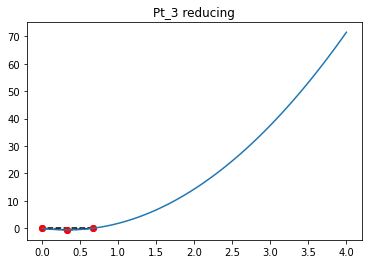

Au3_red
{0.667: (0.19704526750000012, None)} -0.4565825570000005
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Hg3_red
{3: (-0.10617658229166668, None), 2.0: (-0.6370594937500001, None)} -0.10617658229166668


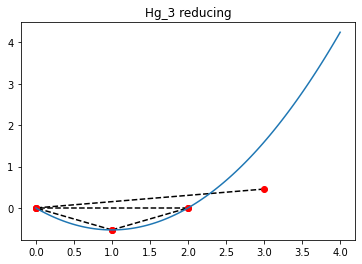

Tl3_red
{1.0: (-0.8199271266666665, None), 2.0: (-0.43597361499999987, None), 1.5: (-0.9372852321428575, None)} -1.1031272314999998


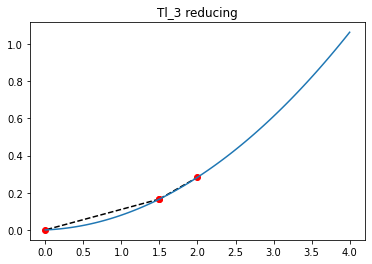

Pb3_red
{2.667: (-1.445836716785714, None), 2.0: (-1.4680857445312494, None), 1.0: (-0.6230187866666662, None), 0.667: (0.0013737950000001775, None)} -1.3921388914999993


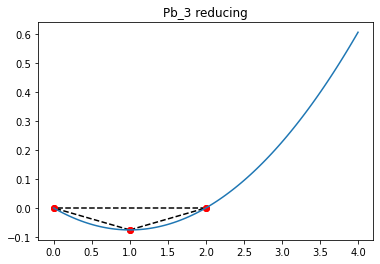

Bi3_red
{2.5: (-1.3705073783333344, None), 1.333: (-0.9692701079999996, None), 2.0: (-0.8834113649999996, None)} -1.6419509899999998
La3_red
{2.0: (-3.2033101475, None)} -3.872900711249999
WARNING! Adding an end member so can perform fit, try gather more data for this element.


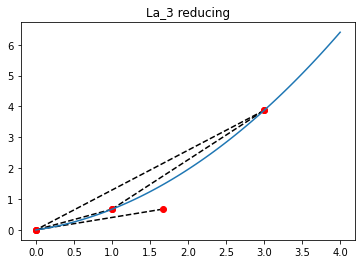

Ce3_red
{2.0: (-3.233142352499999, None)} -3.7685721692500005
WARNING! Adding an end member so can perform fit, try gather more data for this element.


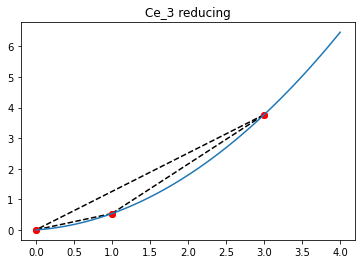

Nd3_red
{2.0: (-3.0723149650000003, None)} -3.7803256334999986
WARNING! Adding an end member so can perform fit, try gather more data for this element.


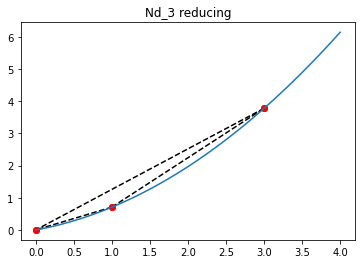

Pr3_red
{2.0: (-3.0452805775000007, None)} -3.73387589775
WARNING! Adding an end member so can perform fit, try gather more data for this element.


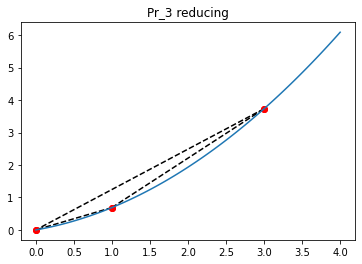

Sm3_red
{1.313: (-2.3164324476729563, None), 1.0: (-2.0739774922222223, None), 2.0: (-3.106597456666667, None)} -3.861090533583333
Eu3_red
{2.0: (-3.1200716025000004, None), 2.667: (-3.216232667142857, None)} -3.1691670297499996


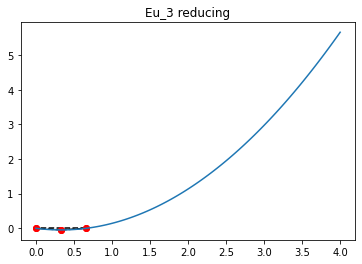

Gd3_red
{2.0: (-3.0340646700000002, None)} -3.89417473375
WARNING! Adding an end member so can perform fit, try gather more data for this element.


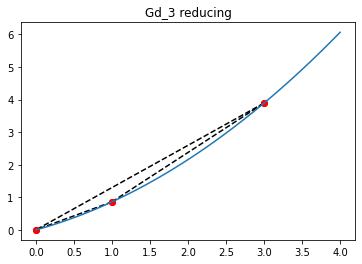

Tb3_red
{} -3.9823545307499995
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018277571  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tb  odd.


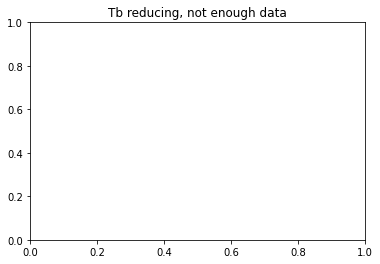

Dy3_red
{} -4.008457858
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018277571  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Dy  odd.


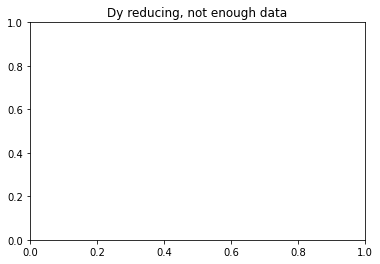

Ho3_red
{2.0: (-3.1233894025, None)} -4.032430118999999
WARNING! Adding an end member so can perform fit, try gather more data for this element.


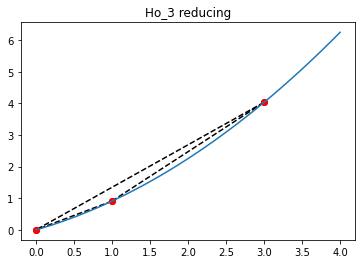

Er3_red
{2.0: (-3.1266739049999996, None)} -4.055964048249999
WARNING! Adding an end member so can perform fit, try gather more data for this element.


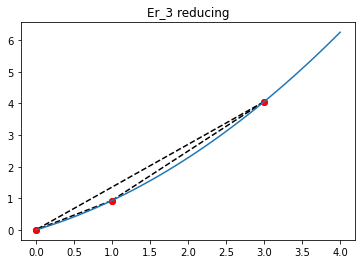

Tm3_red
{} -4.091819262583333
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018277571  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tm  odd.


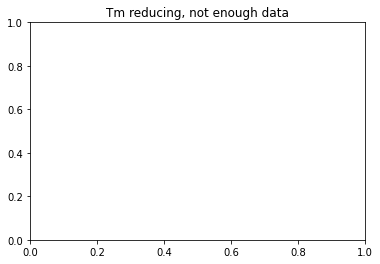

Yb3_red
{2.0: (-3.6283261983333333, None), 2.667: (-2.9713159167857146, None)} -2.698201496416666


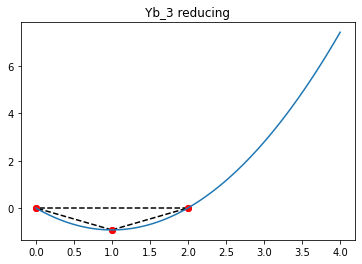

Lu3_red
{} -4.122854947249999
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 2018277571  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Lu  odd.


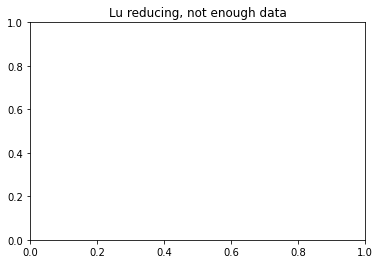

Si4_ox
{4.353: (-2.9183025977777772, None), 4.333: (-3.1191778257894724, None), 8.0: (-1.5783727216666654, None), 5.0: (-2.6021939028571426, None), 4.667: (-1.9866582439999991, None), 4.5: (-2.730264622307693, None), 4.458: (-2.8546522283870974, None)} -3.2664413149999993


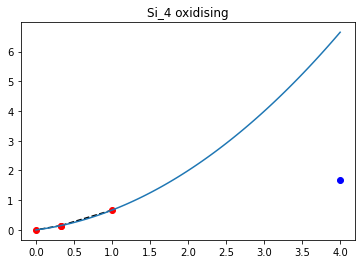

[ 3.32855640e-01  3.31391772e-01 -1.28197512e-16]
Al4_ox
{6.0: (-1.6239397406249996, None)} -2.669873368333333
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ti4_ox
{7.0: (-2.372602095555556, None), 5.333: (-2.4398223627272726, None), 4.667: (-2.9123895604999994, None)} -3.5004083808333335
None
V4_ox
{5.0: (-2.2880048985714287, None), 4.333: (-2.391191719210527, None), 6.0: (-2.0567253787499995, None), 4.889: (-2.271455647096774, None), 4.8: (-2.2982589692647055, None), 4.667: (-2.321625788, None), 4.5: (-2.3510451603846154, None), 5.6: (-1.9032921203947377, None), 5.333: (-2.0558007111363636, None), 4.833: (-2.2826718817073157, None), 6.667: (-1.4313400207692313, None)} -2.4794067783333333


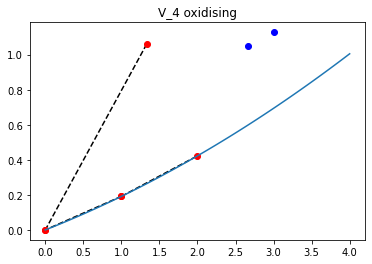

[ 1.99388200e-02  1.71463060e-01 -6.40987562e-17]
Cr4_ox
{5.0: (-1.6560083814285713, None), 6.0: (-1.5096780562499994, None), 4.5: (-1.574472071923077, None), 5.333: (-1.64812568090909, None), 4.8: (-1.8307398995588227, None), 5.25: (-1.6757490275862055, None), 5.053: (-1.6798458562686571, None), 4.667: (-1.5873285454999992, None)} -2.0463415316666658
None
Mn4_ox
{4.25: (-1.6370894718896556, None), 6.0: (-1.2542958736637928, None), 4.267: (-1.63008329244314, None), 4.3: (-1.586297598144499, None), 7.0: (-0.8788899611733718, None), 8.0: (-0.571748129931035, None)} -1.8045735507183907


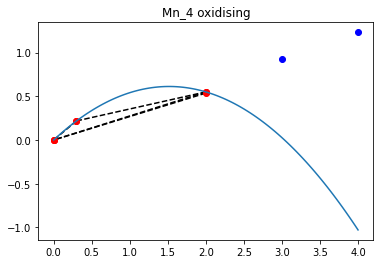

[-0.26614569  0.80743022  0.        ]
Fe4_ox
{6.5: (-0.7304429523529418, None), 4.25: (-1.051742656599999, None), 6.0: (-0.9197123012499997, None)} -1.2352142979166658


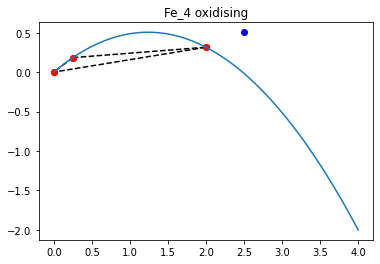

[-3.29220324e-01  8.16191646e-01 -3.20493781e-16]
Co4_ox
{8.0: (-0.0477397700000004, None)} -1.0793046775


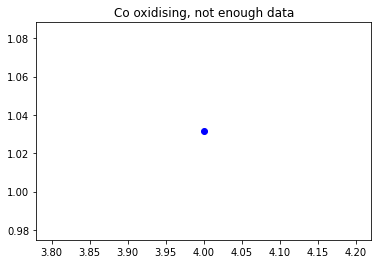

Ni4_ox
{4.4: (-0.5221941637499999, None), 5.0: (-0.5561055121428572, None), 6.0: (0.4418155500000003, None)} -0.685469113333333


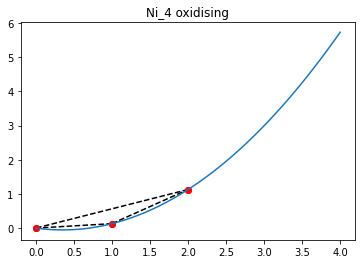

[ 4.34278730e-01 -3.04915129e-01  9.61481343e-17]
Cu4_ox
{} -0.5284182333333336


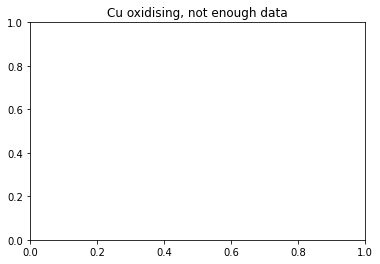

Nb4_ox
{5.0: (-3.0327488496938777, None), 4.833: (-3.0374842057317073, None), 6.0: (-2.4647783575, None), 4.5: (-2.784456805384616, None)} -2.8962547750000014


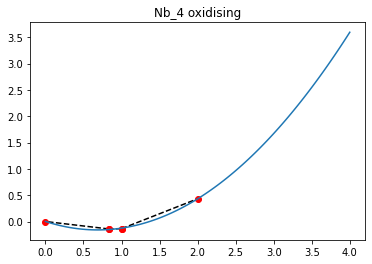

[ 0.34173311 -0.46864297  0.00106775]
Mo4_ox
{5.333: (-1.6921007063636357, None), 6.0: (-1.9229110493749992, None), 4.5: (-1.8623810976923063, None), 5.0: (-1.860406987857143, None), 10.0: (-1.1847070558333335, None), 5.778: (-1.9306581831428566, None), 8.0: (-1.0676932999999995, None), 5.75: (-1.935772359274193, None), 5.5: (-1.937953538499999, None), 5.6: (-1.9219500065789474, None), 5.556: (-1.9338494598529412, None), 7.0: (-1.3700206205555554, None), 6.667: (-1.5436972284615376, None), 5.529: (-1.9361885139843744, None), 5.077: (-1.9073964991304353, None), 4.667: (-1.7659168107500012, None)} -2.015734385833333


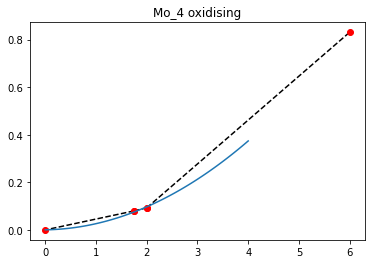

[0.02250735 0.00337672 0.00041679]
Li4_ox
{16.0: (-0.8846375340740733, None), 6.0: (-1.138571189166666, None)} -1.392210387222222
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Be4_ox
{} -1.3105624366666666


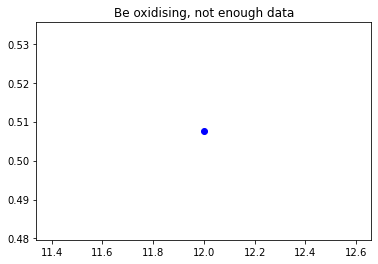

Na4_ox
{16.0: (-0.646523715833333, None), 9.0: (-0.8910210588636356, None), 10.0: (-0.5234980341666663, None), 6.0: (-1.1170697012499993, None)} -1.2668000216666668
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Mg4_ox
{} -2.168476221944444


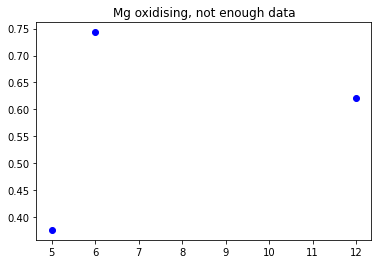

K4_ox
{6.0: (-1.1737919557499996, None)} -1.3364584009999991
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ca4_ox
{20.0: (-1.0284573527272722, None)} -2.355238631666667


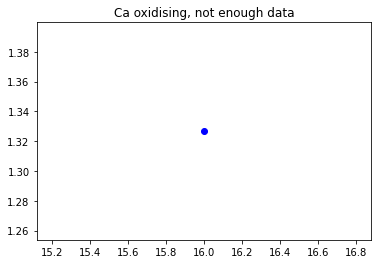

Rb4_ox
{6.0: (-1.1601528475, None)} -1.321567595833333
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sr4_ox
{20.0: (-1.0147847206060603, None), 12.0: (-1.2116782438095246, None), 8.0: (-0.8592437373333335, None)} -2.3520738855555554


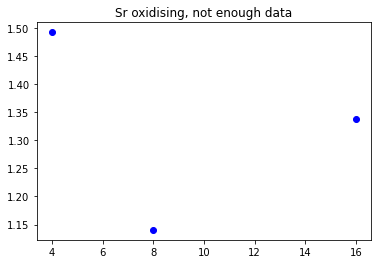

Cs4_ox
{} -1.3291547626436773


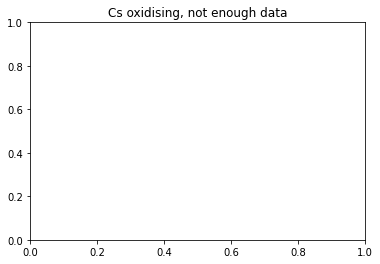

Ba4_ox
{20.0: (-1.0367065227272731, None), 8.0: (-1.5879292150000002, None), 12.0: (-1.34733606, None), 10.0: (-1.2500722229166663, None)} -2.3168347033333325


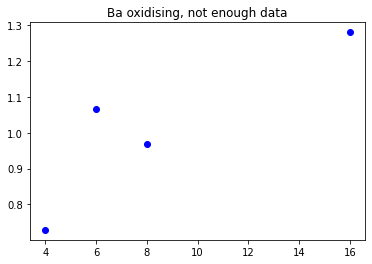

Sc4_ox
{6.0: (-1.785990889999999, None)} -3.0336421108333327
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Zn4_ox
{} -1.2051779108333325


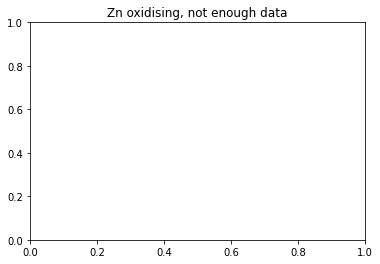

Ga4_ox
{6.0: (-0.8030734031249995, None)} -1.5798398591666667
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ge4_ox
{6.571: (-0.7961393696666669, None), 4.4: (-1.5926114290625009, None), 4.571: (-1.6585996252173918, None)} -2.0775245133333327
None
As4_ox
{5.0: (-1.55907805, None), 9.0: (-0.693401365454545, None), 6.0: (1.803728171875, None)} -1.5870349591666673


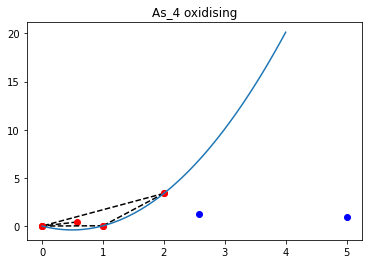

[ 1.66742466e+00 -1.63946775e+00  2.56395025e-16]
Se4_ox
{8.0: (-0.3066393809687493, None), 5.0: (-1.0205518156696431, None), 6.0: (-0.8724884215234372, None)} -1.1527813582812494


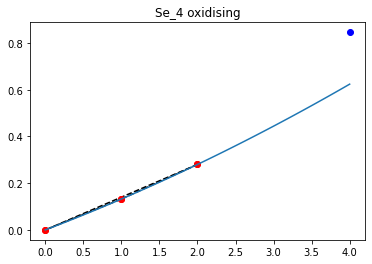

[ 7.91692577e-03  1.24312617e-01 -4.80740672e-17]
Br4_ox
{8.0: (-0.2797859224999997, None), 6.0: (-0.2802205137499998, None)} -0.08008579499999985
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Y4_ox
{6.0: (-2.019662025833333, None)} -3.1255152277777776
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Zr4_ox
{4.211: (-3.565631532203389, None)} -3.8122546875
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tc4_ox
{7.0: (-1.7976895825, None)} -1.8820110866666673


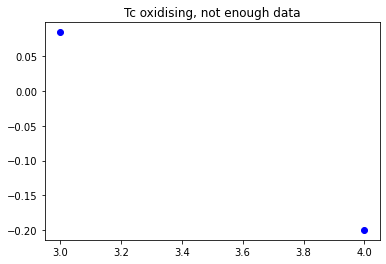

Ru4_ox
{8.0: (-1.1803451717500002, None)} -1.4563066083333338
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Rh4_ox
{} -1.2261393700000005


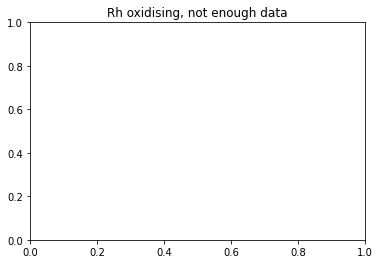

Pd4_ox
{} -0.7272990283333327


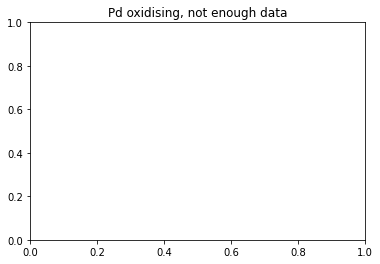

Ag4_ox
{} -0.3590486919444443


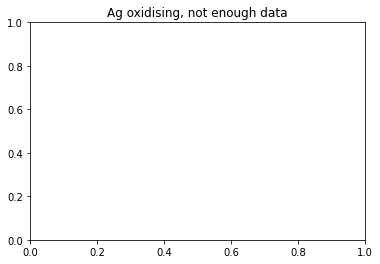

Cd4_ox
{} -1.0057692858333327


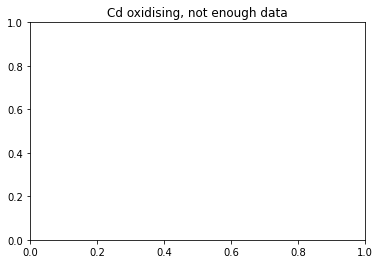

In4_ox
{6.0: (-1.0402070812499993, None)} -1.4326180766666659
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sn4_ox
{5.333: (-1.1902154681818178, None)} -2.1118337116666672
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sb4_ox
{5.0: (-1.746537438571428, None), 4.077: (-1.7562508735443032, None), 9.333: (-0.7220258020588239, None), 6.0: (-1.3299966474999998, None), 4.333: (-1.7800679181578942, None), 4.667: (-1.6950011810000003, None), 5.6: (-1.484265018157895, None), 4.5: (-1.5627934211538466, None), 8.0: (-0.5656004555, None), 7.0: (-0.9105243799999998, None), 5.333: (-1.6141966156060594, None)} -1.8361327245833332


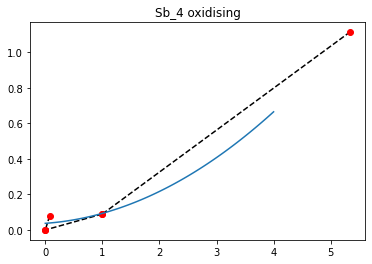

[0.03361211 0.02266978 0.0371253 ]
Te4_ox
{6.0: (-1.34014721375, None), 12.0: (-0.4401436508928577, None), 8.0: (-0.6346576670000001, None), 4.5: (-1.4508621007692306, None), 5.0: (-1.416410942142857, None)} -1.4933416687499996
None
I4_ox
{5.333: (-0.6210579902272728, None), 6.0: (-0.6078064149999993, None), 5.0: (-0.7550066546428572, None)} -0.6951155795833335


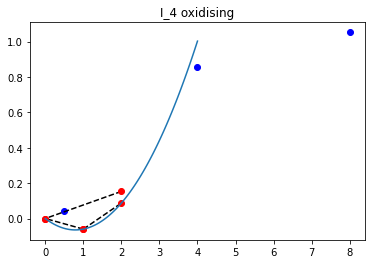

[ 1.03545657e-01 -1.63436732e-01  1.60246891e-17]
Hf4_ox
{} -4.018453130833333


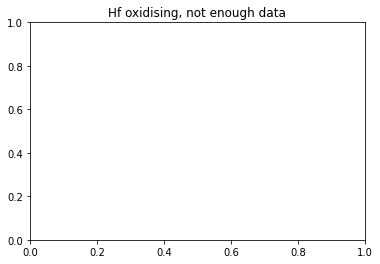

Ta4_ox
{5.0: (-3.3394399635714294, None), 6.0: (-2.773167433125, None), 20.0: (-1.226873802727273, None), 5.333: (-3.1558381997727283, None), 7.0: (-2.1040779216666676, None)} -3.0563588270833315


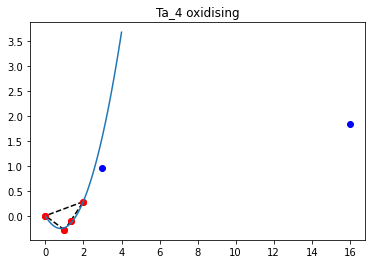

[ 0.3844551  -0.61928142 -0.00535807]
W4_ox
{6.667: (-1.8374891892307685, None), 6.0: (-2.183413561249999, None), 5.333: (-2.137938477727272, None), 7.0: (-1.4874519705555567, None), 10.0: (-1.4336169125000002, None), 5.444: (-2.151001807164177, None), 4.5: (-1.9204462630769235, None), 5.0: (-1.8945053635714286, None), 5.25: (-2.1342536723275862, None), 5.6: (-1.5575449360526314, None), 5.529: (-1.6491525585937497, None), 5.8: (-2.1644863392307685, None), 4.667: (-1.9940342265000002, None), 5.84: (-2.169087442244898, None), 8.0: (-1.1668297110000003, None)} -1.9415572149999998
WARNING! Adding an end member so can perform fit, try gather more data for this element.


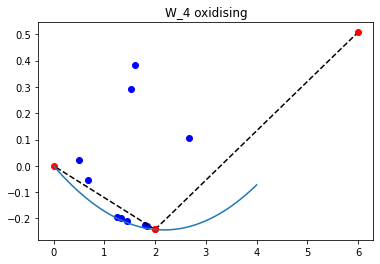

[ 5.13962226e-02 -2.23720618e-01 -1.28197512e-16]
Re4_ox
{6.0: (-2.1338565137500005, None), 5.333: (-1.8798034131818182, None), 7.0: (-2.025063832638888, None), 10.0: (-1.061157823333334, None), 6.667: (-1.4761708019230761, None)} -1.8950494924999985


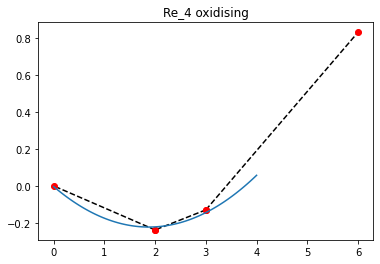

[ 0.06230256 -0.23391588 -0.00367009]
Os4_ox
{8.0: (-1.5267574429999995, None)} -1.342046629999999


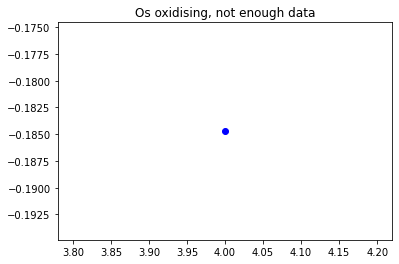

Ir4_ox
{6.0: (-0.9806692612500001, None)} -1.259534765
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pt4_ox
{12.0: (-0.5890866678571428, None), 6.0: (-0.6066289887499998, None)} -0.9253136283333327
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Au4_ox
{4: (-0.0913165114000001, None)} -0.0913165114000001
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Hg4_ox
{} -0.4154045608333326


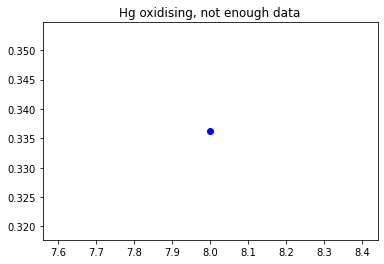

Tl4_ox
{4: (-0.22062544629999997, None)} -0.22062544629999997
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pb4_ox
{4.571: (-0.918967695217391, None)} -1.2983015083333334
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Bi4_ox
{5.0: (-1.1048817435714282, None), 4.5: (-1.1281416711538461, None), 4.667: (-1.1708430580000009, None)} -1.4596107733333332
None
La4_ox
{6.0: (-2.327208443749999, None)} -3.0885479750000004
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ce4_ox
{6.0: (-2.4336232762499996, None)} -3.926622528333333
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Nd4_ox
{6.0: (-2.3934333387500004, None), 5.0: (-2.8371483528571435, None)} -3.3062987083333337
None
Pr4_ox
{6.0: (-1.9404715562499995, None)} -3.024317191666667
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sm4_ox
{6

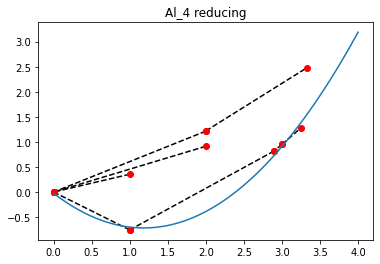

Ti4_red
{2.0: (-2.9071563699999983, None), 0.667: (-1.5697335962499994, None), 3.75: (-3.443114696304347, None), 1.0: (-2.0351443699999994, None), 3.0: (-3.302391907999999, None), 2.286: (-2.923118210666665, None), 2.222: (-2.8148112331578945, None), 3.333: (-3.3788314575000005, None), 2.667: (-3.1628198142857133, None), 1.5: (-2.434381775714286, None), 2.6: (-3.1366758056521724, None), 3.714: (-3.4387194579999987, None), 3.273: (-3.3480246851724123, None), 3.2: (-3.337638646153845, None), 2.2: (-2.8552565857142853, None), 2.545: (-3.097268582799999, None), 1.333: (-2.352037862, None), 2.5: (-3.0901187155555565, None), 3.5: (-3.4050568290909085, None), 0.333: (-0.9167805728571414, None), 3.778: (-3.4473459390384606, None), 3.385: (-3.3788645235714285, None), 3.667: (-3.435453412352941, None), 1.778: (-2.590827079117646, None), 2.889: (-3.125687772272726, None), 3.158: (-3.329586063469388, None), 2.8: (-3.0813335200000003, None), 3.6: (-3.4200159649999997, None), 3.25: (-3.3506883904761

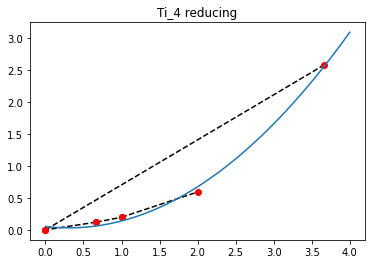

V4_red
{3.6: (-2.4959239401785704, None), 3.667: (-2.485902672941176, None), 2.0: (-2.0900432124999995, None), 0.857: (-0.43666697499999924, None), 1.143: (-0.8881518818181812, None), 3.778: (-2.4624043674999996, None), 3.333: (-2.5216525662500002, None), 3.0: (-2.5252870819999993, None), 3.5: (-2.490026317272727, None), 3.714: (-2.4586360342499987, None), 3.75: (-2.3376359419565214, None), 0.375: (0.7281016226315804, None), 0.25: (0.9098015111111126, None), 2.56: (-2.2929163908771932, None), 2.889: (-2.2750996977272724, None), 2.8: (-2.2821460545833334, None), 1.8: (-1.78844788, None), 2.462: (-1.641181437413793, None)} -2.4794067783333333


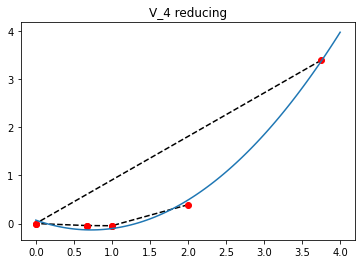

Cr4_red
{2.0: (-1.9660694825, None), 1.0: (0.007758293333334082, None), 3.0: (-2.3653643719999993, None), 3.333: (-1.8854764925000003, None), 0.667: (0.08262339625000031, None), 2.889: (-2.0367599327272723, None), 2.667: (-2.169753194285714, None), 2.8: (-1.8816294612499993, None), 3.667: (-1.7607074897058819, None)} -2.0463415316666658


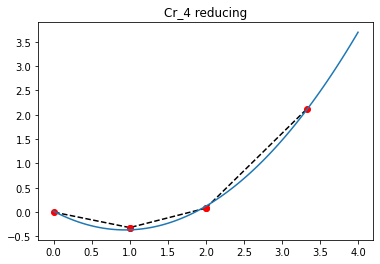

Mn4_red
{3.0: (-2.0127861137370697, None), 3.81: (-1.7949999269304697, None), 3.2: (-1.955414972175067, None), 2.0: (-1.978353909827586, None), 2.667: (-2.0493764527093594, None), 2.8: (-1.7996586556896554, None), 2.889: (-1.7962894089498436, None), 3.429: (-1.86630437829401, None)} -1.8045735507183907


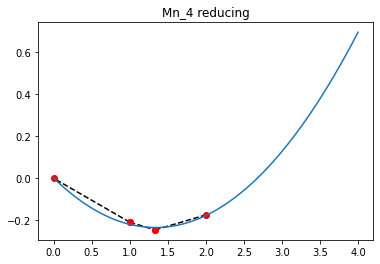

Fe4_red
{3.0: (-1.7061576239999994, None), 2.0: (-1.4808619749999998, None), 2.667: (-1.644345250714285, None), 2.143: (-1.461197201724137, None), 2.286: (-1.4929919349999992, None), 2.25: (-1.4976954999999994, None), 2.2: (-1.4895340702380953, None), 2.571: (-1.4037979220833328, None), 2.133: (-1.4404108483870963, None), 3.2: (-1.4770011859615384, None), 2.923: (-1.389995188749999, None), 2.977: (-1.5822259906542062, None), 2.783: (-1.557306477090909, None), 2.222: (-1.1914144752631577, None), 2.5: (0.22179137222222256, None), 2.732: (-1.5702393636082468, None), 2.118: (-1.4729404399999986, None), 3.048: (-1.495322866226414, None), 2.154: (-1.4513672392592594, None), 2.8: (-1.4990504666666662, None), 2.56: (-0.07701086964912202, None), 2.889: (-1.4224028631818175, None), 2.053: (-1.4245943180519487, None), 2.057: (-0.7133691808450704, None), 2.174: (-1.477888945416666, None), 2.19: (-1.4782017770454534, None), 2.187: (-0.2360268291044772, None), 2.308: (-0.9615702932142861, None), 2.1

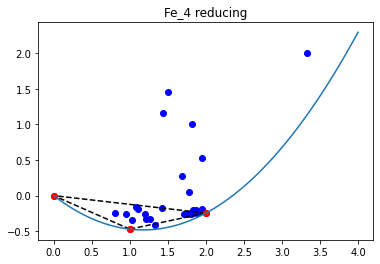

Co4_red
{3.81: (-0.9897550699180335, None), 2.759: (-1.1907349313768114, None), 2.783: (-1.1552269373636368, None), 2.0: (-1.2833611112500005, None), 2.8: (-0.8709627491666678, None), 2.667: (-1.2688075828571421, None), 3.0: (-0.8174023645000005, None), 3.2: (-1.1397359465384616, None), 3.429: (-1.0254213628947355, None), 2.889: (-1.0128522947727276, None), 3.733: (-1.0861586291860468, None)} -1.0793046775


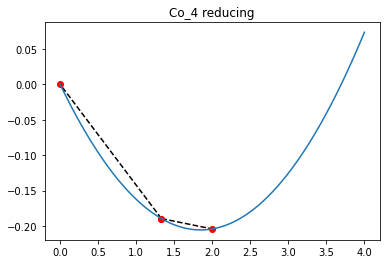

Ni4_red
{2.4: (-1.067370058181818, None), 0.5: (1.018611686, None), 2.333: (-1.0777615892307697, None), 2.889: (-0.8096237477272723, None), 2.133: (-1.1516823264516127, None), 3.0: (-0.6389061690000003, None), 2.222: (-1.1073149231578947, None), 2.0: (-1.2172232425000002, None), 1.5: (-0.6123868157142862, None), 1.6: (-0.7310815366666662, None), 2.667: (-1.0457198778571428, None), 2.8: (-0.4415433120833337, None)} -0.685469113333333


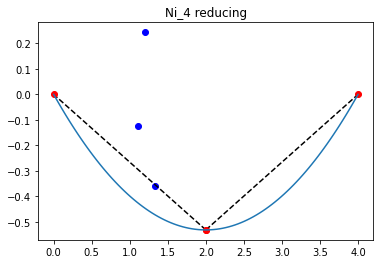

Cu4_red
{2.0: (-0.9417754449999997, None), 2.667: (-0.8309718028571422, None), 0.25: (-0.09701978444444423, None), 1.75: (-0.8289664273333333, None), 3.0: (-0.8315602755000003, None), 1.5: (-0.803437088571429, None), 2.889: (-0.6653228745454536, None), 0.031: (0.002391742000000174, None), 2.8: (-0.6631301675000003, None), 1.333: (-0.6026431480000004, None), 1.0: (-0.6438123283333331, None)} -0.5284182333333336


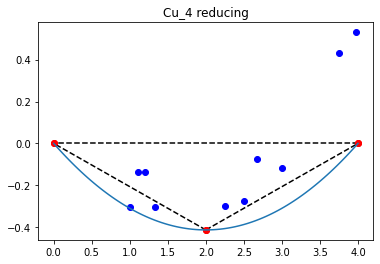

Nb4_red
{2.0: (-2.2847799366666672, None), 2.5: (-2.4662042883333335, None), 3.0: (-2.5713432450000004, None)} -2.8962547750000014


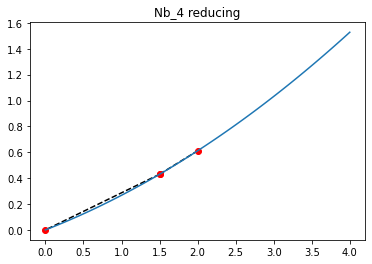

Mo4_red
{1.0: (1.447783013333334, None), 2.5: (-1.0023631494444443, None), 3.0: (-1.4891102515000005, None)} -2.015734385833333


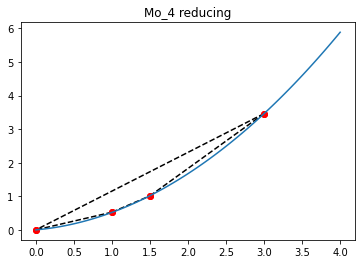

Li4_red
{1.0: (-2.060918257777777, None), 2.0: (-1.7601507458333332, None)} -1.392210387222222


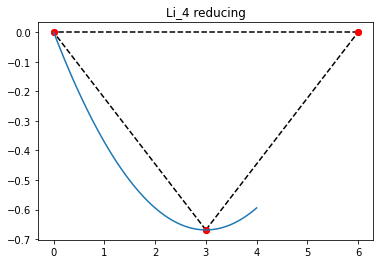

Be4_red
{2.0: (-3.1018352049999995, None)} -1.3105624366666666
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Na4_red
{1.0: (-1.4445339566666664, None), 0.333: (-0.4805849880952377, None), 2.0: (-1.4227934458333331, None)} -1.2668000216666668


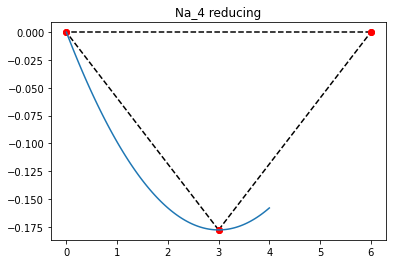

Mg4_red
{2.0: (-3.0537627616666674, None)} -2.168476221944444


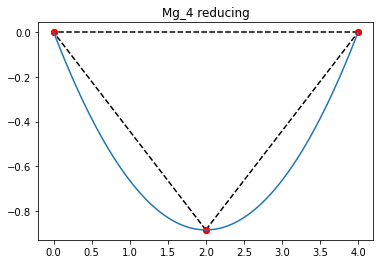

K4_red
{1.0: (-1.2471773620000002, None), 2.0: (-1.4054210415000004, None)} -1.3364584009999991


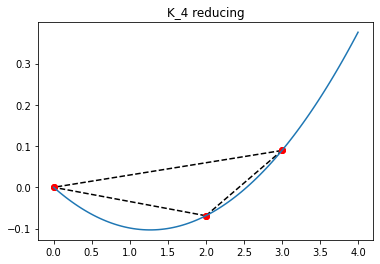

Ca4_red
{3.0: (-2.39847709, None), 2.0: (-3.3077351674999997, None)} -2.355238631666667


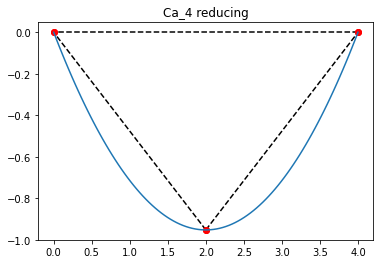

Rb4_red
{0.316: (-0.45055842056818185, None), 1.0: (-1.132488708333333, None), 3.0: (-1.3381510210000003, None), 2.0: (-1.3429314262499998, None), 0.444: (-0.6575091679545457, None), 0.375: (-0.49814936342105237, None), 0.333: (-0.5155633114285716, None)} -1.321567595833333


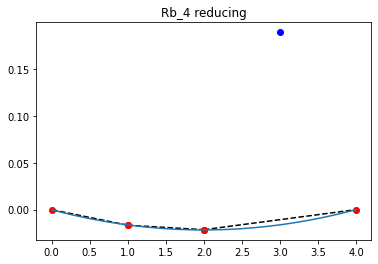

Sr4_red
{2.0: (-3.076077268333333, None), 3.0: (-1.9478391786666664, None)} -2.3520738855555554
Cs4_red
{1.0: (-1.1877264619540233, None), 2.0: (-1.3404362989655172, None), 3.0: (-1.3426218101724139, None), 0.286: (-0.4596542623563216, None), 0.667: (-0.9276689359482759, None), 0.545: (-0.7913223474815267, None)} -1.3291547626436773


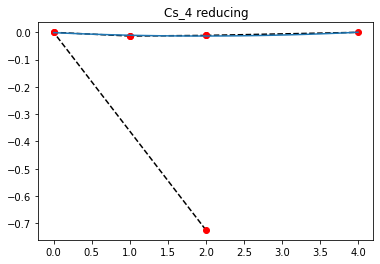

Ba4_red
{2.0: (-2.8226106800000004, None)} -2.3168347033333325


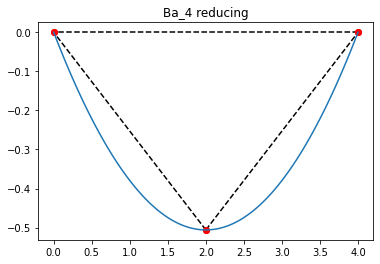

Sc4_red
{3.0: (-3.9674971125000003, None), 1.9: (-3.1611457430769234, None), 2.0: (-3.2394702375, None), 1.875: (-3.145588219032259, None)} -3.0336421108333327


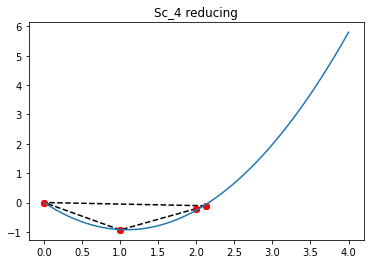

Zn4_red
{2.0: (-1.7899921774999998, None)} -1.2051779108333325


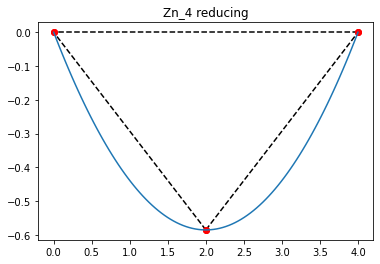

Ga4_red
{3.0: (-2.267768931999999, None), 3.333: (-1.9901455746874992, None), 2.0: (-1.3837508599999997, None)} -1.5798398591666667


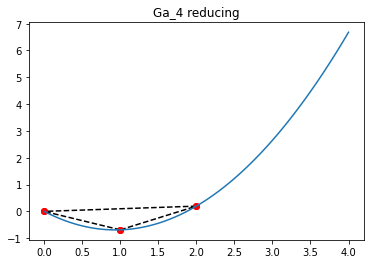

Ge4_red
{0.667: (0.0780942575000006, None), 3.0: (-1.4878800639999996, None)} -2.0775245133333327


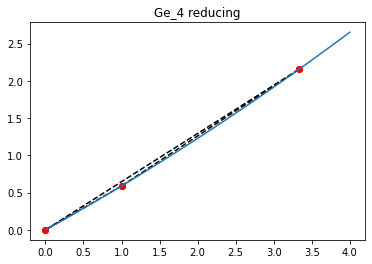

As4_red
{3.0: (-1.628103555, None)} -1.5870349591666673
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Se4_red
{} -1.1527813582812494


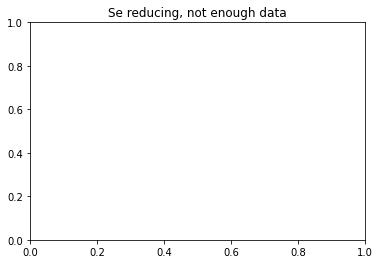

Br4_red
{3.0: (-0.1974797374999998, None), 2.0: (0.577525615, None), 1.0: (-0.06536963583333325, None)} -0.08008579499999985


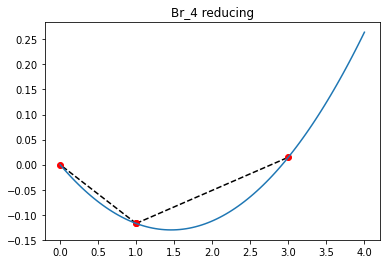

Y4_red
{3.0: (-3.969855263083333, None), 2.0: (-3.094282391666666, None)} -3.1255152277777776


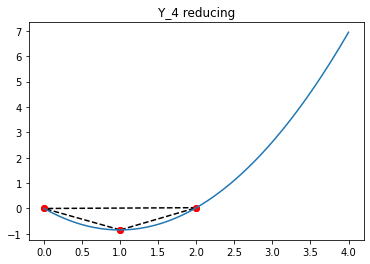

Zr4_red
{0.667: (-1.5447513525, None), 3.63: (-3.576835425394737, None), 1.0: (-1.9901664400000003, None), 3.667: (-3.621723770588237, None), 2.0: (-2.55676023, None), 0.5: (-1.2398359913333334, None)} -3.8122546875


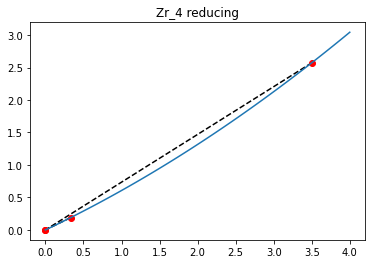

Tc4_red
{} -1.8820110866666673


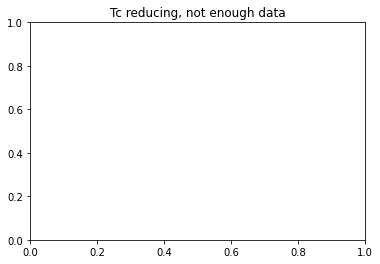

Ru4_red
{} -1.4563066083333338


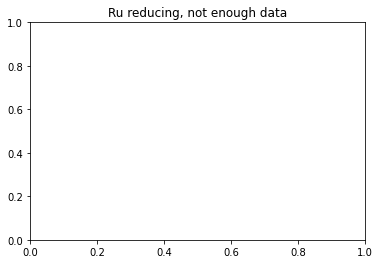

Rh4_red
{3.0: (-1.0805171704999998, None)} -1.2261393700000005
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Pd4_red
{2.286: (-0.7301851448888881, None), 1.0: (-0.38643381666666665, None), 2.0: (-0.7904939249999997, None)} -0.7272990283333327


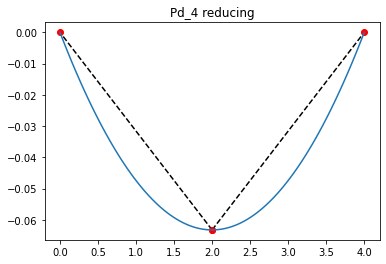

Ag4_red
{1.0: (-0.3218932738888892, None), 2.0: (-0.44411687416666623, None), 2.667: (-0.4047418692857148, None), 3.0: (-0.3581646773333339, None), 0.667: (-0.2238603712500002, None)} -0.3590486919444443


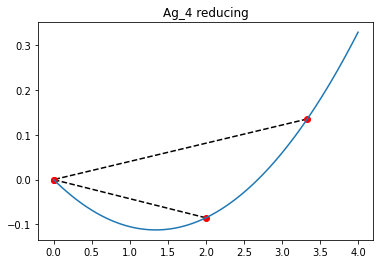

Cd4_red
{2.0: (-1.372035555, None)} -1.0057692858333327
WARNING! Adding an end member so can perform fit, try gather more data for this element.
In4_red
{3.0: (-1.9957859764999988, None), 2.0: (-1.3538012275, None)} -1.4326180766666659


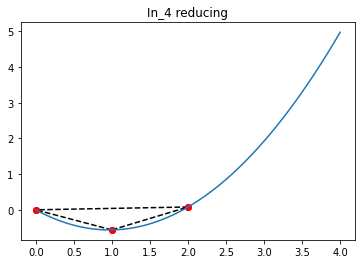

Sn4_red
{2.0: (-1.6373192899999998, None), 2.8: (-1.6239665812500013, None), 2.667: (-1.4847793421428575, None), 3.0: (-1.6564513715000002, None), 2.4: (-1.7689397277272736, None)} -2.1118337116666672


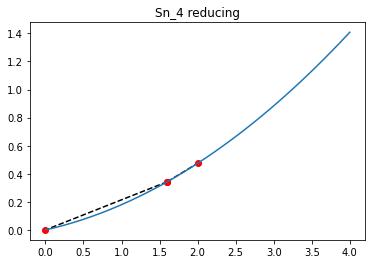

Sb4_red
{3.0: (-1.7505081320000002, None)} -1.8361327245833332
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Te4_red
{2.0: (-0.2967256174999998, None)} -1.4933416687499996
WARNING! Adding an end member so can perform fit, try gather more data for this element.
I4_red
{} -0.6951155795833335


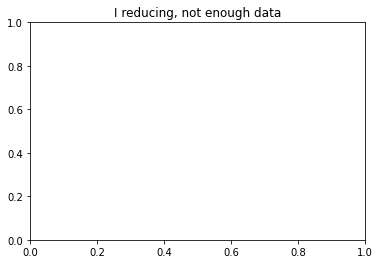

Hf4_red
{} -4.018453130833333


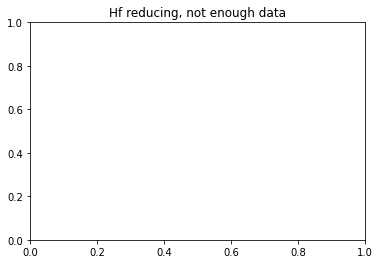

Ta4_red
{3.0: (-2.597384415999999, None), 0.364: (-0.4998195746153851, None), 2.0: (-1.22945439, None), 0.5: (-0.7141294900000001, None), 1.909: (-1.7283779502325578, None), 1.8: (-1.5579393142105253, None), 1.0: (0.21959143666666656, None)} -3.0563588270833315


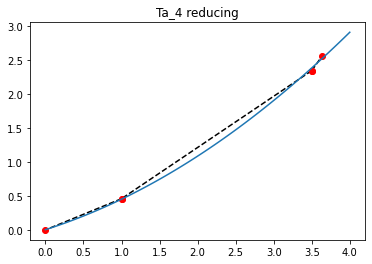

W4_red
{2.889: (-0.9532264249999995, None), 0.667: (2.342423497500001, None), 3.0: (-0.9583725439999996, None), 2.8: (-0.9263005275000005, None)} -1.9415572149999998


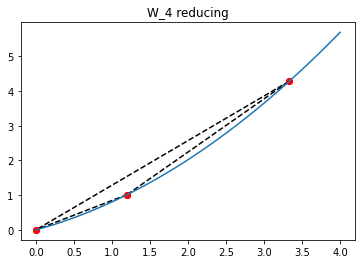

Re4_red
{} -1.8950494924999985


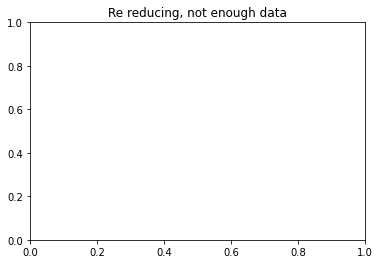

Os4_red
{0.667: (0.6572859300000009, None)} -1.342046629999999
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ir4_red
{} -1.259534765


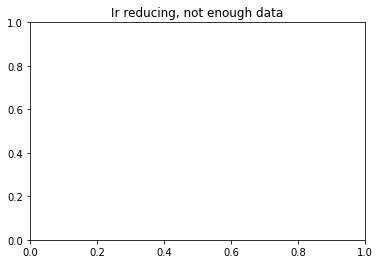

Pt4_red
{2.667: (-0.8257142857142858, None), 2.0: (-0.5834008600000001, None), 1.0: (-0.04615586166666588, None)} -0.9253136283333327
Au4_red
{4: (-0.0913165114000001, None), 3.0: (-0.4565825570000005, None), 0.667: (0.19704526750000012, None)} -0.0913165114000001


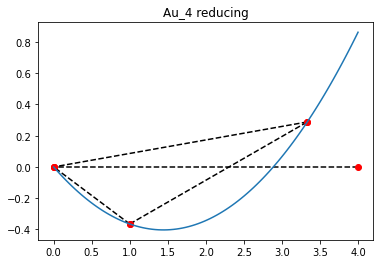

Hg4_red
{2.0: (-0.6370594937500001, None)} -0.4154045608333326
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tl4_red
{4: (-0.22062544629999997, None), 1.0: (-0.8199271266666665, None), 2.0: (-0.43597361499999987, None), 3.0: (-1.1031272314999998, None), 1.5: (-0.9372852321428575, None)} -0.22062544629999997


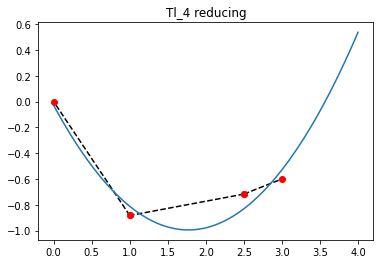

Pb4_red
{3.0: (-1.3921388914999993, None), 2.667: (-1.445836716785714, None), 2.0: (-1.4680857445312494, None), 1.0: (-0.6230187866666662, None), 0.667: (0.0013737950000001775, None), 3.333: (-1.3205758828125, None)} -1.2983015083333334


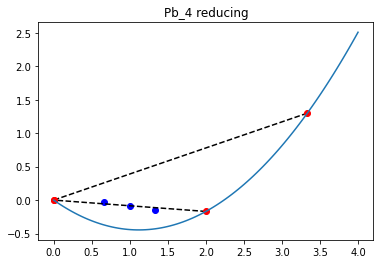

Bi4_red
{3.0: (-1.6419509899999998, None), 2.5: (-1.3705073783333344, None), 1.333: (-0.9692701079999996, None), 3.5: (-1.5692198868181815, None), 3.333: (-1.5325150268749999, None), 3.125: (-1.5730462600000004, None), 2.0: (-0.8834113649999996, None), 3.158: (-1.5676038183673475, None), 3.077: (-1.5967054972727266, None), 3.04: (-1.5938509382539676, None)} -1.4596107733333332


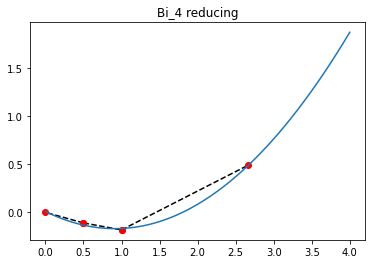

La4_red
{3.0: (-3.872900711249999, None), 2.0: (-3.2033101475, None)} -3.0885479750000004


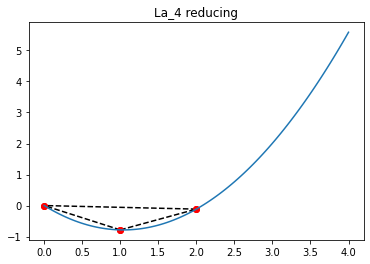

Ce4_red
{3.375: (-3.88974239488372, None), 3.429: (-3.9176818328947354, None), 3.0: (-3.7685721692500005, None), 3.6: (-3.9414715867857137, None), 3.636: (-3.9398167995161293, None), 2.0: (-3.233142352499999, None), 3.692: (-3.9333783812162157, None), 3.765: (-3.934809990918367, None)} -3.926622528333333


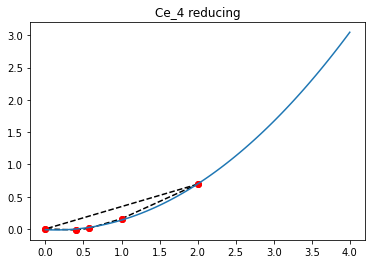

Nd4_red
{2.0: (-3.0723149650000003, None), 3.0: (-3.7803256334999986, None)} -3.3062987083333337


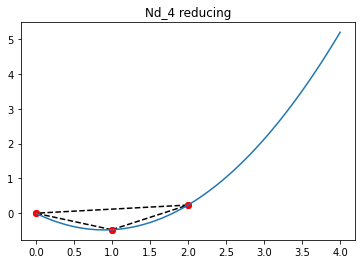

Pr4_red
{3.667: (-3.2180700727941174, None), 2.0: (-3.0452805775000007, None), 3.429: (-3.4043555749999994, None), 3.556: (-3.311919917, None), 3.0: (-3.73387589775, None), 3.636: (-3.2632359953225807, None), 3.6: (-3.3640411762499993, None)} -3.024317191666667


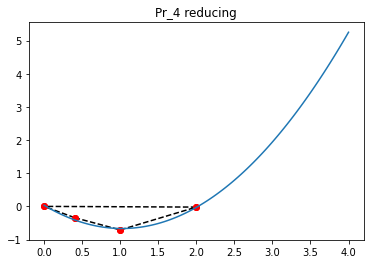

Sm4_red
{1.313: (-2.3164324476729563, None), 3.0: (-3.861090533583333, None), 1.0: (-2.0739774922222223, None), 2.0: (-3.106597456666667, None)} -3.0611810661111103


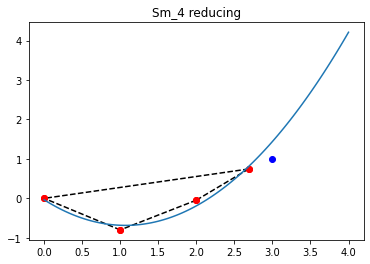

Eu4_red
{2.0: (-3.1200716025000004, None), 3.0: (-3.1691670297499996, None), 2.667: (-3.216232667142857, None)} -2.4895677899999993


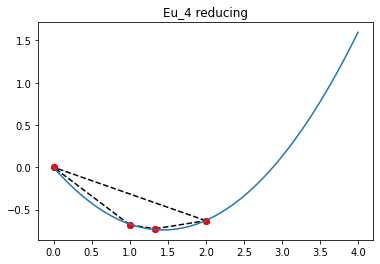

Gd4_red
{3.0: (-3.89417473375, None), 2.0: (-3.0340646700000002, None)} -3.0972412950000003


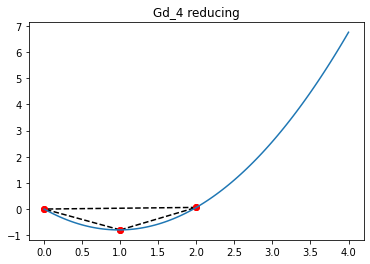

Tb4_red
{3.636: (-3.454791365806452, None), 3.0: (-3.9823545307499995, None), 3.429: (-3.609428142631578, None), 3.25: (-3.716755370952381, None), 3.6: (-3.467489917142857, None), 3.667: (-3.387980654117648, None)} -3.186477536666666


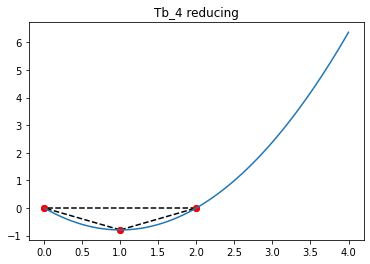

Dy4_red
{3.0: (-4.008457858, None)} -3.1666978083333333


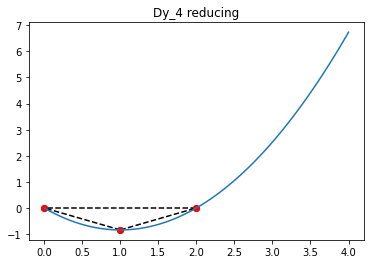

Ho4_red
{3.0: (-4.032430118999999, None), 2.0: (-3.1233894025, None)} -3.1822844783333335


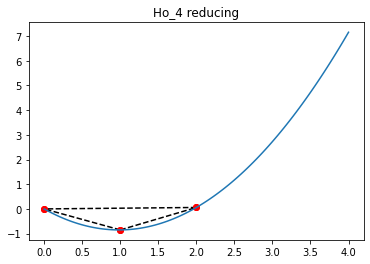

Er4_red
{3.0: (-4.055964048249999, None), 2.0: (-3.1266739049999996, None)} -3.19846809


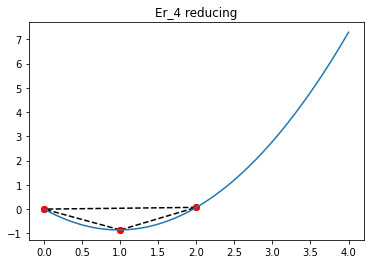

Tm4_red
{3.0: (-4.091819262583333, None)} -3.225622057777777


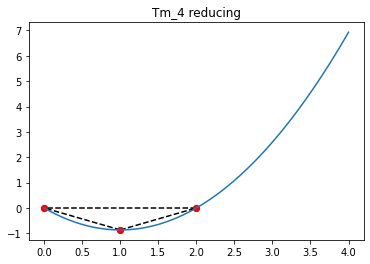

Yb4_red
{3.0: (-2.698201496416666, None), 2.0: (-3.6283261983333333, None), 2.667: (-2.9713159167857146, None)} -2.5877955372222226


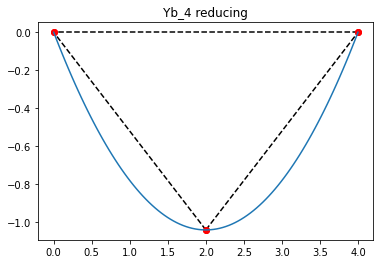

Lu4_red
{3.0: (-4.122854947249999, None)} -3.24253671
WARNING! Adding an end member so can perform fit, try gather more data for this element.


In [6]:
mp_quadratic_equations_ox = defaultdict()
mp_quadratic_equations_red = defaultdict()

for ox_iter in ox_states:
    for ele in unary_data.keys():
        print("{}{}_ox".format(ele, ox_iter))
        ox2low, form_ene = get_ox2lowest(ele, ele2mp[ox_iter][ele], ox_iter, oxidising=True)
        if ox_iter==4:
            hull_ox2energy = get_lower_hull(ox2low, ox_iter, form_ene, ele, oxidising=True)
        else:
            hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_iter, form_ene, ele, oxidising=True)
        if hull_ox2energy is None:
            mp_quadratic_equations_ox[ele+str(int(ox_iter))] = [0, -form_ene/(8-ox_iter),0]
            continue

        coeffs = get_quadratic(hull_ox2energy)
        print(coeffs)
        mp_quadratic_equations_ox[ele+str(int(ox_iter))] = coeffs
        if mp_quadratic_equations_ox[ele+str(int(ox_iter))] is None:
            mp_quadratic_equations_ox[ele+str(int(ox_iter))] = [0, -form_ene/(8-ox_iter), 0]

    for ele in unary_data.keys():
        print("{}{}_red".format(ele, ox_iter))
        ox2low, form_ene = get_ox2lowest(ele, ele2mp[ox_iter][ele], ox_iter, oxidising=False)

        if ox_iter==4:
            hull_ox2energy = get_lower_hull(ox2low, ox_iter, form_ene, ele, oxidising=False)
        else:
            hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_iter, form_ene, ele, oxidising=False)

        if hull_ox2energy is None:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = [0, -form_ene/ox_iter, 0]
            continue
        try:
            coeffs = get_quadratic(hull_ox2energy)
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = coeffs

        except TypeError:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = coeffs

        if mp_quadratic_equations_red[ele+str(int(ox_iter))] is None:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = [0, -form_ene/ox_iter, 0]

    for ele_ox in mp_quadratic_equations_red:
        if mp_quadratic_equations_red[ele_ox][0]<0:
            # cant have this curvature
            mp_quadratic_equations_red[ele_ox][0]=0
        if mp_quadratic_equations_ox[ele_ox][0]<0:
            mp_quadratic_equations_ox[ele_ox][0]=0
    

    

In the above plots, any time a line is fitted through points that means we have got coefficients by ordinary least squares. Many times there is not enough data to fit through, and in those cases we just take the parabola to be some linear function found by dividing the formation energy by an appropriate value depending on the oxidation state. In cases where the curve plotted is concave down, we set the first coefficient to 0.

```
if mp_quadratic_equations_red[ele_ox][0]<0:
    mp_quadratic_equations_red[ele_ox][0] = 0
```

A number of these parabolas we deem should not be shaped as they are to meet the criteria discussed in the paper that they should match the shape of the hull from the reference oxidation state, we list them here. You can check whether the plots yourself by doing a control+F of `Ni4_ox` for instance. This curve appears wrong since it supposes that Ni prefers 5+ to 4+ when this is likely just a facet of the large instability of the NiO2 entry.

Ni2_ox, Al2_red, Tl2_red, Bi2_red, Sr3_ox, Ag3_ox, Pd3_ox, Ni4_ox, Cr4_ox, W4_ox, Ag4_red, K4_red, Cs4_red, Au4_red, Tl4_red, Pb4_red

We will fix:
Ag4_red, K4_red, Cs4_red, Au4_red, Tl4_red, Pb4_red
by using the symmetric fitting function.

For the other parabolas we deem problematic we set them by hand by analysing the Materials Project database formation energies.

First deal with:

W4_ox, Ag4_red, K4_red, Cs4_red, Au4_red, Tl4_red, Pb4_red

using symmetric function

W4_ox
{6.667: (-1.8374891892307685, None), 6.0: (-2.183413561249999, None), 5.333: (-2.137938477727272, None), 7.0: (-1.4874519705555567, None), 10.0: (-1.4336169125000002, None), 5.444: (-2.151001807164177, None), 4.5: (-1.9204462630769235, None), 5.0: (-1.8945053635714286, None), 5.25: (-2.1342536723275862, None), 5.6: (-1.5575449360526314, None), 5.529: (-1.6491525585937497, None), 5.8: (-2.1644863392307685, None), 4.667: (-1.9940342265000002, None), 5.84: (-2.169087442244898, None), 8.0: (-1.1668297110000003, None)} -1.9415572149999998


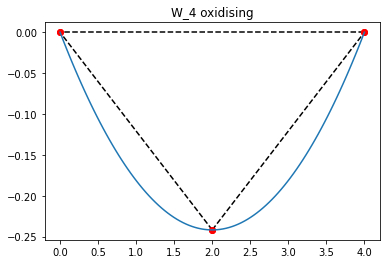

Ag4_red
{1.0: (-0.3218932738888892, None), 2.0: (-0.44411687416666623, None), 2.667: (-0.4047418692857148, None), 3.0: (-0.3581646773333339, None), 0.667: (-0.2238603712500002, None)} -0.3590486919444443


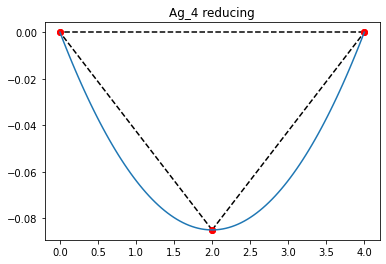

K4_red
{1.0: (-1.2471773620000002, None), 2.0: (-1.4054210415000004, None)} -1.3364584009999991


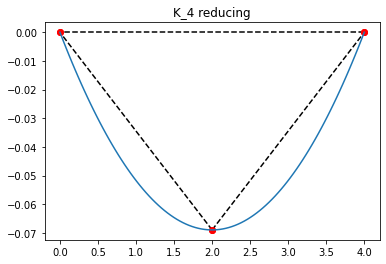

Cs4_red
{1.0: (-1.1877264619540233, None), 2.0: (-1.3404362989655172, None), 3.0: (-1.3426218101724139, None), 0.286: (-0.4596542623563216, None), 0.667: (-0.9276689359482759, None), 0.545: (-0.7913223474815267, None)} -1.3291547626436773


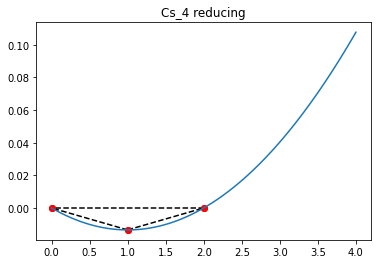

Au4_red
{4: (-0.0913165114000001, None), 3.0: (-0.4565825570000005, None), 0.667: (0.19704526750000012, None)} -0.0913165114000001


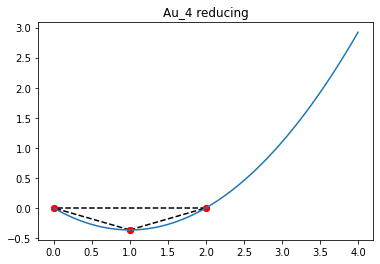

Tl4_red
{4: (-0.22062544629999997, None), 1.0: (-0.8199271266666665, None), 2.0: (-0.43597361499999987, None), 3.0: (-1.1031272314999998, None), 1.5: (-0.9372852321428575, None)} -0.22062544629999997


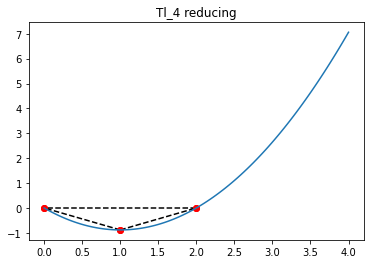

Pb4_red
{3.0: (-1.3921388914999993, None), 2.667: (-1.445836716785714, None), 2.0: (-1.4680857445312494, None), 1.0: (-0.6230187866666662, None), 0.667: (0.0013737950000001775, None), 3.333: (-1.3205758828125, None)} -1.2983015083333334


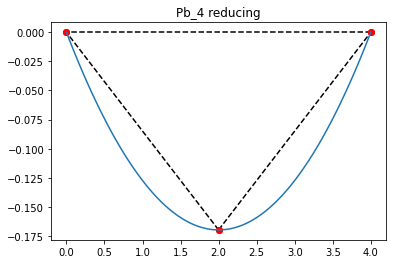

In [7]:
print("W4_ox")
ox2low, form_ene = get_ox2lowest('W', ele2mp[4]['W'], 4, oxidising=True)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'W', oxidising=True)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_ox['W4'] = coeffs
print("Ag4_red")
ox2low, form_ene = get_ox2lowest('Ag', ele2mp[4]['Ag'], 4, oxidising=False)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'Ag', oxidising=False)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_red['Ag4'] = coeffs
print("K4_red")
ox2low, form_ene = get_ox2lowest('K', ele2mp[4]['K'], 4, oxidising=False)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'K', oxidising=False)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_red['K4'] = coeffs
print("Cs4_red")
ox2low, form_ene = get_ox2lowest('Cs', ele2mp[4]['Cs'], 4, oxidising=False)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'Cs', oxidising=False)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_red['Cs4'] = coeffs
print("Au4_red")
ox2low, form_ene = get_ox2lowest('Au', ele2mp[4]['Au'], 4, oxidising=False)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'Au', oxidising=False)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_red['Au4'] = coeffs
print("Tl4_red")
ox2low, form_ene = get_ox2lowest('Tl', ele2mp[4]['Tl'], 4, oxidising=False)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'Tl', oxidising=False)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_red['Tl4'] = coeffs
print("Pb4_red")
ox2low, form_ene = get_ox2lowest('Pb', ele2mp[4]['Pb'], 4, oxidising=False)
hull_ox2energy = get_lower_hull_symmetric(ox2low, 4, form_ene, 'Pb', oxidising=False)
coeffs = get_quadratic(hull_ox2energy)
mp_quadratic_equations_red['Pb4'] = coeffs


Now the rest:

Ni2_ox, Al2_red, Tl2_red, Bi2_red, Sr3_ox, Ag3_ox, Pd3_ox, Cr4_ox, Ni4_ox

we set by hand by inspecting Materials Project or OQMD

In [8]:
oqmd_quadratic_equations_ox = pickle.load(open("oqmd_quadratic_equations_ox.p", "rb"))
# take difference between the NiO formation energy (mp-19009) 
# and the NiO2 () formation energy and divide by 2 (supposed difference in oxidation state)
mp_quadratic_equations_ox['Ni2'] = [0, 	(1.218-0.687)/2, 0]
# take difference in formation energy between AlO (mp-8023) and Al2O (mp-8022)
mp_quadratic_equations_red['Al2'] = [0, 1.555-0.139, 0]
# plotting Tl-O phase diagram we can see the TlO entry is high off the hull
# set to 1/2, as -1 is approximately the value at the hull for this conc of Tl:O
mp_quadratic_equations_red['Tl2'] = [0, 0.5, 0]
# plotting Bi-O phase diagram we can see the BiO entry is high off the hull
# set to 1.4/2, as -1.4 is approximately the value at the hull for this conc of Tl:O
mp_quadratic_equations_red['Bi2'] = [0, 0.7, 0]
# plotting Sr-O phase diagram we can see the Sr2O3 entry is high off the hull
# we set to same as the SrO2 oxidising parabola
mp_quadratic_equations_ox['Sr3'] = mp_quadratic_equations_ox['Sr4']
# take diff in formation energy between mp-546190 and mp-1214946
mp_quadratic_equations_ox['Ag3'] = [0, (0.359-0.01),0]
# fit by hand
mp_quadratic_equations_ox['Pd3'] = list(np.polyfit([0, 1, 4], [0, 0.05, 0.74], 2))
# this curve matches the general shape well
mp_quadratic_equations_ox['Cr4'] = oqmd_quadratic_equations_ox['Cr']
# we arrive at this value by taking the energy difference between NiO2 and Ni2O5
# mp-35925 and mp-1094139 respectively
mp_quadratic_equations_ox['Ni4'] = [0, 0.5, 0]



Exception ignored in: <_io.FileIO name='oqmd_quadratic_equations_ox.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_15861/2913030966.py", line 1, in <cell line: 1>


Lastly, some fitting lead to very low coefficients due to the instability of the reference oxide, this is the case for 
Ag4_ox, Au4_ox and Br4_ox

In [9]:
# match slope of the lower ox state oxide
mp_quadratic_equations_ox['Ag4'] = mp_quadratic_equations_ox['Ag3']
# match slope of the lower ox state oxide
mp_quadratic_equations_ox['Au4'] = mp_quadratic_equations_ox['Au3']
# point on hull for BrO2 conc is roughly 0.17, so divide this by 4
mp_quadratic_equations_ox['Br4'] = [0, 0.17/4, 0]


### Printing parabola coefficients for spreadsheet

In [10]:
for ox_iter in ox_states:
    print(ox_iter)
    for ele in unary_data.keys():
        print(ele, end=", ")
        print("{:.4f}".format(mp_quadratic_equations_ox[ele+str(int(ox_iter))][0]), end=", ")
        print("{:.4f}".format(mp_quadratic_equations_ox[ele+str(int(ox_iter))][1]), end=", ")
        print("{:.4f}".format(mp_quadratic_equations_red[ele+str(int(ox_iter))][0]), end=", ")
        print("{:.4f}".format(mp_quadratic_equations_red[ele+str(int(ox_iter))][1]))


2
Si, 0.3048, -1.2194, 0.0000, 1.0235
Al, 1.8742, -3.7485, 0.0000, 1.4160
Ti, 0.1483, -0.5933, 0.4256, 0.4244
V, 0.4352, -0.8705, 0.0000, 1.0450
Cr, 0.3993, -0.7986, 0.0000, 0.9830
Mn, 0.1596, -0.2130, 0.0000, 0.9892
Fe, 0.2253, -0.4506, 0.0000, 0.7404
Co, 0.0261, 0.0512, 0.0000, 0.6417
Ni, 0.0000, 0.2655, 0.2809, 1.0692
Cu, 0.0965, 0.0138, 0.0000, 0.4709
Nb, 0.0938, -0.5314, 0.0000, 1.1424
Mo, 0.2520, -1.0079, 0.0000, 0.5039
Li, 0.0000, 0.1935, 0.3008, -0.6015
Be, 0.0000, 0.5170, 0.0000, 1.5509
Na, 0.0000, 0.2371, 0.0217, -0.0435
Mg, 0.0000, 0.5090, 0.0000, 1.5269
K, 0.0117, 0.0111, 0.5445, -0.3862
Ca, 0.0000, 0.9553, 0.0000, 1.6539
Rb, 0.0165, -0.0210, 0.4671, -0.2566
Sr, 0.0000, 1.1879, 0.0000, 1.5380
Cs, 0.0022, -0.0044, 0.5058, -0.3531
Ba, 0.0000, 0.2721, 0.0000, 1.4113
Sc, 0.7280, -1.4561, 0.0000, 1.6197
Zn, 0.0000, 0.2983, 0.0000, 0.8950
Ga, 0.8840, -1.7680, 0.0000, 0.6919
Ge, 0.2597, -1.0388, 0.0000, 0.5194
As, 1.0854, -2.1708, 0.0000, 0.2714
Se, 0.1441, -0.5764, 0.0000, 0.2882

In [11]:
with open(r"mp_quadratic_equations_ox.p", "wb") as output_file:
    pickle.dump(mp_quadratic_equations_ox, output_file)

with open(r"mp_quadratic_equations_red.p", "wb") as output_file:
    pickle.dump(mp_quadratic_equations_red, output_file)
